[View in Colaboratory](https://colab.research.google.com/github/higepon/tensorflow_seq2seq_chatbot/blob/master/seq2seq.ipynb)

In [1]:
import os

def colab():
    return '/tools/node/bin/forever' == os.environ['_']

if colab():
    !pip -q install pydrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    def make_drive():
        # 1. Authenticate and create the PyDrive client.
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        return drive
    drive = make_drive()
else:        
    drive = None
    def make_drive():
        return None
      
run_on_master = True


KeyboardInterrupt: ignored

- Tensorflow 1.4.0+ is required.
- This is based on [NMT Tutorial](https://github.com/tensorflow/nmt).
- Experiment [notes](https://github.com/higepon/tensorflow_seq2seq_chatbot/wiki).



In [2]:
!pip -q install git+https://github.com/mrahtz/easy-tf-log#egg=easy-tf-log[tf]
from easy_tf_log import tflog, Logger
import easy_tf_log

# Hack to reset the logger state
#Logger.DEFAULT = None

from __future__ import print_function
from enum import Enum, auto

class Mode(Enum):
    Test = auto()
    TrainSeq2Seq = auto()
    TrainSeq2SeqSwapped = auto()
    TrainRL = auto()
    TweetBot = auto()

mode = Mode.Test
#mode = Mode.TrainSeq2Seq
#mode = Mode.TrainSeq2SeqSwapped
#mode = Mode.TrainRL
#mode = Mode.TweetBot


# @formatter:off
import copy as copy
from google.colab import files
import datetime
import re
import shutil
from pathlib import Path


import numpy as np
import tensorflow as tf
from tensorflow.python.layers import core as layers_core
from tensorflow.python.platform import gfile

#@formatter:on




if colab():
    import matplotlib.pyplot as plt

# Note for myself.
# You've summarized Seq2Seq
# at http://d.hatena.ne.jp/higepon/20171210/1512887715.

# If you see following error, it means your max(len(tweets of training set)) <  decoder_length.
# This should be a bug somewhere in build_decoder, but couldn't find one yet.
# You can workaround by setting hparams.decoder_length=max len of tweet in training set.
# InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [48,50] and labels shape [54]
#	 [[Node: root/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, 

print(tf.__version__)

def data_dir():
    target_dir = "{}/chatbot_data".format(str(Path.home()))
    if not colab() and not os.path.exists(target_dir):
        raise Exception("{} not found, you may create".format(target_dir))
    return target_dir


def info(message, hparams):
    if hparams.debug_verbose:
        print(message)


def p(path):
    if colab():
        return path
    else:
        return "{}/{}".format(data_dir(), path)


def has_gpu0():
    return tf.test.gpu_device_name() == "/device:GPU:0"


class ModelDirectory(Enum):
    tweet_large = 'model/tweet_large'
    tweet_large_rl = 'model/tweet_large_rl'
    tweet_large_swapped = 'model/tweet_large_swapped'
    tweet_small = 'model/tweet_small'
    tweet_small_swapped = 'model/tweet_small_swapped'
    tweet_small_rl = 'model/tweet_small_rl'
    test_multiple1 = 'model/test_multiple1'
    test_multiple2 = 'model/test_multiple2'
    test_multiple3 = 'model/test_multiple3'
    test_distributed = 'model/test_distributed'

    @staticmethod
    def create_all_directories():
        for d in ModelDirectory:
            os.makedirs(p(d.value), exist_ok=True)


# todo
# collect all initializer
ModelDirectory.create_all_directories()


if run_on_master:
    class GoogleDriveFolder(Enum):
        root = '146ZLldWXLDH0l9WbSUNFKi3nVK_HV0Sz'
        seq2seq = '18lYBgKvX3AG1zhwJqP1tRYJU688U1N95'
        seq2seq_swapped = '1w56FFoKStEfZNThA2Y_jx3NDTELcau52'
        seq2seq_rl = '1pHnOuT_7JjD1TS8VQ4KN9oUiblBIABXJ'
else:
    class GoogleDriveFolder(Enum):
        root = '15Z3wbaSjR34ziPgAVEFiXgM67ln1Z9Xt'
        seq2seq = '1KdMwLNbUfI_PZ5QTyi2zvcS___ct399p'
        seq2seq_swapped = '1OjvR4TXAVudSiI-A7EBjw3gLoY4mrO7i'
        seq2seq_rl = '161ler0gTpsvFUPAvc4x1__jyClJ_8IyB'

base_hparams = tf.contrib.training.HParams(
    machine='master' if run_on_master else 'slave',
    batch_size=3,
    num_units=6,
    num_layers=2,
    vocab_size=9,
    embedding_size=8,
    learning_rate=0.01,
    learning_rate_decay=0.99,
    use_attention=False,
    encoder_length=5,
    decoder_length=5,    
    max_gradient_norm=5.0,
    beam_width=2,
    num_train_steps=100,
    debug_verbose=False,
    model_folder_in_drive=GoogleDriveFolder.seq2seq.value,
    model_path='Please override model_directory',
    sos_id=0,
    eos_id=1,
    pad_id=2,
    unk_id=3,
    sos_token="[SOS]",
    eos_token="[EOS]",
    pad_token="[PAD]",
    unk_token="[UNK]",
)

test_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {'beam_width': 0, 'num_train_steps': 100, 'learning_rate': 0.5})



test_attention_hparams = copy.deepcopy(test_hparams).override_from_dict(
    {'use_attention': True})



1.7.0


In [0]:
def print_hparams(hparams):
  result = {}
  for key in ['machine', 'batch_size', 'num_units', 'num_layers', 'vocab_size',
              'embedding_size', 'learning_rate', 'learning_rate_decay',
              'use_attention', 'encoder_length', 'decoder_length',
              'max_gradient_norm', 'beam_width', 'num_train_steps',
              'model_path']:
    result[key] = hparams.get(key)
  print(result)
    


In [0]:
# For debug purpose.
tf.reset_default_graph()


class ChatbotModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")
        self.target_labels, self.loss, self.global_step, self.learning_rate, self.train_op = self._build_optimizer(
            hparams, self.logits)
        self.train_loss_summary = tf.summary.scalar("loss", self.loss)
        self.reward_summary = tf.summary.scalar("reward", self.reward)
        self.valiation_loss_summary = tf.summary.scalar("validation_loss", self.loss)
        self.merged_summary = tf.summary.merge_all()

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def train(self, encoder_inputs, encoder_inputs_lengths, target_labels,
              decoder_inputs, decoder_target_lengths, reward=1.0):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: reward
        }
        _, global_step, summary, reward_summary = self.sess.run(
            [self.train_op, self.global_step, self.train_loss_summary, self.reward_summary], feed_dict=feed_dict)

        return global_step, self.learning_rate, summary, reward_summary, reward

    def batch_loss(self, encoder_inputs, encoder_inputs_lengths, target_labels,
                   decoder_inputs, decoder_target_lengths):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: 1
        }
        return self.sess.run([self.loss, self.valiation_loss_summary],
                             feed_dict=feed_dict)
      
    def input_length(self, input):
      try :
        l = input.index(self.hparams.eos_id)
        return l + 1
      except ValueError:
        return self.hparams.encoder_length

    def train_with_reward(self, infer_model, standard_seq2seq_model,
                          encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths,
                          dull_responses):
        infered_replies = infer_model.infer(encoder_inputs,
                                            encoder_inputs_lengths)
#        print(infered_replies)
        standard_seq2seq_encoder_inputs = []
        standard_seq2seq_encoder_inputs_lengths = []
        for reply in infered_replies:
            l = self.input_length(reply.tolist())
            standard_seq2seq_encoder_inputs_lengths.append(l)
            if l <= self.hparams.encoder_length:
                standard_seq2seq_encoder_inputs.append(np.append(reply, (
                        [self.hparams.pad_id] * (self.hparams.encoder_length - len(reply)))))
                None
            else:
                raise Exception(
                    "Inferred"
                    " reply shouldn't be longer than encoder_input")
        standard_seq2seq_encoder_inputs = np.transpose(
            np.array(standard_seq2seq_encoder_inputs))
        if True:
#           print(standard_seq2seq_encoder_inputs_lengths)
           reward1 = np.mean(standard_seq2seq_encoder_inputs_lengths) / self.hparams.encoder_length
        else:
          reward1 = standard_seq2seq_model.reward_ease_of_answering(
              standard_seq2seq_encoder_inputs,
              standard_seq2seq_encoder_inputs_lengths, dull_responses)


        reward2 = 0  # todo
        reward3 = 0  # todo
        reward = 0.25 * reward1 + 0.25 * reward2 + 0.5 * reward3
        
        return self.train(encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths, reward)

    def save(self, model_path=None):
        if model_path is None:
            model_path = self.model_path
        model_dir = "{}/{}".format(model_path, self.name)
        self.saver.save(self.sess, model_dir, global_step=self.global_step)

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def _build_optimizer(self, hparams, logits):
        # Target labels
        #   As described in doc for sparse_softmax_cross_entropy_with_logits,
        #   labels should be [batch_size, decoder_target_lengths]
        #   instead of [batch_size, decoder_target_lengths, vocab_size].
        #   So labels should have indices instead of vocab_size classes.
        target_labels = tf.placeholder(tf.int32, shape=(
            hparams.batch_size, hparams.decoder_length), name="target_labels")
        
        # Loss
        #   target_labels: [batch_size, decoder_length]
        #   logits: [batch_size, decoder_length, vocab_size]
        #   crossent: [batch_size, decoder_length]
        crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=target_labels, logits=logits)
        
        target_weights = tf.sequence_mask(self.decoder_target_lengths, hparams.decoder_length, dtype=logits.dtype)

        loss = tf.reduce_sum(
          crossent * target_weights) / tf.to_float(hparams.batch_size)
        
        # Adjust loss with reward.
        loss = tf.multiply(loss, self.reward)

        # Train
        global_step = tf.get_variable(name="global_step", shape=[],
                                      dtype=tf.int32,
                                      initializer=tf.constant_initializer(0),
                                      trainable=False)
        
        learning_rate = hparams.learning_rate # tf.train.exponential_decay(hparams.learning_rate, global_step, 100, hparams.learning_rate_decay) 

        # Calculate and clip gradients
        params = tf.trainable_variables()
        for param in params:
          info("  {}, {}, {}".format(param.name, str(param.get_shape()),
                                        param.op.device), hparams)
        
        gradients = tf.gradients(loss, params)
        clipped_gradients, _ = tf.clip_by_global_norm(
            gradients, hparams.max_gradient_norm)

        # Optimization
#        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        device = '/cpu:0'
        if has_gpu0():
            device = '/gpu:0'
            print("!!!GPU ENABLED !!!")
        with tf.device(device):
            train_op = optimizer.apply_gradients(
                zip(clipped_gradients, params), global_step=global_step)
        return target_labels, loss, global_step, learning_rate, train_op

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length comes
        #   first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.encoder_length, hparams.batch_size), name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="encoder_inputs_lengtsh")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_training_decoder(hparams, encoder_inputs_lengths,
                                encoder_state, encoder_outputs, decoder_cell,
                                decoder_emb_inputs, decoder_target_lengths,
                                projection_layer):
        # Decoder with helper:
        #   decoder_emb_inputs: [decoder_length, batch_size, embedding_size]
        #   decoder_target_lengths: [batch_size] vector,
        #   which represents each target sequence length.
        training_helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb_inputs,
                                                            decoder_target_lengths,
                                                            time_major=True)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(hparams.batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

            # Decoder and decode
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, training_helper, initial_state,
            output_layer=projection_layer)

        # Dynamic decoding
        #   final_outputs.rnn_output: [batch_size, decoder_length,
        #                             vocab_size], list of RNN state.
        #   final_outputs.sample_id: [batch_size, decoder_length],
        #                            list of argmax of rnn_output.
        #   final_state: [batch_size, num_units],
        #                list of final state of RNN on decode process.
        #   final_sequence_lengths: [batch_size], list of each decoded sequence. 
        final_outputs, _final_state, _final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            training_decoder)

        if hparams.debug_verbose:
            print("rnn_output.shape=", final_outputs.rnn_output.shape)
            print("sample_id.shape=", final_outputs.sample_id.shape)
            print("final_state=", _final_state)
            print("final_sequence_lengths.shape=",
                  _final_sequence_lengths.shape)

        logits = final_outputs.rnn_output
        return logits, wrapped_decoder_cell, initial_state

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.decoder_length, hparams.batch_size), name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="decoder_target_lengths")

        # Look up embedding:
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_emb_inp: [decoder_length, batch_size, embedding_size]
        decoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    decoder_inputs)

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear layer
        # that converts (projects) from the internal representation
        #  to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter matrix
        # and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)

        # Training graph
        logits, wrapped_decoder_cell, initial_state = self._build_training_decoder(
            hparams, encoder_inputs_lengths, encoder_state, encoder_outputs,
            decoder_cell, decoder_emb_inputs, decoder_target_lengths,
            projection_layer)

        return decoder_inputs, decoder_target_lengths, logits


In [0]:
class ChatbotInferenceModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.replies, self.beam_replies, self.infer_logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")

        # we can't use variable length here, 
        # because tiled_batch requires constant length.
        self.batch_size = 1

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def infer(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search enabled.
        assert(self.hparams.beam_width == 0)
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.replies, feed_dict=inference_feed_dict)
        return replies

    def infer_beam_search(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search disabled.
        assert(self.hparams.beam_width > 0)      
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.beam_replies,
                                feed_dict=inference_feed_dict)
        return replies
     
    # imakoko
    def infer_mi(self, swapped_model, encoder_inputs, encoder_inputs_lengths):
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        beam_replies = self.sess.run(self.beam_replies, feed_dict=inference_feed_dict)
        # beam_replis [batch_size, length, , batch_width]
        # for now we assume encoder_inputs is batch_size = 1
        
        swapped_encoder_inputs = beam_replies[0]
        # beam_width = batch_size
        swapped_batch_size = swapped_encoder_inputs.shape[1]
        
        # beam_replies can be shorten less than decoder_output_legth, so we pad them.
        paddings = tf.constant([[0, self.hparams.encoder_length - swapped_encoder_inputs.shape[0],], [0, 0]])
        swapped_encoder_inputs = swapped_model.sess.run(tf.pad(swapped_encoder_inputs, paddings, "CONSTANT", constant_values=self.hparams.pad_id))
        swapped_encoder_inputs_lengths = np.empty(swapped_batch_size, dtype=np.int)
        for i in range(swapped_batch_size):
          swapped_encoder_inputs_lengths[i] = swapped_encoder_inputs.shape[0]
        
        return swapped_model.infer_beam_search(swapped_encoder_inputs, swapped_encoder_inputs_lengths)
        # todo make correct length
#        for repy in beam_replies:
          # logits from swapped_model for this reply
          # cals prob for in original encoder_input
      

    def log_prob(self, encoder_inputs, encoder_inputs_lengths, expected_output):
        """Return sum of log probability of given
           one specific expected_output for encoder_inputs.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_output: [1, decoder_length or less than decoder_length],
            eg) One reply.
    
        Returns:
            Return log probablity of expected output for given encoder inputs.
            eg) sum of log probability of reply "Good" when given ["How are you?",
             "What's up?"]
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            p = 1
            # Note that expected_output and logits don't always have
            # same length, but zip takes care of the case.
            for word_id, logit in zip(expected_output, logits):
                # Apply softmax first, see definition of softmax.
                norm = (self._softmax(logit))[word_id]
                p *= norm
            p = np.log(p)
            sum_p.append(p)
        ret = np.sum(sum_p) / len(sum_p)
        return ret

    def reward_ease_of_answering(self, encoder_inputs, encoder_inputs_lengths,
                                 expected_outputs):
        """ Return reward for ease of answering. 
            See Deep Reinforcement Learning for Dialogue Generation
            for more details.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_outputs: [number of pre-defined dull responses,
            decoder_length or less than decoder_length].
            eg) [["I'm", "Good"], ["fine"]]
    
        Returns:
            Return reward for ease of answering.
            Note that this can be calculated
            by calling log_prob function for each dull response,
            but this function is more efficient
            because this calculated the reward at once.
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        batch_sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            sum_p = []
            for expected_output in expected_outputs:
                p = 1
                # Note that expected_output and logits don't
                # always have same length, but zip takes care of the case.
                for word_id, logit in zip(expected_output, logits):
                    # Apply softmax first, see definition of softmax.
                    norm = (self._softmax(logit))[word_id]
                    p *= norm
                p = np.log(p) / len(expected_output)
                sum_p.append(p)
            one_batch_p = np.sum(sum_p)
            batch_sum_p.append(one_batch_p)
        ret = np.sum(batch_sum_p) / len(batch_sum_p)
        return -ret

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length
        #   comes first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.encoder_length, None],
                                        name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="encoder_inputs_lengths")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
#            encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_greedy_inference(hparams, embedding_encoder, encoder_state,
                                encoder_inputs_lengths, encoder_outputs,
                                decoder_cell, projection_layer):
        if hparams.beam_width > 0:
          return None, None
        
        # Greedy decoder
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding_encoder,
            tf.fill([dynamic_batch_size], hparams.sos_id), hparams.eos_id)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(dynamic_batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

        inference_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, inference_helper, initial_state,
            output_layer=projection_layer)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        # Dynamic decoding
        outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        replies = outputs.sample_id

        # We use infer_logits instead of logits when calculating log_prob,
        # because infer_logits doesn't require decoder_target_lengths input.
        infer_logits = outputs.rnn_output
        return infer_logits, replies

    @staticmethod
    def _build_beam_search_inference(hparams, encoder_inputs_lengths,
                                     embedding_encoder, encoder_state,
                                     encoder_outputs, decoder_cell,
                                     projection_layer):
      
        if hparams.beam_width == 0:
          return None
      
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        # https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            tiled_encoder_outputs = tf.contrib.seq2seq.tile_batch(
                attention_encoder_outputs, multiplier=hparams.beam_width)
            tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(
                encoder_state, multiplier=hparams.beam_width)
            tiled_encoder_inputs_lengths = tf.contrib.seq2seq.tile_batch(
                encoder_inputs_lengths, multiplier=hparams.beam_width)

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units, tiled_encoder_outputs,
                memory_sequence_length=tiled_encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            decoder_initial_state = wrapped_decoder_cell.zero_state(
                dtype=tf.float32,
                batch_size=dynamic_batch_size * hparams.beam_width)
            decoder_initial_state = decoder_initial_state.clone(
                cell_state=tiled_encoder_final_state)
        else:
            wrapped_decoder_cell = decoder_cell
            decoder_initial_state = tf.contrib.seq2seq.tile_batch(encoder_state,
                                                                  multiplier=hparams.beam_width)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=wrapped_decoder_cell,
            embedding=embedding_encoder,
            start_tokens=tf.fill([dynamic_batch_size], hparams.sos_id),
            end_token=hparams.eos_id,
            initial_state=decoder_initial_state,
            beam_width=hparams.beam_width,
            output_layer=projection_layer,
            length_penalty_weight=0.0)

        # Dynamic decoding
        beam_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        beam_replies = beam_outputs.predicted_ids
        return beam_replies

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.decoder_length, None],
                                        name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="decoder_target_lengths")

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear
        # layer that converts (projects) from the internal
        # representation to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter
        # matrix and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        

        # Greedy Inference graph
        infer_logits, replies = self._build_greedy_inference(hparams,
                                                             embedding_encoder,
                                                             encoder_state,
                                                             encoder_inputs_lengths,
                                                             encoder_outputs,
                                                             decoder_cell,
                                                             projection_layer)

        # Beam Search Inference graph
        beam_replies = self._build_beam_search_inference(hparams,
                                                         encoder_inputs_lengths,
                                                         embedding_encoder,
                                                         encoder_state,
                                                         encoder_outputs,
                                                         decoder_cell,
                                                         projection_layer)

        return decoder_inputs, decoder_target_lengths, replies, beam_replies, infer_logits


In [0]:
class InferenceHelper:
    def __init__(self, model, vocab, rev_vocab):
        self.model = model
        self.vocab = vocab
        self.rev_vocab = rev_vocab

    def inferences(self, tweet):
        encoder_inputs, encoder_inputs_lengths = self.create_inference_input(
            tweet)
        if self.model.hparams.beam_width == 0:
          replies = self.model.infer(encoder_inputs, encoder_inputs_lengths)
          ids = replies[0].tolist()
          return [self.sanitize_text(self.ids_to_words(ids))]
        else:
          beam_replies = self.model.infer_beam_search(encoder_inputs,
                                                      encoder_inputs_lengths)

          return [self.sanitize_text(self.ids_to_words(beam_replies[0][:, i])) for i in range(self.model.hparams.beam_width)]
        
    def sanitize_text(self, line):
      line = re.sub(r"\[EOS\]", " ", line)
      line = re.sub(r"\[UNK\]", "💩", line)
      return line

    def print_inferences(self, tweet):
        print(tweet)
        for i, reply in enumerate(self.inferences(tweet)):
            print("    [{}]{}".format(i, reply))

    def words_to_ids(self, words):
        ids = []
        for word in words:
            if word in self.vocab:
                ids.append(self.vocab[word])
            else:
                ids.append(self.model.hparams.unk_id)
        return ids

    def ids_to_words(self, ids):
        words = ""
        for id in ids:
            words += self.rev_vocab[id]
        return words

    def create_inference_input(self, text):
        inference_encoder_inputs = np.empty((self.model.hparams.encoder_length, 1),
                                            dtype=np.int)
        inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
        text = TrainDataGenerator.sanitize_line(text)
        tagger = MeCab.Tagger("-Owakati")
        words = tagger.parse(text).split()
        ids = self.words_to_ids(words)
        ids = ids[:self.model.hparams.encoder_length]
        len_ids = len(ids)
        ids.extend([self.model.hparams.pad_id] * (self.model.hparams.encoder_length - len(ids)))
        for i in range(1):
            inference_encoder_inputs[:, i] = np.array(ids, dtype=np.int)
            inference_encoder_inputs_lengths[i] = len_ids
        return inference_encoder_inputs, inference_encoder_inputs_lengths


In [0]:
class TrainDataGenerator:
    def __init__(self, source_path, hparams):
        self.source_path = source_path
        self.hparams = hparams
        basename, extension = os.path.splitext(self.source_path)
        self.enc_path = "{}_enc{}".format(basename, extension)
        self.dec_path = "{}_dec{}".format(basename, extension)
        self.enc_idx_path = "{}_enc_idx{}".format(basename, extension)
        self.dec_idx_path = "{}_dec_idx{}".format(basename, extension)
        self.dec_idx_eos_path = "{}_dec_idx_eos{}".format(basename, extension)
        self.dec_idx_sos_path = "{}_dec_idx_sos{}".format(basename, extension)
        self.dec_idx_len_path = "{}_dec_idx_len{}".format(basename, extension)

        self.enc_idx_padded_path = "{}_enc_idx_padded{}".format(basename,
                                                                extension)
        self.enc_idx_len_path = "{}_enc_idx_len{}".format(basename, extension)

        self.vocab_path = "{}_vocab{}".format(basename, extension)
        
        self.generated_files = [self.enc_path, self.dec_path, self.enc_idx_path, self.dec_idx_path, self.dec_idx_eos_path, self.dec_idx_sos_path, self.dec_idx_len_path, self.enc_idx_padded_path, self.vocab_path, self.enc_idx_len_path]
        self.max_vocab_size = hparams.vocab_size
        self.start_vocabs = [hparams.sos_token, hparams.eos_token, hparams.pad_token, hparams.unk_token]
        self.tagger = MeCab.Tagger("-Owakati")
        
    def remove_generated(self):
      for f in self.generated_files:
        if os.path.exists(f):
          os.remove(f)

    def generate(self):
        print("generating enc and dec files...")
        self._generate_enc_dec()
        print("generating vocab file...")
        self._generate_vocab()
        print("loading vocab...")
        vocab, _ = self._load_vocab()
        print("generating id files...")
        self._generate_id_file(self.enc_path, self.enc_idx_path, vocab)
        self._generate_id_file(self.dec_path, self.dec_idx_path, vocab)
        print("generating padded input file...")
        self._generate_enc_idx_padded(self.enc_idx_path,
                                      self.enc_idx_padded_path,
                                      self.enc_idx_len_path,
                                      self.hparams.encoder_length)
        print("generating dec eos/sos files...")
        self._generate_dec_idx_eos(self.dec_idx_path, self.dec_idx_eos_path,
                                   self.hparams.decoder_length)
        self._generate_dec_idx_sos(self.dec_idx_path, self.dec_idx_sos_path,
                                   self.dec_idx_len_path,
                                   self.hparams.decoder_length)
        print("done")
        return self._create_dataset()

    def _generate_id_file(self, source_path, dest_path, vocab):
        if gfile.Exists(dest_path):
            return
        with gfile.GFile(source_path, mode="rb") as f, gfile.GFile(dest_path,
                                                                   mode="wb") as of:
            for line in f:
                line = line.decode('utf-8')
                words = self.tagger.parse(line).split()
                ids = [vocab.get(w, self.hparams.unk_id) for w in words]
                of.write(" ".join([str(id) for id in ids]) + "\n")

    def _load_vocab(self):
        rev_vocab = []
        with gfile.GFile(self.vocab_path, mode="r") as f:
            rev_vocab.extend(f.readlines())
            rev_vocab = [line.strip() for line in rev_vocab]
            # Dictionary of (word, idx)
            vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
            return vocab, rev_vocab

    def _generate_vocab(self):
        if gfile.Exists(self.vocab_path):
            return
        vocab_dic = self._build_vocab_dic(self.enc_path)
        vocab_dic = self._build_vocab_dic(self.dec_path, vocab_dic)
        vocab_list = self.start_vocabs + sorted(vocab_dic, key=vocab_dic.get,
                                                reverse=True)
        if len(vocab_list) > self.max_vocab_size:
            vocab_list = vocab_list[:self.max_vocab_size]
        with gfile.GFile(self.vocab_path, mode="w") as vocab_file:
            for w in vocab_list:
                vocab_file.write(w + "\n")

    def _generate_enc_dec(self):
        if gfile.Exists(self.enc_path) and gfile.Exists(self.dec_path):
            return
        with gfile.GFile(self.source_path, mode="rb") as f, gfile.GFile(
                self.enc_path, mode="w+") as ef, gfile.GFile(self.dec_path,
                                                             mode="w+") as df:
            tweet = None
            reply = None
            for i, line in enumerate(f):
                line = line.decode('utf-8')
                line = self.sanitize_line(line)
                if i % 2 == 0:
                  tweet = line
                else:
                  reply = line
                  if tweet and reply:
                    ef.write(tweet)
                    df.write(reply)
                  tweet = None
                  reply = None

    def _generate_enc_idx_padded(self, source_path, dest_path, dest_len_path,
                                 max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path,
                                            "w") as fout, open(dest_len_path,
                                                               "w") as flen:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len:
#                    ids = ids[:max_line_len]
                    ids = ids[-max_line_len:]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and append eos at the end of idx list.
    def _generate_dec_idx_eos(self, source_path, dest_path, max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len - 1:
#                    ids = ids[:max_line_len - 1]
                  ids = ids[-(max_line_len - 1):]
                ids.append(self.hparams.eos_id)
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and put sos at the beginning of the idx list.
    # also write out length of index list.
    def _generate_dec_idx_sos(self, source_path, dest_path, dest_len_path,
                              max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout, open(
                dest_len_path, "w") as flen:
            line = fin.readline()
            while line:
                ids = [self.hparams.sos_id]
                ids.extend([int(x) for x in line.split()])
                if len(ids) > max_line_len:
                    ids = ids[:max_line_len]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    @staticmethod
    def sanitize_line(line):
        # replace @username
        # replacing @username had bad impace where USERNAME token shows up everywhere.
#        line = re.sub(r"@([A-Za-z0-9_]+)", "USERNAME", line)
        line = re.sub(r"@([A-Za-z0-9_]+)", "", line)
        # Remove URL
        line = re.sub(r'https?:\/\/.*', "", line)
        line = line.lstrip()
        return line

    @staticmethod
    def generate_source_target_swapped(source_path):
        basename, extension = os.path.splitext(source_path)
        dest_path = "{}_swapped{}".format(basename, extension)
        with gfile.GFile(source_path, mode="rb") as fin, gfile.GFile(dest_path,
                                                                     mode="w+") as fout:
            temp = None
            for i, line in enumerate(fin):
                if i % 2 == 0:
                    temp = line
                else:
                    fout.write(line)
                    fout.write(temp)
                    temp = None
        return dest_path

    def _build_vocab_dic(self, source_path, vocab_dic={}):
        with gfile.GFile(source_path, mode="r") as f:
            for line in f:
                words = self.tagger.parse(line).split()
                for word in words:
                    if word in vocab_dic:
                        vocab_dic[word] += 1
                    else:
                        vocab_dic[word] = 1
            return vocab_dic

    @staticmethod
    def _read_file(source_path):
        f = open(source_path)
        data = f.read()
        f.close()
        return data

    def _read_vocab(self, source_path):
        rev_vocab = []
        rev_vocab.extend(self._read_file(source_path).splitlines())
        rev_vocab = [line.strip() for line in rev_vocab]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab

    def text_line_split_dataset(self, filename):
        return tf.data.TextLineDataset(filename).map(self.split_to_int_values)

    @staticmethod
    def split_to_int_values(x):
        return tf.string_to_number(tf.string_split([x]).values, tf.int32)

    def _create_dataset(self):

        tweets_dataset = self.text_line_split_dataset(self.enc_idx_padded_path)
        tweets_lengths_dataset = tf.data.TextLineDataset(
            self.enc_idx_len_path)

        replies_sos_dataset = self.text_line_split_dataset(
            self.dec_idx_sos_path)
        replies_eos_dataset = self.text_line_split_dataset(
            self.dec_idx_eos_path)
        replies_sos_lengths_dataset = tf.data.TextLineDataset(
            self.dec_idx_len_path)

        tweets_transposed = tweets_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        tweets_lengths = tweets_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))

        replies_with_eos_suffix = replies_eos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))
        replies_with_sos_prefix = replies_sos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        replies_with_sos_suffix_lengths = replies_sos_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size))
        vocab, rev_vocab = self._read_vocab(self.vocab_path)
        return tf.data.Dataset.zip((tweets_transposed, tweets_lengths,
                                    replies_with_eos_suffix,
                                    replies_with_sos_prefix,
                                    replies_with_sos_suffix_lengths)), vocab, rev_vocab

In [0]:
class TrainDataSource:
  def __init__(self, source_path, hparams):
    download_file_if_necessary(source_path)
    generator = TrainDataGenerator(source_path=source_path,
                                   hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()
    self.train_dataset = train_dataset.repeat().shuffle(1024)
    # todo(higepon): Use actual validation dataset.
    self.valid_dataset = train_dataset.repeat().shuffle(1024,
                                                        seed=1234)
    self.vocab = vocab
    self.rev_vocab = rev_vocab


class Trainer:
  def __init__(self):
    self.loss_step = []
    self.val_losses = []
    self.reward_step = []
    self.reward_average = []
    self.last_saved_time = datetime.datetime.now()
    self.last_stats_time = datetime.datetime.now()
    self.num_stats_per = 20
    self.reward_history = []

  def train_rl_tweets(self, src_hparams, dst_hparams, source_path, tweets,
                      dull_responses,
                      drive=None):
    print("===== Train RL {} ====".format(source_path))
    print("src:")
    print_hparams(src_hparams)
    print("dst")
    print_hparams(dst_hparams)
    data_source = TrainDataSource(source_path, dst_hparams)

    self._rl_train_loop(data_source, src_hparams, dst_hparams, tweets,
                        dull_responses, drive=drive)

  def train_seq2seq_swapped(self, hparams, tweets_path, validation_tweets,
                            should_clean_saved_model=True, drive=None):
    download_file_if_necessary(tweets_path)
    swapped_path = TrainDataGenerator.generate_source_target_swapped(
      tweets_path)
    self.train_seq2seq(hparams, swapped_path, validation_tweets,
                       should_clean_saved_model, drive)

  def train_seq2seq(self, hparams, tweets_path, val_tweets,
                    should_clean_saved_model=True, drive=None):
    print("===== Train Seq2Seq {} ====".format(tweets_path))
    print_hparams(hparams)
    
    if should_clean_saved_model:
      clean_model_path(hparams.model_path)
    data_source = TrainDataSource(tweets_path, hparams)
    self._train_loop(data_source, hparams, val_tweets, drive=drive)

  def _print_inferences(self, global_step, tweets, helper, beam_helper=None):
    print("==== {} ====".format(global_step))
    len_array = []
    for tweet in tweets:
      len_array.append(len(helper.inferences(tweet)[0]))
      helper.print_inferences(tweet)
      if beam_helper is not None:
        beam_helper.print_inferences(tweet)
    self._print_log('avg_reply_len', np.mean(len_array))

  # should this be public/private?
  @staticmethod
  def create_models(hparams):

    # See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph, config=config)
    with train_graph.as_default():
      with tf.variable_scope('root'):
        model = ChatbotModel(train_sess, hparams,
                             model_path=hparams.model_path)
        if not model.restore():
          train_sess.run(tf.global_variables_initializer())

    # note that infer_model is not sharing variable with training model.
    infer_graph = tf.Graph()
    infer_sess = tf.Session(graph=infer_graph, config=config)
    with infer_graph.as_default():
      with tf.variable_scope('root'):
        infer_model = ChatbotInferenceModel(infer_sess, hparams,
                                            model_path=hparams.model_path)

    return model, infer_model

  # should thi be public/private
  def create_rl_models(self, dst_hparams, src_hparams):
    model, infer_model = self.create_models(
      dst_hparams)
    rl_beam_hparams = copy.deepcopy(dst_hparams).override_from_dict(
      {'beam_width': 2})
    infer_sess = infer_model.sess
    with infer_sess.graph.as_default():
      with tf.variable_scope('root', reuse=True):
        infer_beam_model = ChatbotInferenceModel(infer_sess,
                                                 rl_beam_hparams,
                                                 model_path=rl_beam_hparams.model_path)
    restored = infer_model.restore()
    if not restored:
      with rl_infer_graph.as_default():
        infer_sess.run(tf.global_variables_initializer())
    seq2seq_graph = tf.Graph()
    seq2seq_sess = tf.Session(graph=seq2seq_graph)
    with seq2seq_graph.as_default():
      with tf.variable_scope('root'):
        seq2seq_infer_model = ChatbotInferenceModel(seq2seq_sess,
                                                    src_hparams,
                                                    model_path=src_hparams.model_path)
        restored = seq2seq_infer_model.restore()
        assert restored
    return infer_beam_model, infer_model, model, seq2seq_infer_model

  def _train_loop(self, data_source,
                  hparams, tweets, drive=None):
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                     hparams.model_path)

    device = self._available_device()
    with tf.device(device):
      model, infer_model = self.create_models(hparams)

    def my_train(**kwargs):
      data = kwargs['train_data']
      return model.train(data[0], data[1], data[2], data[3], data[4])

    self._generic_loop(drive, data_source, hparams, infer_model, None,
                       model,
                       tweets, my_train)

  def _rl_train_loop(self, data_source, src_hparams, dst_hparams, tweets,
                     dull_responses, drive=None):
    download_model_data_if_necessary(drive,
                                     src_hparams.model_folder_in_drive,
                                     src_hparams.model_path)
    download_model_data_if_necessary(drive,
                                     dst_hparams.model_folder_in_drive,
                                     dst_hparams.model_path)

    device = self._available_device()
    with tf.device(device):
      infer_beam_model, infer_model, model, seq2seq_infer_model = self.create_rl_models(
        dst_hparams, src_hparams)

    def my_train(**kwargs):
      train_data = kwargs['train_data']
      dull_responses_ids = kwargs['dull_responses_ids']
      return model.train_with_reward(
        infer_model,
        seq2seq_infer_model,
        train_data[0],
        train_data[1],
        train_data[2],
        train_data[3],
        train_data[4],
        dull_responses_ids)

    self._generic_loop(drive, data_source, dst_hparams, infer_model,
                       infer_beam_model, model,
                       tweets, my_train,
                       dull_responses)

  @staticmethod
  def _available_device():
    device = '/cpu:0'
    if has_gpu0():
      device = '/gpu:0'
      print("!!!GPU ENABLED !!!")
    return device

  @staticmethod
  def tokenize(infer_helper, text):
    tagger = MeCab.Tagger("-Owakati")
    words = tagger.parse(text).split()
    return infer_helper.words_to_ids(words)

  def _generic_loop(self, drive, data_source, hparams, infer_model,
                    infer_beam_model, model,
                    tweets, train_func,
                    dull_responses=None):
    vocab = data_source.vocab
    rev_vocab = data_source.rev_vocab
    infer_helper = InferenceHelper(infer_model, vocab, rev_vocab)
    beam_helper = None if infer_beam_model is None else InferenceHelper(
      infer_beam_model, vocab, rev_vocab)

    if dull_responses is None:
      dull_responses_ids = None
    else:
      dull_responses_ids = [self.tokenize(infer_helper, text)
                            for text in
                            dull_responses]
    graph = model.sess.graph
    with graph.as_default():
      train_data_next = data_source.train_dataset.make_one_shot_iterator().get_next()
      val_data_next = data_source.valid_dataset.make_one_shot_iterator().get_next()
      easy_tf_log.set_dir(hparams.model_path)
      writer = tf.summary.FileWriter(hparams.model_path, graph)
      self.last_saved_time = datetime.datetime.now()
      for i in range(hparams.num_train_steps):
        train_data = model.sess.run(train_data_next)

        step, learning_rate, summary, reward_summary, reward = train_func(
          train_data=train_data, dull_responses_ids=dull_responses_ids)
        writer.add_summary(summary, step)
        writer.add_summary(reward_summary, step)
        self._print_reward(step, reward)

        if i != 0 and i % self.num_stats_per == 0:
          model.save(hparams.model_path)
          is_restored = infer_model.restore()
          assert is_restored
          self._print_inferences(step, tweets, infer_helper, beam_helper)
          self._compute_val_loss(step, model, val_data_next, writer)
          self._print_stats(hparams, learning_rate)
          self._plot_if_necessary()
          self._save_model_in_drive(drive, hparams)
        else:
          print('.', end='')

  def _plot_if_necessary(self):
    if len(self.reward_average) > 0 and len(self.reward_average) % 5 == 0:
      self._plot(self.reward_step, self.reward_average,
                 y_label='reward average')
      self._plot(self.loss_step, self.val_losses, y_label='validation_loss')

  def _print_stats(self, hparams, learning_rate):
    print("learning rate", learning_rate)
    delta = (
                datetime.datetime.now() - self.last_stats_time).total_seconds() * 1000
    self._print_log("msec/data",
                    delta / hparams.batch_size / self.num_stats_per)
    self.last_stats_time = datetime.datetime.now()

  def _save_model_in_drive(self, drive, hparams):
    if drive is None:
      return
    now = datetime.datetime.now()
    delta_in_min = (now - self.last_saved_time).total_seconds() / 60

    if delta_in_min > 60 and drive is not None:
      drive = make_drive()
      self.last_saved_time = datetime.datetime.now()
      save_model_in_drive(drive, hparams.model_folder_in_drive,
                          hparams.model_path)

  @staticmethod
  def _print_log(key, value):
    tflog(key, value)
    print("{}={}".format(key, round(value, 1)))

  def _print_reward(self, global_step, reward):
    tflog("reward", reward)
    self.reward_history.append(reward)
    if len(self.reward_history) == 20:
      reward_average = np.mean(self.reward_history)
      self._print_log("reward average", reward_average)
      self.reward_step.append(global_step)
      self.reward_average.append(reward_average)
      self.reward_history = []

  @staticmethod
  def _plot(x, y, x_label="step", y_label='y'):
     title = "{}_{}".format("master" if run_on_master else "sub", y_label)
    if colab():
      plt.plot(x, y, label=title)
      plt.plot()
      plt.ylabel(y_label)
      plt.xlabel(x_label)
      plt.legend()
      plt.show()

  def _compute_val_loss(self, global_step, model, val_data_next,
                        writer):
    val_data = model.sess.run(val_data_next)
    val_loss, val_loss_log = model.batch_loss(val_data[0],
                                              val_data[1],
                                              val_data[2],
                                              val_data[3],
                                              val_data[4])
    # np.float64 to native float
    val_loss = val_loss.item()
    writer.add_summary(val_loss_log, global_step)
    self._print_log("validation loss", val_loss)
    self.loss_step.append(global_step)
    self.val_losses.append(val_loss)
    return val_loss


In [0]:
# Helper functions to test
def make_test_training_data(hparams):
    train_encoder_inputs = np.empty(
        (hparams.encoder_length, hparams.batch_size), dtype=np.int)
    train_encoder_inputs_lengths = np.empty(hparams.batch_size, dtype=np.int)
    training_target_labels = np.empty(
        (hparams.batch_size, hparams.decoder_length), dtype=np.int)
    training_decoder_inputs = np.empty(
        (hparams.decoder_length, hparams.batch_size), dtype=np.int)

    # We keep first tweet to validate inference.
    first_tweet = None

    for i in range(hparams.batch_size):
        # Tweet
        tweet = np.random.randint(low=0, high=hparams.vocab_size,
                                  size=hparams.encoder_length)
        train_encoder_inputs[:, i] = tweet
        train_encoder_inputs_lengths[i] = len(tweet)
        # Reply
        #   Note that low = 2, as 0 and 1 are reserved.
        reply = np.random.randint(low=2, high=hparams.vocab_size,
                                  size=hparams.decoder_length - 1)

        training_target_label = np.concatenate((reply, np.array([hparams.eos_id])))
        training_target_labels[i] = training_target_label

        training_decoder_input = np.concatenate(([hparams.sos_id], reply))
        training_decoder_inputs[:, i] = training_decoder_input

        if i == 0:
            first_tweet = tweet
            info("0th tweet={}".format(tweet), hparams)
            info("0th reply_with_eos_suffix={}".format(training_target_label),
                 hparams)
            info("0th reply_with_sos_prefix={}".format(training_decoder_input),
                 hparams)

        info("Tweets", hparams)
        info(train_encoder_inputs, hparams)
        info("Replies", hparams)
        info(training_target_labels, hparams)
        info(training_decoder_inputs, hparams)
    return first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs


def test_training(test_hparams, model, infer_model):
    if test_hparams.use_attention:
        print("==== training model[attention] ====")
    else:
        print("==== training model ====")
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    for i in range(test_hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(test_hparams.batch_size,
                                dtype=int) * test_hparams.decoder_length)
        if i % 5 == 0 and test_hparams.debug_verbose:
            print('.', end='')

        if i % 15 == 0:
            model.save()

    inference_encoder_inputs = np.empty((test_hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
    for i in range(1):
        inference_encoder_inputs[:, i] = first_tweet
        inference_encoder_inputs_lengths[i] = len(first_tweet)

    # testing 
    log_prob54 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([5, 4]))
    log_prob65 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([6, 5]))
    print("log_prob for 54", log_prob54)
    print("log_prob for 65", log_prob65)

    reward = infer_model.reward_ease_of_answering(inference_encoder_inputs,
                                                  inference_encoder_inputs_lengths,
                                                  np.array([[5], [6]]))
    print("reward=", reward)

    if test_hparams.debug_verbose:
        print(inference_encoder_inputs)
    replies = infer_model.infer(inference_encoder_inputs,
                                inference_encoder_inputs_lengths)
    print("Infered replies", replies[0])
    print("Expected replies", training_target_labels[0])

# is this used?
def create_train_infer_models(graph, sess, hparams, force_restore=False):
    with graph.as_default():
        with tf.variable_scope('root'):
            model = ChatbotModel(sess, hparams, model_path=hparams.model_path)
           
        with tf.variable_scope('root', reuse=True):
            infer_model = ChatbotInferenceModel(sess, hparams,
                                                model_path=hparams.model_path)
            restored = model.restore()
            if not restored:
                if force_restore:
                    raise Exception("Oops, couldn't restore")
                else:
                    sess.run(tf.global_variables_initializer())
        return model, infer_model




def test_multiple_models_training():
    first_tweet, train_encoder_inputs, train_encoder_inputs_length, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    
    hparams1 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple1.value)})
    hparams2 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple2.value)})
    

    graph1 = tf.Graph()
    sess1 = tf.Session(graph=graph1)
    model, infer_model = create_train_infer_models(graph1, sess1, hparams1)
    test_training(test_hparams, model, infer_model)

    graph2 = tf.Graph()
    sess2 = tf.Session(graph=graph2)
    model2, infer_model2 = create_train_infer_models(graph2, sess2, hparams2)

    test_training(test_hparams, model2, infer_model2)
    dull_responses = [[4, 6, 6], [5, 5]]
    model2.train_with_reward(infer_model2, infer_model, train_encoder_inputs,
                             train_encoder_inputs_length,
                             training_target_labels, training_decoder_inputs,
                             np.ones((test_hparams.batch_size),
                                     dtype=int) * test_hparams.decoder_length,
                             dull_responses)

    # comment out until https://github.com/tensorflow/tensorflow/issues/10731 is fixed
    graph3 = tf.Graph()
    sess3 = tf.Session(graph=graph3)
#    hparams3 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple3.value), 'use_attention': True})
#    model3, infer_model3 = create_train_infer_models(graph3, sess3, hparams3)    
#    test_training(test_attention_hparams, model3, infer_model3)        


def test_save_restore_multiple_models_training():
  
    for d in [ModelDirectory.test_multiple1, ModelDirectory.test_multiple2, ModelDirectory.test_multiple3]:
      shutil.rmtree(p(d.value))
      os.makedirs(p(d.value), exist_ok=True)

    # Fresh model
    test_multiple_models_training()

    # Saved model
    test_multiple_models_training()


def test_distributed_pattern(hparams):
  
    for d in [hparams.model_path]:
      shutil.rmtree(p(d), ignore_errors=True)
      os.makedirs(p(d), exist_ok=True)

    print('==== test_distributed_pattern[{} {}] ===='.format('attention' if hparams.use_attention else '', 'beam' if hparams.beam_width > 0 else ''))
        
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        hparams)

    train_graph = tf.Graph()
    infer_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    infer_sess = tf.Session(graph=infer_graph)
    

    model, infer_model = Trainer().create_models(hparams)

    for i in range(hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(hparams.batch_size,
                                dtype=int) * hparams.decoder_length)

    model.save()

    inference_encoder_inputs = np.empty((hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)

    inference_encoder_inputs[:, 0] = first_tweet
    inference_encoder_inputs_lengths[0] = len(first_tweet)

    infer_model.restore()
    if hparams.beam_width == 0:
      replies = infer_model.infer(inference_encoder_inputs,
                                  inference_encoder_inputs_lengths)
      print("Inferred replies", replies[0])

    if hparams.beam_width > 0:
      beam_replies = infer_model.infer_beam_search(inference_encoder_inputs,
                                                   inference_encoder_inputs_lengths)
      print("Inferred replies candidate0", beam_replies[0][:, 0])
      print("Inferred replies candidate1", beam_replies[0][:, 1])
    print("Expected replies", training_target_labels[0])



In [10]:
if mode == Mode.Test:
  test_save_restore_multiple_models_training()

def test_distributed_one(enable_beam, enable_attention):
  hparams = copy.deepcopy(test_hparams).override_from_dict({
      'model_path': p(ModelDirectory.test_distributed.value),
      'use_attention': enable_attention,
      'beam_width': 2 if enable_beam else 0
  })
  test_distributed_pattern(hparams)
  
if mode == Mode.Test:
  test_distributed_one(enable_beam=False, enable_attention=False)
  test_distributed_one(enable_beam=False, enable_attention=True)
  test_distributed_one(enable_beam=True, enable_attention=False)
  test_distributed_one(enable_beam=False, enable_attention=True)

!!!GPU ENABLED !!!
Created fresh model.
==== training model ====
log_prob for 54 -13.483793676017187
log_prob for 65 -8.996475137393503
reward= 10.085555669046869
Infered replies [3 2 6 3 1]
Expected replies [3 2 6 3 1]
!!!GPU ENABLED !!!
Created fresh model.
==== training model ====
log_prob for 54 -17.009047387662136
log_prob for 65 -11.929426649706558
reward= 15.8434676545873
Infered replies [2 7 2 8 1]
Expected replies [2 7 2 8 1]
!!!GPU ENABLED !!!
INFO:tensorflow:Restoring parameters from model/test_multiple1/ChatbotModel-91
==== training model ====
log_prob for 54 -15.825399079209756
log_prob for 65 -11.152323727980582
reward= 11.819945706616014
Infered replies [8 6 7 2 1]
Expected replies [8 6 7 2 1]
!!!GPU ENABLED !!!
INFO:tensorflow:Restoring parameters from model/test_multiple2/ChatbotModel-91
==== training model ====
log_prob for 54 -17.562190610004844
log_prob for 65 -10.596034195091232
reward= 7.382148082158847
Infered replies [6 8 6 5 1]
Expected replies [6 8 6 5 1]
====

In [0]:
def download_file_if_necessary(file_name):
    if os.path.exists(file_name):
        return
    print("downloading {}...".format(file_name))
    content = read_file_from_drive(file_name)
    f = open(file_name, 'w')
    f.write(content)
    f.close()
    print("downloaded")


def read_file_from_drive(file_name):
    seq2seq_data_dir_id = GoogleDriveFolder.root.value
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        seq2seq_data_dir_id)}).GetList()
    found = [file for file in file_list if file['title'] == file_name]
    if found:
        downloaded = drive.CreateFile({'id': found[0]['id']})
        return downloaded.GetContentString()
    else:
        raise ValueError("file {} not found.".format(file_name))


def read_file(file_name):
    f = open(file_name)
    data = f.read()
    f.close()
    return data
  
def absoluteFilePaths(directory):
   for dirpath,_,filenames in os.walk(directory):
       for f in filenames:
           yield os.path.abspath(os.path.join(dirpath, f))
  



In [0]:
def download_model_data_if_necessary(drive, model_folder_in_drive, model_path):
    if drive is None:
        return
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    for file in file_list:
        print("Downloading ", file['title'], "...", end='')
        target_file = "{}/{}".format(model_path, file['title'])
        if not os.path.exists(target_file):
            file.GetContentFile("{}/{}".format(model_path, file['title']))
        print("done")



In [0]:
#@title
def list_model_file(path):
    f = open('{}/checkpoint'.format(path))
    text = f.read()
    f.close()
    print(text)
    m = re.match(r".*ChatbotModel\-(\d+)", text)
    model_name = m.group(1)
    all = ["checkpoint"]
    all.extend([x for x in os.listdir(path) if re.search(model_name, x) or re.search('events.out', x)])
    print("all=", all)
    return all


def save_model_in_drive(drive, model_folder_in_drive, model_path):
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    for model_file in list_model_file(model_path):
        file = drive.CreateFile({'title': model_file, "parents": [
            {"kind": "drive#fileLink", "id": model_folder_in_drive}]})
        file.SetContentFile("{}/{}".format(model_path, model_file))
        print("Uploading ", model_file, "...", end="")
        file.Upload()
        print("done")
    for file in file_list:
        f = drive.CreateFile({'id': file['id']})
        f.Delete()
        

In [14]:
#@title
!apt-get -qq install -y mecab libmecab-dev mecab-ipadic mecab-ipadic-utf8
!pip install mecab-python3

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


===== Train Seq2Seq tweets_small.txt ====
{'machine': 'master', 'batch_size': 6, 'num_units': 256, 'num_layers': 2, 'vocab_size': 34, 'embedding_size': 40, 'learning_rate': 0.05, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 8, 'decoder_length': 8, 'max_gradient_norm': 5.0, 'beam_width': 2, 'num_train_steps': 200, 'model_path': 'model/tweet_small'}
generating enc and dec files...
generating vocab file...
loading vocab...
generating id files...
generating padded input file...
generating dec eos/sos files...
done
!!!GPU ENABLED !!!
!!!GPU ENABLED !!!
Created fresh model.
...................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-21
==== 21 ====
おはようございます。寒いですね。
    [0]ーござい。。。。。 
    [1]おはようござい。。。。。 
さて帰ろう。明日は早い。
    [0]ーござい。。。。。 
    [1]ーおはよう。。。。。 
今回もよろしくです。
    [0]ー。。。。。 
    [1]おはよう。。。。。 
avg_reply_len=9.0
validation loss=15.9
learning rate 0.05
msec/data=75.0
..................reward average=1.0
.INFO:tensor

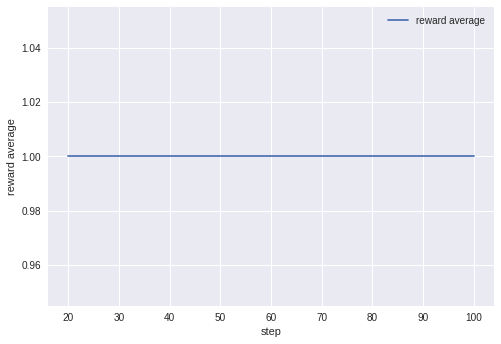

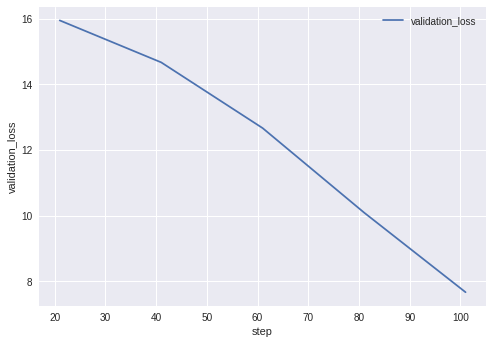

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-121
==== 121 ====
おはようございます。寒いですね。
    [0]ーござい気をつけて。。
    [1]ーござい気！つけて。。
さて帰ろう。明日は早い。
    [0]ーござい気をつけて。。
    [1]ーござい気をつけてて。
今回もよろしくです。
    [0]こちらこそよろしくお願いします。。
    [1]こちらこそよろしくお願いしし。。
avg_reply_len=13.0
validation loss=6.1
learning rate 0.05
msec/data=20.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-141
==== 141 ====
おはようございます。寒いですね。
    [0]おはようございます！つけて。。
    [1]おはようございますをつけて。。
さて帰ろう。明日は早い。
    [0]ー。気をつけて。。
    [1]ー。気をつけてて。
今回もよろしくです。
    [0]こちらこそよろしくお願いします。。
    [1]こちらこそよろしくお願いし。。。
avg_reply_len=13.7
validation loss=4.6
learning rate 0.05
msec/data=16.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-161
==== 161 ====
おはようございます。寒いですね。
    [0]おはようございます！    
    [1]おはようございます！つけ。。。
さて帰ろう。明日は早い。
    [0]ー。気をつけて。。
    [1]ー。気をつけてて。
今回もよろしくです。
    [0]こちらこ

こちらこそよろしくお願いします。
    [0]帰ろう。。 
    [1]帰ろも。。 
avg_reply_len=6.7
validation loss=14.0
learning rate 0.05
msec/data=15.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-61
==== 61 ====
@higepon おはようございます！
    [0]今回よろしくですです 
    [1]今回もですです 
おつかれさまー。気をつけて。
    [0]帰ろうよろしく。。 
    [1]帰ろうよろしくです。 
こちらこそよろしくお願いします。
    [0]帰ろうよろしくです。 
    [1]帰ろうよろしくですです 
avg_reply_len=10.7
validation loss=12.6
learning rate 0.05
msec/data=15.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-81
==== 81 ====
@higepon おはようございます！
    [0]今回ますですですです 
    [1]ございますですですです 
おつかれさまー。気をつけて。
    [0]帰ろうよろしくですは 
    [1]帰ろうよろしく明日は 
こちらこそよろしくお願いします。
    [0]帰ろうよろしくですです 
    [1]帰ろもよろしくですです 
avg_reply_len=11.3
validation loss=11.3
learning rate 0.05
msec/data=15.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-101
==== 101 

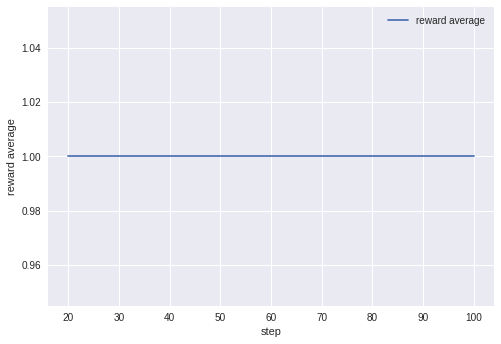

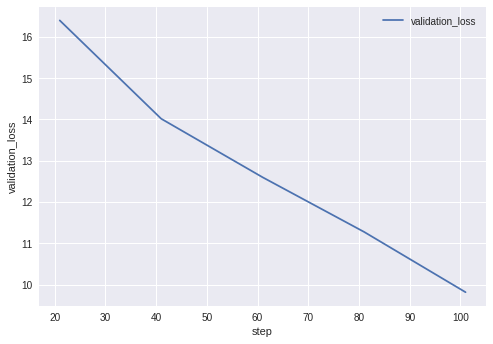

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-121
==== 121 ====
@higepon おはようございます！
    [0]ございます寒いですですね 
    [1]ございますですですですね 
おつかれさまー。気をつけて。
    [0]帰ろうよろしく明日は  
    [1]帰ろうよろしく明日は早い 
こちらこそよろしくお願いします。
    [0]今回もよろしくですです 
    [1]帰ろもよろしくですです 
avg_reply_len=12.3
validation loss=8.5
learning rate 0.05
msec/data=19.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-141
==== 141 ====
@higepon おはようございます！
    [0]ございます寒い寒いですね。。
    [1]ございます寒い寒いです。。。
おつかれさまー。気をつけて。
    [0]帰ろも。。。。。 
    [1]今回も。。。。。 
こちらこそよろしくお願いします。
    [0]今回も。ですです。 
    [1]今回も。です。。 
avg_reply_len=11.0
validation loss=7.3
learning rate 0.05
msec/data=16.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-161
==== 161 ====
@higepon おはようございます！
    [0]ございます寒い寒いですねね 
    [1]ございますます寒いですねね 
おつかれさまー。気をつけて。
    [0]帰ろうよろしく明日は早い  
  

In [15]:
import MeCab


def clean_model_path(model_path):
    shutil.rmtree(model_path)
    os.makedirs(model_path)


def print_header(text):
    print("============== {} ==============".format(text))




def test_tweets_small_swapped(hparams):
  replies = ["@higepon おはようございます！", "おつかれさまー。気をつけて。", "こちらこそよろしくお願いします。"]
  trainer = Trainer()
  trainer.train_seq2seq_swapped(hparams, "tweets_small.txt", replies)

# vocab size 変えたら動かなくなった
tweet_small_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        'batch_size': 6,  # of tweets should be dividable by batch_size
        'encoder_length': 8,
        'decoder_length': 8,
        'num_units': 256,
        'num_layers': 2,
        'vocab_size': 34,
        'embedding_size': 40,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 200,
        'model_path': p(ModelDirectory.tweet_small.value),
        'learning_rate': 0.05,
        'use_attention': True,
    })

tweet_small_swapped_hparams = copy.deepcopy(
    tweet_small_hparams).override_from_dict(
    {'model_path': p(ModelDirectory.tweet_small_swapped.value)})

if mode == Mode.Test:
    tweets_path = "tweets_small.txt"
    TrainDataGenerator(tweets_path, tweet_small_hparams).remove_generated()
    trainer = Trainer()
    trainer.train_seq2seq(tweet_small_hparams, tweets_path,
                         ["おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。"])
    test_tweets_small_swapped(tweet_small_swapped_hparams)

In [0]:
def test_tweets_large(hparams):
  tweets = ["さて福岡行ってきます！", "誰か飲みに行こう", "熱でてるけど、でもなんか食べなきゃーと思ってアイス買おうとしたの","今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]
  trainer = Trainer()
  trainer.train_seq2seq(hparams, "tweets_conversation.txt", tweets, should_clean_saved_model=False, drive=drive)


def test_tweets_large_swapped(hparams):
  tweets = [ "今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]
  trainer = Trainer()
  trainer.train_seq2seq_swapped(hparams, "tweets_large.txt", tweets, should_clean_saved_model=False, drive=drive)


tweet_large_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        # In typical seq2seq chatbot
        # num_layers=3, learning_rate=0.5, batch_size=64, vocab=20000-100000, learning_rate decay is 0.99, which is taken care as default parameter in AdamOptimizer.
        'batch_size': 64,  # of tweets should be dividable by batch_size
        'encoder_length': 30,
        'decoder_length': 30,
        'num_units': 1024,
        'num_layers': 3,
        'vocab_size': 100000,
        'embedding_size': 1024,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 1000000,
        'model_folder_in_drive': GoogleDriveFolder.seq2seq.value,
        'model_path': p(ModelDirectory.tweet_large.value),
        'learning_rate': 0.5, # For vocab_size 50000, num_layers 3, num_units 1024, tweet_large, starting learning_rate 0.05 works well, change it t0 0.01 at perplexity 800, changed it to 0.005 at 200.
        'learning_rate_decay': 0.99,
        'use_attention': True,
        # testing new restore learning rate and no USERNAME TOKEN
    })

tweet_large_swapped_hparams = copy.deepcopy(
    tweet_large_hparams).override_from_dict(
    {
        'model_folder_in_drive': GoogleDriveFolder.seq2seq_swapped.value,
        'model_path': p(ModelDirectory.tweet_large_swapped.value)
    })

if mode == Mode.TrainSeq2Seq:
    print("train seq2seq")
    print(tweet_large_hparams)
    test_tweets_large(tweet_large_hparams)
elif mode == Mode.TrainSeq2SeqSwapped:
    print("train seq2seq swapped")
    test_tweets_large_swapped(tweet_large_swapped_hparams)

In [0]:
rl_src_hparams = copy.deepcopy(tweet_large_hparams).override_from_dict({'beam_width': 0})
rl_dst_hparams = copy.deepcopy(rl_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps': 300000,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_large_rl.value),
})

tweets = ["さて福岡行ってきます！", "誰か飲みに行こう", "熱でてるけど、でもなんか食べなきゃーと思ってアイス買おうとしたの",
          "今日のドラマ面白そう！", "お腹すいたー", "おやすみ～", "おはようございます。寒いですね。",
          "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]

if mode == Mode.TrainRL:
    train_large_rl(rl_src_hparams,
                   rl_dst_hparams,
                   source_path="tweets_large.txt",
                   tweets=tweets,
                   drive=drive)
    

In [0]:
def download_logs(path):
  for f in absoluteFilePaths(path):
    if re.match('.*events', f):
      files.download(f)
      
def remove_saved_model(hparams):
  !mkdir -p $hparams.model_path
  !rm $hparams.model_path/*  
  
def copy_saved_model(src_hparams, dst_hparams):
  !cp $src_hparams.model_path/* $dst_hparams.model_path/
  # rm tf.logs from source so that it wouldn't be mixed in dest tf.logs.
  !rm $dst_hparams.model_path/events*
  
  
# This is designed to have small clean RL iterations many times.
def easy_train_rl_tweets(seq2seq_hparams, rl_src_hparams, rl_dst_hparams, tweets_path, validation_tweets, dull_responses):
  
  TrainDataGenerator(tweets_path, seq2seq_hparams).remove_generated()
  
  # train normal seq2seq.
  remove_saved_model(seq2seq_hparams)
  trainer = Trainer()
  trainer.train_seq2seq(seq2seq_hparams, tweets_path, validation_tweets)
  
  # Copy trained seq2seq as initial state of rl model.
  remove_saved_model(rl_dst_hparams)
  copy_saved_model(seq2seq_hparams, rl_dst_hparams)

  trainer = Trainer()
  trainer.train_rl_tweets(rl_src_hparams,   rl_dst_hparams, tweets_path, validation_tweets, dull_responses)

In [0]:
tweet_small_hparams = copy.deepcopy(
    tweet_small_hparams).override_from_dict(
    {'num_train_steps': 120,
      'decoder_length': 10,
      'encoder_length': 10
    })

rl_src_hparams = copy.deepcopy(tweet_small_hparams).override_from_dict({'beam_width': 0})
rl_dst_hparams = copy.deepcopy(rl_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps':1000,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_small_rl.value),
})

if mode == Mode.Test:  
  dull_responses = ['これ', "それ", "ありがとうございます", "おつかれ", "それなwww",
                            "おはよ(˙-˙)",
                            "おはよ！", "おはようございます！", "おつかれさまです"]
#  easy_train_rl_tweets(tweet_small_hparams,  rl_src_hparams, rl_dst_hparams, "tweets_small.txt", [ "おやすみ～", "おはようございます。寒いですね。", "今回もよろしくです。", "ばいとおわ！"], dull_responses)


In [0]:
if mode == Mode.Test:
  download_logs(ModelDirectory.tweet_small_rl.value)
  


===== Train Seq2Seq tweets_medium.txt ====
{'machine': 'master', 'batch_size': 64, 'num_units': 512, 'num_layers': 2, 'vocab_size': 5000, 'embedding_size': 256, 'learning_rate': 0.5, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 30, 'decoder_length': 30, 'max_gradient_norm': 5.0, 'beam_width': 2, 'num_train_steps': 3120, 'model_path': 'model/tweet_large'}
generating enc and dec files...
generating vocab file...
loading vocab...
generating id files...
generating padded input file...
generating dec eos/sos files...
done
!!!GPU ENABLED !!!
!!!GPU ENABLED !!!
Created fresh model.
...................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-21
==== 21 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩の
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩の
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩の
ばいと

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-61
==== 61 ====
おやすみ～
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩                             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩                             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=120.5
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-81
==== 81 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩

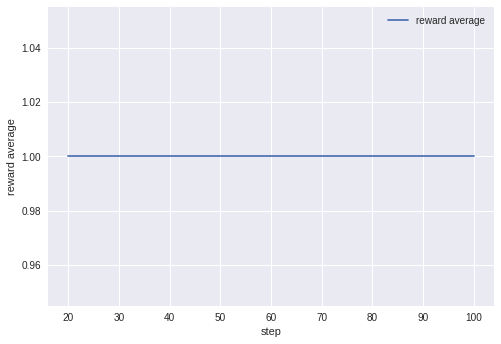

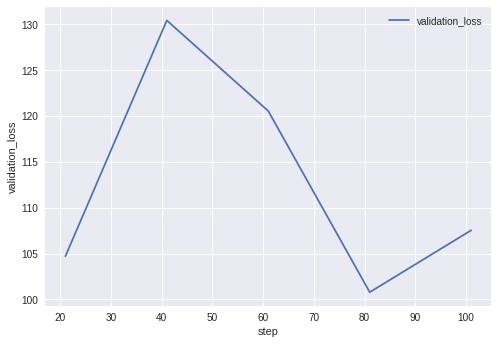

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-121
==== 121 ====
おやすみ～
    [0]  
    [1]は 
おはようございます。寒いですね。
    [0]結果は 
    [1]はは 
今回もよろしくです。
    [0]は 
    [1]💩 
ばいとおわ！
    [0]は 
    [1]💩 
avg_reply_len=2.5
validation loss=123.4
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-141
==== 141 ====
おやすみ～
    [0]  
    [1]💩 
おはようございます。寒いですね。
    [0]💩💩  
    [1]💩💩💩 
今回もよろしくです。
    [0]💩  
    [1]💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=3.0
validation loss=111.6
learning rate 0.5
msec/data=6.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-161
==== 161 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]結果💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-201
==== 201 ====
おやすみ～
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=117.1
learning rate 0.5
msec/data=7.0


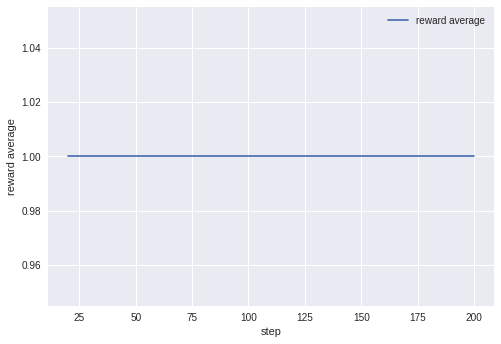

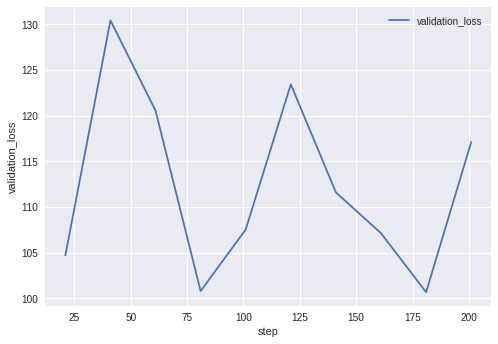

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-221
==== 221 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]結果💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=104.4
learning rate 0.5
msec/data=7.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-241
==== 241 ====
おやすみ～
    [0]💩                             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-281
==== 281 ====
おやすみ～
    [0]  
    [1]💩 
おはようございます。寒いですね。
    [0]💩  
    [1]💩💩 
今回もよろしくです。
    [0]  
    [1]💩 
ばいとおわ！
    [0]  
    [1]💩 
avg_reply_len=2.2
validation loss=105.2
learning rate 0.5
msec/data=6.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-301
==== 301 ====
おやすみ～
    [0]  
    [1]！ 
おはようございます。寒いですね。
    [0]！  
    [1]！！ 
今回もよろしくです。
    [0]！  
    [1]！！ 
ばいとおわ！
    [0]！  
    [1]！！ 
avg_reply_len=2.8
validation loss=106.0
learning rate 0.5
msec/data=6.0


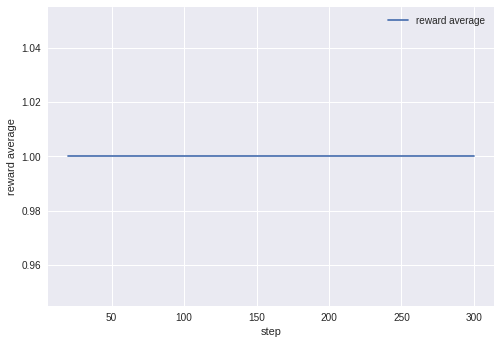

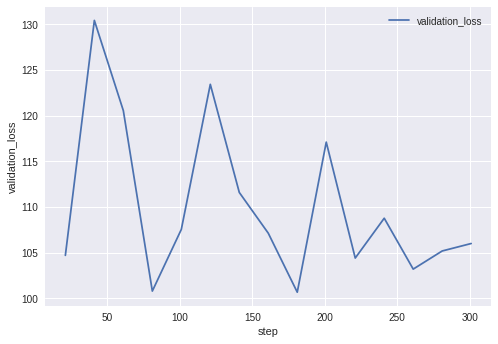

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-321
==== 321 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩て
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩！💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩て
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩て
avg_reply_len=30.0
validation loss=100.1
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-341
==== 341 ====
おやすみ～
    [0]  
    [1]💩 
おはようございます。寒いですね。
    [0]これ 
    [1]💩 
今回もよろしくです。
    [0]💩 
    [1]これ 
ばいとおわ！
    [0]💩 
    [1]これ 
avg_reply_len=2.2
validation loss=84.9
learning rate 0.5
msec/data=5.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-361
==== 361 ====


今回もよろしくです。
    [0]これ！  
    [1]これ！て 
ばいとおわ！
    [0]これ！  
    [1]これ！！ 
avg_reply_len=4.8
validation loss=111.9
learning rate 0.5
msec/data=6.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-401
==== 401 ====
おやすみ～
    [0]！  
    [1]！！ 
おはようございます。寒いですね。
    [0]あ！  
    [1]あ！！ 
今回もよろしくです。
    [0]それ！  
    [1]それ！！ 
ばいとおわ！
    [0]それ  
    [1]それ！ 
avg_reply_len=4.0
validation loss=91.0
learning rate 0.5
msec/data=6.0


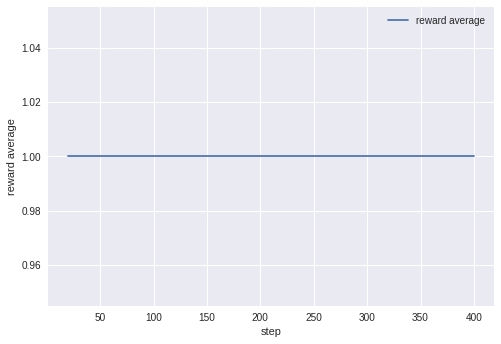

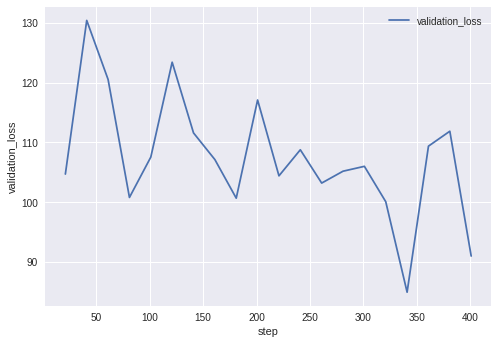

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-421
==== 421 ====
おやすみ～
    [0]   
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩💩       
    [1]💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩     
    [1]💩💩💩💩💩 
ばいとおわ！
    [0]💩    
    [1]💩💩💩💩 
avg_reply_len=5.8
validation loss=97.9
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-441
==== 441 ====
おやすみ～
    [0](！！wwwwww  
    [1](！！wwwwwwwww 
おはようございます。寒いですね。
    [0]あ！！！wwwwwwwwwwwwwwwwww)))))))))))))     
    [1]あ！！！wwwwwwwwwwwwwwwwww)))))))))))))！)！) 
今回もよろしくです。
    [0]あ！！！wwwwwwwwwwwwwww))))))))))))))   
    [1]あ！！！wwwwwwwwwwwwwww))))))))))))))！) 
ばいとおわ！
    [0]あ！！！！wwwwwwwww))))))))！！！！！！！！！！ 
    [1]それ！！！！wwwwwwwww))))))))！！！！！！！！！！ 
avg_reply_len=30.0
validation loss=84.2
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/Ch

..........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-501
==== 501 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩💩  
    [1]💩💩💩 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩💩 
ばいとおわ！
    [0]それ💩 
    [1]いや💩 
avg_reply_len=3.8
validation loss=85.3
learning rate 0.5
msec/data=6.0


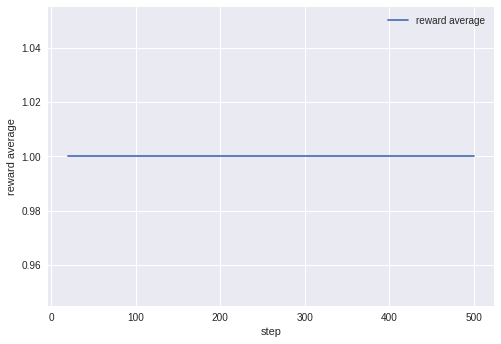

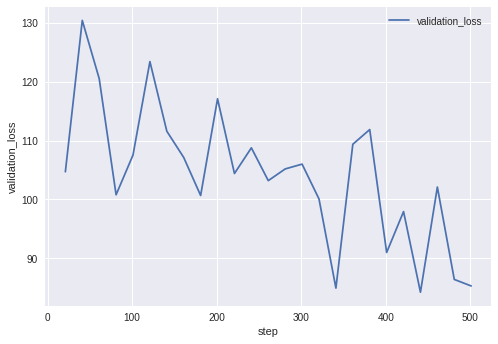

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-521
==== 521 ====
おやすみ～
    [0]💩💩💩💩  
    [1]💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩   
    [1]💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩  
    [1]💩💩💩💩💩💩💩💩💩 
avg_reply_len=13.2
validation loss=96.5
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-541
==== 541 ====
おやすみ～
    [0]💩   
    [1]💩💩💩 
おはようございます。寒いですね。
    [0]💩💩       
    [1]💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩     
    [1]💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩     
    [1]💩💩💩💩💩💩 
avg_reply_len=6.8
validation loss=94.7
learning rate 0.5
msec/data=6.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-561
==== 561 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩て
おはようございます。寒いですね。
 

...............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-601
==== 601 ====
おやすみ～
    [0]💩💩  
    [1]💩💩www 
おはようございます。寒いですね。
    [0]💩💩💩www  
    [1]💩💩💩wwwwww 
今回もよろしくです。
    [0]💩💩www  
    [1]💩💩wwwwww 
ばいとおわ！
    [0]💩💩www  
    [1]💩💩wwwwww 
avg_reply_len=6.5
validation loss=82.1
learning rate 0.5
msec/data=6.1


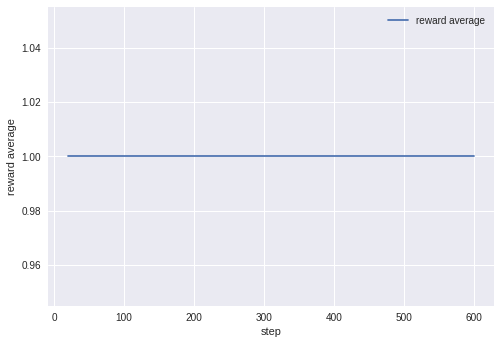

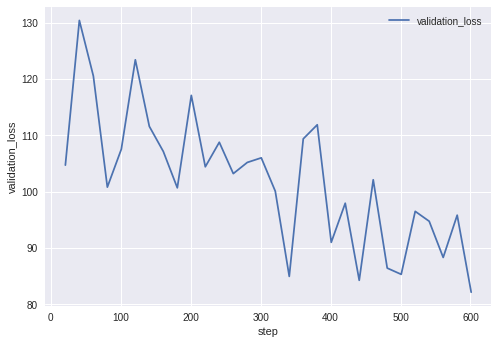

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-621
==== 621 ====
おやすみ～
    [0]これ  
    [1]これ！ 
おはようございます。寒いですね。
    [0]あ  
    [1]あの 
今回もよろしくです。
    [0]あ  
    [1]あの 
ばいとおわ！
    [0]あ  
    [1]あの 
avg_reply_len=3.2
validation loss=84.0
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-641
==== 641 ====
おやすみ～
    [0]これwww  
    [1]これwwwwww 
おはようございます。寒いですね。
    [0]これははwww 
    [1]これはのwww 
今回もよろしくです。
    [0]これのwww  
    [1]これのwww) 
ばいとおわ！
    [0]はいはwww 
    [1]あはwww 
avg_reply_len=7.5
validation loss=102.2
learning rate 0.5
msec/data=6.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-661
==== 661 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩www       
    [1]💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩       
    [1]💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=6.2
va

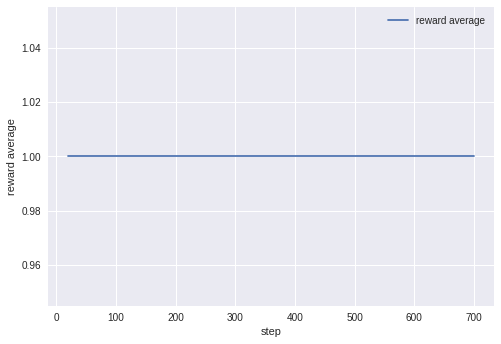

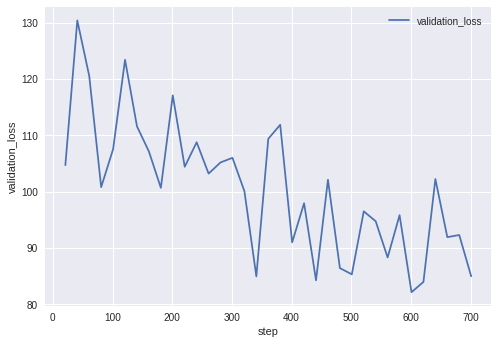

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-721
==== 721 ====
おやすみ～
    [0]💩💩www  
    [1]💩💩wwwwww 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。 
ばいとおわ！
    [0]💩💩www  
    [1]💩💩wwwwww 
avg_reply_len=18.0
validation loss=95.2
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-741
==== 741 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=102.0
learning rate 0.5
msec/data=6.9

==== 781 ====
おやすみ～
    [0]これた  
    [1]これたwww 
おはようございます。寒いですね。
    [0]それ、、www 
    [1]これ、、www 
今回もよろしくです。
    [0]これののwww  
    [1]これののwwwwww 
ばいとおわ！
    [0]これののののた  
    [1]これののののたた 
avg_reply_len=7.8
validation loss=75.1
learning rate 0.5
msec/data=6.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-801
==== 801 ====
おやすみ～
    [0]💩  
    [1]💩… 
おはようございます。寒いですね。
    [0]💩💩                   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩  
    [1]💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=7.5
validation loss=88.8
learning rate 0.5
msec/data=6.2


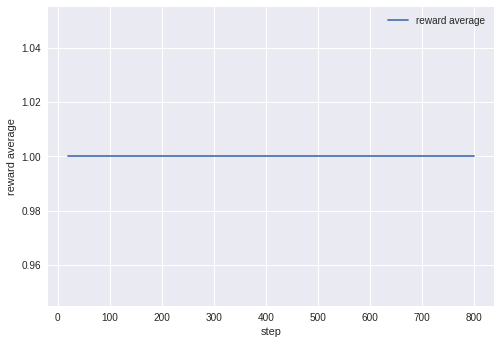

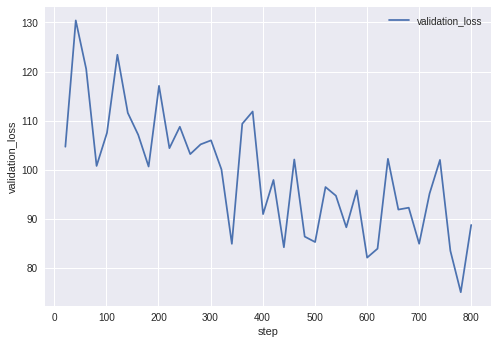

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-821
==== 821 ====
おやすみ～
    [0]💩た  
    [1]💩たwww 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩www                   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=23.8
validation loss=101.0
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-841
==== 841 ====
おやすみ～
    [0]💩💩www                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩www                      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩www                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩！  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=31.5
vali

今回もよろしくです。
    [0]え、、、、、、、、、、、、、、、、、、、、、、、、、、…  
    [1]え、、、、、、、、、、、、、、、、、、、、、、、、、、…… 
ばいとおわ！
    [0]え！                            
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=24.2
validation loss=94.4
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-901
==== 901 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=25.5
validation loss=93.2
learning rate 0.5
msec/data=6.7


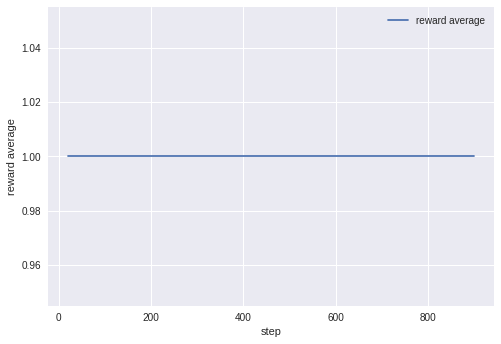

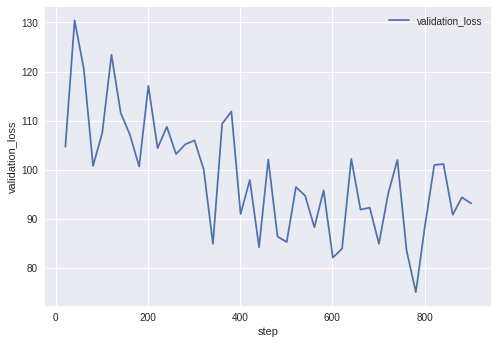

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-921
==== 921 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=26.2
validation loss=85.5
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-941
==== 941 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-981
==== 981 ====
おやすみ～
    [0]💩💩💩💩💩💩💩  
    [1]💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]！                             
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=16.0
validation loss=90.2
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1001
==== 1001 ====
おやすみ～
    [0]💩www  
    [1]💩、💩 
おはようございます。寒いですね。
    [0]💩💩💩  
    [1]💩💩💩💩 
今回もよろしくです。
    [0]💩💩  
    [1]💩の💩 
ばいとおわ！
    [0]！                             
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=11.2
validation loss=87.7
learning rate 0.5
msec/data=6.2


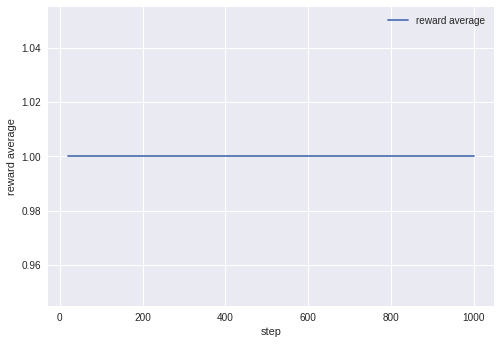

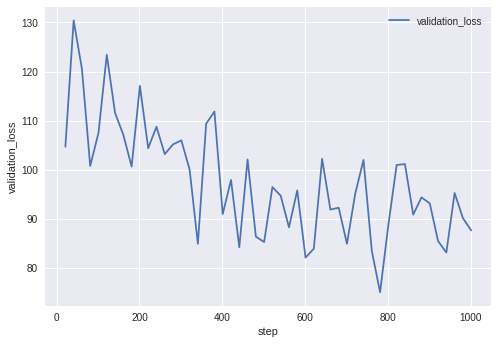

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1021
==== 1021 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=90.4
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1041
==== 1041 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩         
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩         
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1081
==== 1081 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=93.9
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1101
==== 1101 ====
おやすみ～
    [0]💩💩💩💩💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩www                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩www                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    [1]💩！！！！！！！！！！！！！！

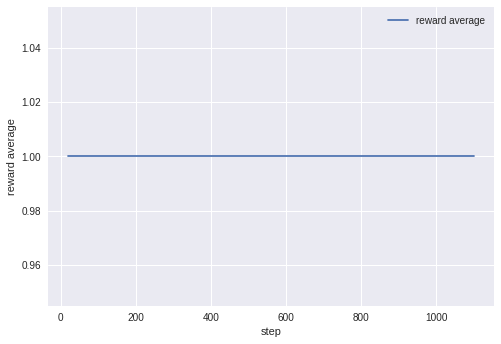

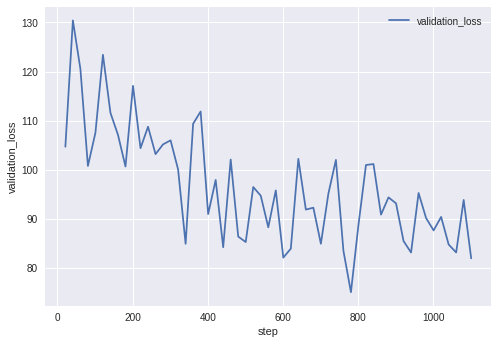

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1121
==== 1121 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=70.0
learning rate 0.5
msec/data=7.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1141
==== 1141 ====
おやすみ～
    [0]これてない      
    [1]これてない(˙-˙) 
おはようございます。寒いですね。
    [0](˙ω˙) 
    [1](˙-˙) 
今回もよろしくです。
    [0]💩の💩💩  
    [1]💩の💩💩💩 
ばいとおわ！
    [0]💩💩    
    [1]💩💩💩💩💩 
avg_reply_len=7.2
validation loss=84.8
learning rate 0.5
msec/data=6.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/t

おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=30.0
validation loss=85.6
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1201
==== 1201 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]！！！！！！！                       
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=28.2
validation loss=72.0
learning rate 0.5
msec/data=6.9


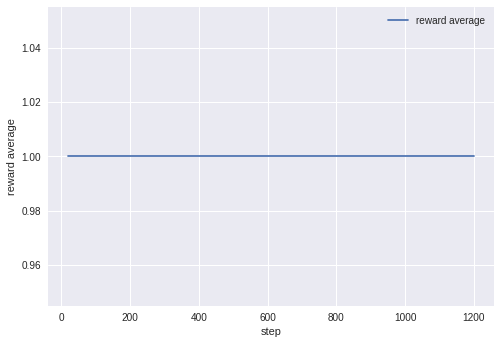

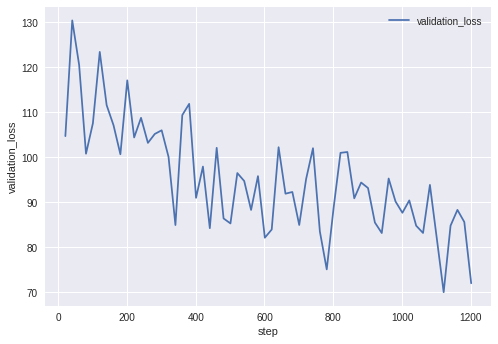

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1221
==== 1221 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=66.7
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1241
==== 1241 ====
おやすみ～
    [0]💩の💩💩💩💩💩💩💩   
    [1]💩の💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩     
    [1]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩 
ばいとおわ！
    [0]                              
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=24.2
val

..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1281
==== 1281 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]それは💩の💩の💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩   
    [1]それは💩の💩の💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩        
    [1]💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=29.2
validation loss=91.0
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1301
==== 1301 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]                      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=

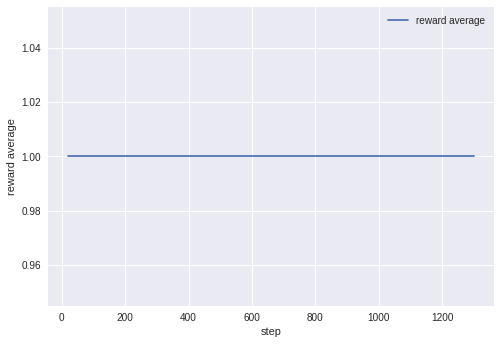

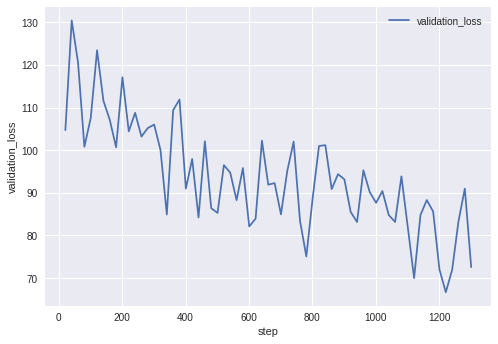

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1321
==== 1321 ====
おやすみ～
    [0]これ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
おはようございます。寒いですね。
    [0]これだよwww     
    [1]これだよ(˘ω˘) 
今回もよろしくです。
    [0]これ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]これ、、、、、、、、、、、、、、、、、、、、、、、、、、、、。
ばいとおわ！
    [0]！                             
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=26.0
validation loss=86.6
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1341
==== 1341 ====
おやすみ～
    [0]💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩                             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩！       
    [1]💩💩💩💩💩💩💩💩 
avg_reply_len=24.5
validation loss=91.4
learning rate 

今回もよろしくです。
    [0]あ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]あ、、、、、、、、、、、、、、、、、、、、、、、、、、、、💩
ばいとおわ！
    [0]💩の💩の💩の💩の💩の💩の💩💩💩💩💩             
    [1]💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.2
validation loss=82.4
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1401
==== 1401 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
おはようございます。寒いですね。
    [0]💩は💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]それは💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩は💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
avg_reply_len=30.0
validation loss=83.9
learning rate 0.5
msec/data=6.9


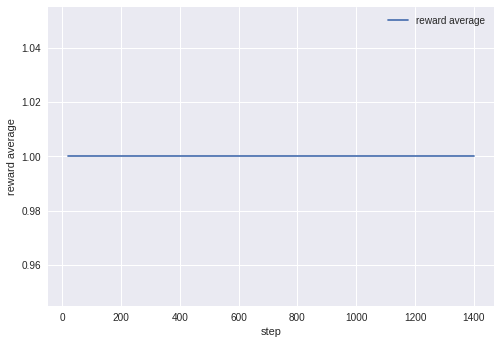

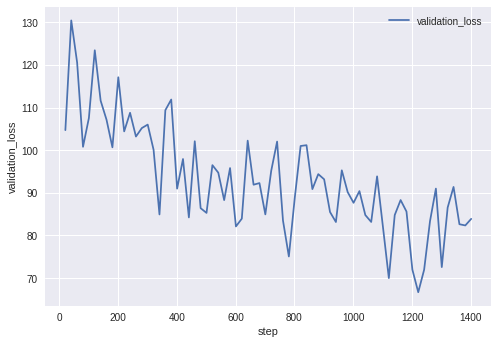

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1421
==== 1421 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩www               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩   
    [1]💩💩💩 
ばいとおわ！
    [0]💩！                            
    [1]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=14.0
validation loss=78.4
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1441
==== 1441 ====
おやすみ～
    [0]💩   
    [1]💩の💩 
おはようございます。寒いですね。
    [0]💩www  
    [1]💩💩💩 
今回もよろしくです。
    [0]💩！                            
    [1]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]💩  
    [1]💩！ 
avg_reply_len=10.8
validation loss=81.4
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1461
==== 1461 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1501
==== 1501 ====
おやすみ～
    [0]え！www                           
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]それだよ(˙-˙)                      
    [1]それだよ(˙-˙)！！！！！！！！！！！！！！！！！！！！！！
今回もよろしくです。
    [0]あ！www                           
    [1]あ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    [1]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！笑
avg_reply_len=31.2
validation loss=84.9
learning rate 0.5
msec/data=6.9


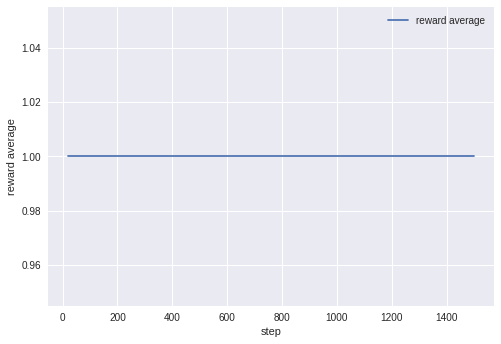

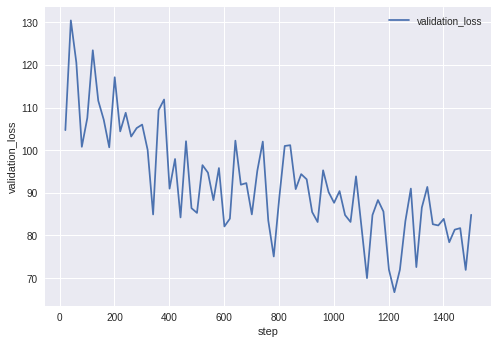

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1521
==== 1521 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]それはそれ、、、、、、、、、、、、、、、、、、、、、    
    [1]それはそれ、、、、、、、、、、、、、、、、、、、、、、、、 
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=72.8
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1541
==== 1541 ====
おやすみ～
    [0]💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]それ、💩、💩(˘ω˘)                    
    [1]それ、💩、💩(˘ω˘ω˘ω˘ω˘ω˘ω˘ω˘ω˘ω˘ω˘ω˘ω
今回もよろしくです。
    [0]💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩(
ばいとおわ！
    [0]💩！！                           
    [1]💩！！！！

.reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1581
==== 1581 ====
おやすみ～
    [0]💩💩  
    [1]💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩  
    [1]💩💩💩 
avg_reply_len=12.5
validation loss=86.6
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1601
==== 1601 ====
おやすみ～
    [0]、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]、、、、、、、、、、、、、、、、、、、、、、、、、、、、、 
おはようございます。寒いですね。
    [0]💩💩💩💩(˘ω˘)   
    [1]💩💩💩💩(˘ω˘ω˘) 
今回もよろしくです。
    [0]💩に💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]ありがとうございます！                          
    [1]ありがとうございます！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=27.2
validation loss=84.5
learning rate 0.5
msec/data=6.7


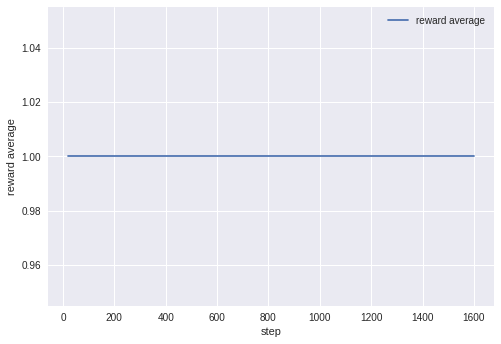

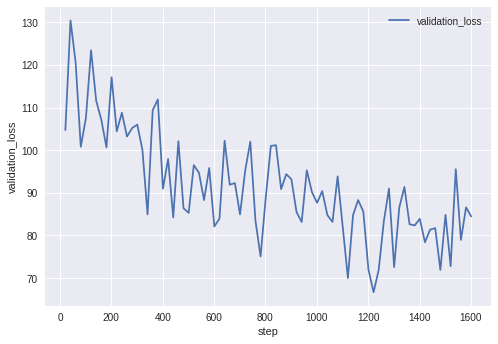

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1621
==== 1621 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=75.8
learning rate 0.5
msec/data=7.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1641
==== 1641 ====
おやすみ～
    [0]え、、、、、、、、、、、、、、、、、、、、、、、、、   
    [1]え、、、、、、、、、、、、、、、、、、、、、、、、、、、 
おはようございます。寒いですね。
    [0]💩だwww      
    [1]💩だよ(˙-˙) 
今回もよろしくです。
    [0]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩💩。      
    [1]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩に💩ます。                      
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=24.0
validati

INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1681
==== 1681 ====
おやすみ～
    [0]いいですwww  
    [1]いいですね！ 
おはようございます。寒いですね。
    [0]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]それは、、、、、、、、、、、、、、、、、、、、、、、、、、、、
今回もよろしくです。
    [0]                              
    [1]あ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
ばいとおわ！
    [0]💩の💩                           
    [1]💩の💩の、、、、、、、、、、、、、、、、、、、、、、、、、、
avg_reply_len=25.0
validation loss=84.4
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1701
==== 1701 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩)  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩) 
今回もよろしくです。
    [0]💩💩💩💩💩💩                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=26.8
validation loss=70.6
learning rate 0.5
msec/data=6.8


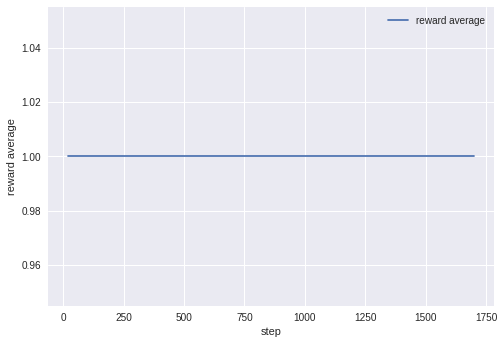

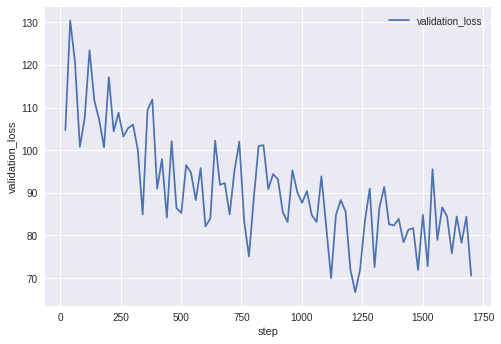

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1721
==== 1721 ====
おやすみ～
    [0]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、💩
おはようございます。寒いですね。
    [0]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、💩
今回もよろしくです。
    [0]💩の💩💩💩💩💩💩💩💩💩💩💩💩                
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.5
validation loss=73.6
learning rate 0.5
msec/data=7.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1741
==== 1741 ====
おやすみ～
    [0](´^ω^｀)ﾌﾞﾌｫwww  
    [1](´^ω^｀)ﾌﾞﾌｫwwwwww 
おはようございます。寒いですね。
    [0]それ、、、、、、、、、、、、、、、、、、、、、、、  
    [1]それ、、、、、、、、、、、、、、、、、、、、、、、、 
今回もよろしくです。
    [0]                            
    [1]💩の💩の💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=18.5
validation loss=78.3
learning rate 0.5
msec

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1801
==== 1801 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩💩            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩  
    [1]💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=5.8
validation loss=60.9
learning rate 0.5
msec/data=6.1


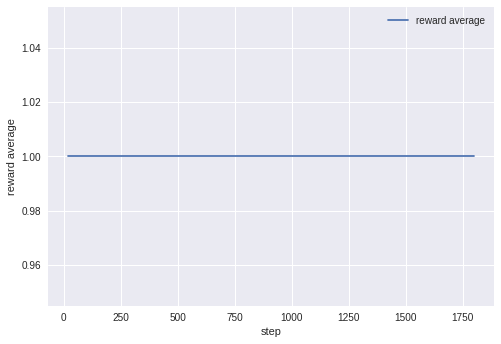

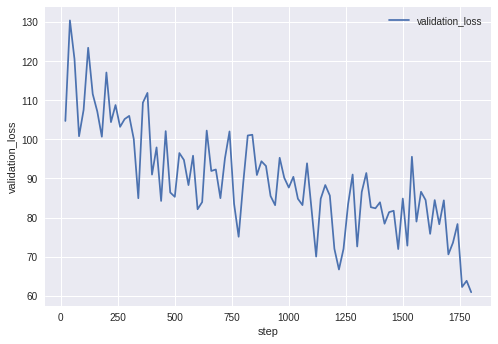

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1821
==== 1821 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩は💩は💩は💩💩💩💩💩💩💩💩💩💩💩  
    [1]💩は💩は💩は💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]  
    [1]💩 
ばいとおわ！
    [0]  
    [1]💩 
avg_reply_len=6.5
validation loss=72.3
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1841
==== 1841 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩💩💩)
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩)💩💩)💩)  
    [1]💩💩💩💩💩💩💩💩💩)💩💩)💩)💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩)💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩)💩💩💩💩💩)💩💩💩💩)💩💩💩💩)
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩.💩
avg_reply_len=26.8
validation loss=79.5
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1861
===

...............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1901
==== 1901 ====
おやすみ～
    [0]かわいい                             
    [1]かわいいよね！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]💩は💩は💩💩💩💩💩💩💩💩ね  
    [1]💩は💩は💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩の💩の💩を💩てます。 
    [1]💩の💩の💩を💩てますね 
ばいとおわ！
    [0]💩！                      
    [1]💩の💩💩💩を💩を💩を💩を💩を💩を💩を💩を💩を。 
avg_reply_len=21.0
validation loss=67.8
learning rate 0.5
msec/data=6.5


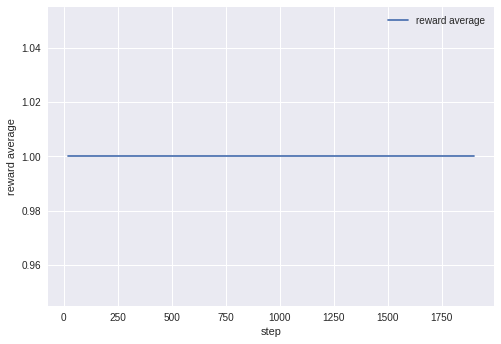

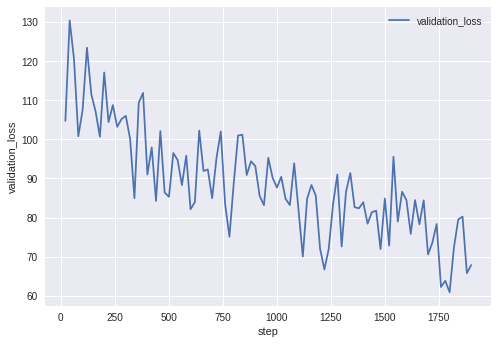

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1921
==== 1921 ====
おやすみ～
    [0]かわいい                             
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
おはようございます。寒いですね。
    [0]これは(˙-˙) 
    [1]これは(˘ω˘) 
今回もよろしくです。
    [0]あ！！！！！                        
    [1]あ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    [1]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！  
avg_reply_len=25.5
validation loss=75.2
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1941
==== 1941 ====
おやすみ～
    [0]💩      
    [1]💩に💩てないwww 
おはようございます。寒いですね。
    [0]💩はははは、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]💩はははは、、、、、、、、、、、、、、、、、、、、、、、、は
今回もよろしくです。
    [0]あ、、、、、、、、、、、                  
    [1]あ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=17.5
validation loss=67.9
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.I

...........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2001
==== 2001 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩(˙-˙)                        
    [1]💩(˙-˙)💩、💩、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩！                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=20.5
validation loss=74.3
learning rate 0.5
msec/data=6.5


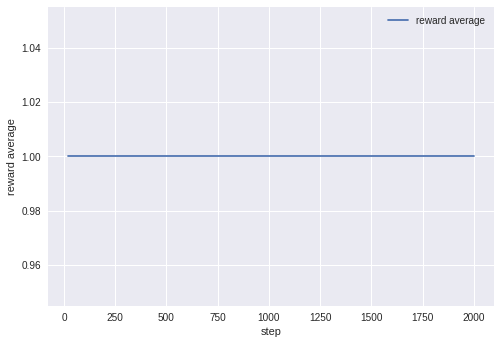

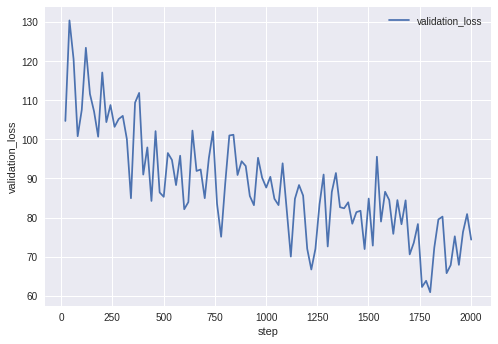

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2021
==== 2021 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩(˙-˙)   
    [1]💩(˙-˙)💩) 
今回もよろしくです。
    [0]💩                            
    [1]💩、💩の💩を💩を💩を💩を💩を💩を💩を💩を💩を💩を💩をてた 
ばいとおわ！
    [0]💩  
    [1]💩！ 
avg_reply_len=11.0
validation loss=73.3
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2041
==== 2041 ====
おやすみ～
    [0]💩www                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩の💩は💩を💩を💩を💩てた💩。              
    [1]💩の💩は💩を💩を💩を💩てた💩。💩に💩て💩て💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.2
validation loss=88.1
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Re

今回もよろしくです。
    [0]こちらは💩💩💩💩💩💩   
    [1]こちらは💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩                            
    [1]こちらですよ！！！！！！！！！！？？？？？？？？？？？？？？？？？
avg_reply_len=26.8
validation loss=63.5
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2101
==== 2101 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩(˙-˙)                       
    [1]💩💩(˙-˙)なんか💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=71.8
learning rate 0.5
msec/data=6.8


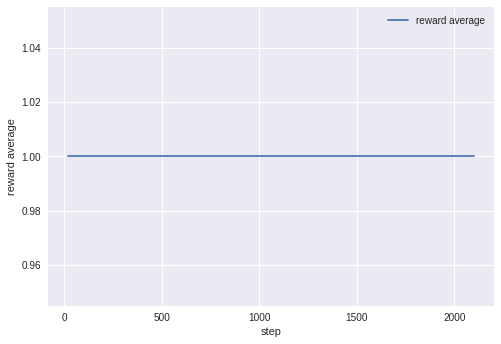

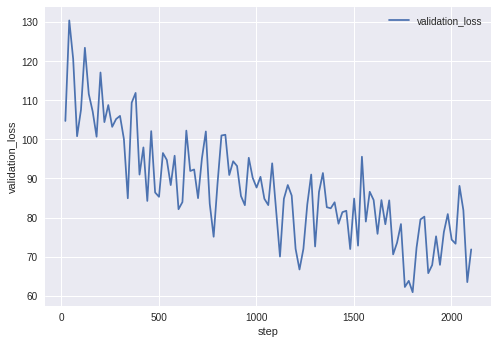

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2121
==== 2121 ====
おやすみ～
    [0]ほんとやったwww      
    [1]ほんとやったよ(॑꒳॑*) 
おはようございます。寒いですね。
    [0]それはこれ💩💩💩💩💩💩)  
    [1]それは💩💩💩💩💩💩💩💩) 
今回もよろしくです。
    [0]💩💩                
    [1]💩の💩の💩の💩を💩てましたよ(¨̮) 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=12.5
validation loss=77.3
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2141
==== 2141 ====
おやすみ～
    [0]ありがとー！！！                         
    [1]ありがとー！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]それはこれ…                          
    [1]それはこれ………………………………………………………………………
今回もよろしくです。
    [0]                           
    [1]💩の💩ののののののののののののののののののををている。 
ばいとおわ！
    [0]💩   
    [1]💩💩💩 
avg_reply_len=24.0
validation loss=74.5
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_

................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2201
==== 2201 ====
おやすみ～
    [0]いやwww   
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]💩(˙-˙)       
    [1]💩(˙-˙)💩(˙-˙) 
今回もよろしくです。
    [0]あ！！！！！！！！！！！！？？？？？？？？？？？？？？？？？
    [1]あ！！！！！！！！！！！！？？？？？？？？？？？？？？？？(
ばいとおわ！
    [0]💩！                           
    [1]💩！！！！！！💩💩の💩の💩の💩の💩ののの💩の💩の💩の💩。 
avg_reply_len=20.0
validation loss=60.7
learning rate 0.5
msec/data=6.5


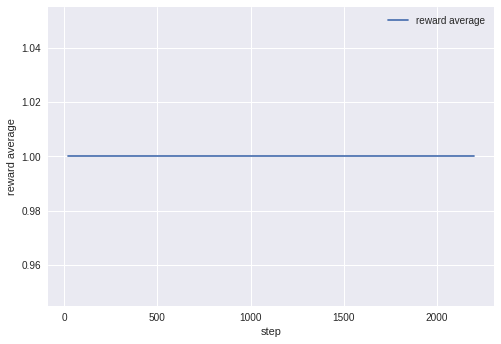

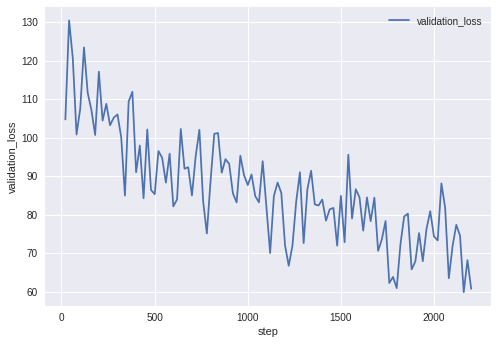

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2221
==== 2221 ====
おやすみ～
    [0]ちったwww   
    [1]ちってみたwww 
おはようございます。寒いですね。
    [0]それ、、、、、、、、、、、、、、、、、、、、、、、、)    
    [1]それ、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
今回もよろしくです。
    [0]いえいえ！                            
    [1]いえいえ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]💩！ 
    [1]💩  
avg_reply_len=19.0
validation loss=76.1
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2241
==== 2241 ====
おやすみ～
    [0]ほらwww               
    [1]いや、これの💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]それはこれは💩なよ(˙-˙)   
    [1]それはこれは💩なよ(͡°͜ʖ͡°) 
今回もよろしくです。
    [0]💩、💩💩💩💩💩    
    [1]💩、💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩www 
avg_reply_len=12.8
validation loss=81.4
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2261
==== 2261 ==

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2301
==== 2301 ====
おやすみ～
    [0]いや待て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]いや待て💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
おはようございます。寒いですね。
    [0]💩(˙-˙) 
    [1]💩(ﾟ)   
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩！                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=24.8
validation loss=63.0
learning rate 0.5
msec/data=6.6


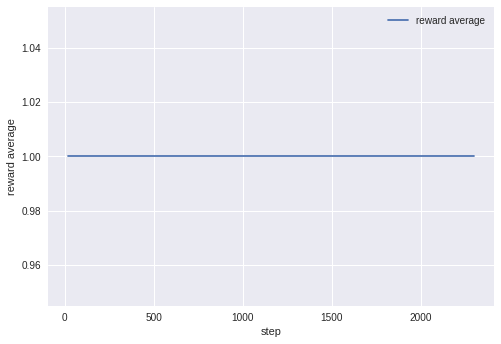

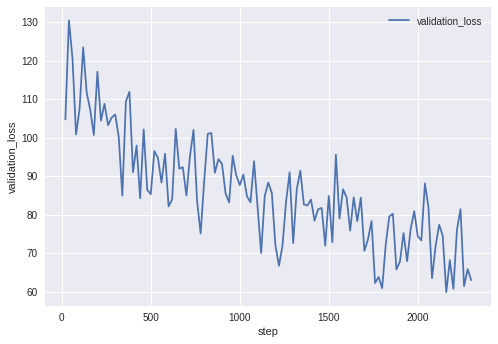

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2321
==== 2321 ====
おやすみ～
    [0]え、💩                           
    [1]え、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩(˙-˙)                        
    [1]💩(˙-˙)💩、、💩、いい、いいだ、、、、、、、、、、、、、でで
今回もよろしくです。
    [0]いえいえ 
    [1]ほれ 
ばいとおわ！
    [0]💩！  
    [1]お💩💩 
avg_reply_len=17.2
validation loss=57.9
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2341
==== 2341 ====
おやすみ～
    [0]やばwww  
    [1]やばよwww 
おはようございます。寒いですね。
    [0]💩(˙-˙)                        
    [1]💩(˙-˙)💩のががあるのな💩が💩💩💩💩💩💩💩💩💩💩💩-ﾟ˘ω
今回もよろしくです。
    [0]💩の💩💩💩     
    [1]💩の💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩！  
    [1]💩！！ 
avg_reply_len=12.8
validation loss=77.0
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2361
==== 2361 ====
おやすみ～
    [0

.......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2401
==== 2401 ====
おやすみ～
    [0]FF..                    
    [1]FF..................... 
おはようございます。寒いですね。
    [0]知らない(˙-˙) 
    [1]知らない(˘ω˘) 
今回もよろしくです。
    [0]こちらけけけありがとうございましたwww  
    [1]こちらけけけありがとうございしましたwww 
ばいとおわ！
    [0]💩  
    [1]💩！ 
avg_reply_len=14.8
validation loss=56.6
learning rate 0.5
msec/data=6.2


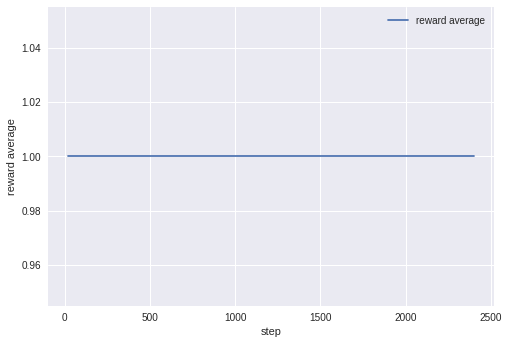

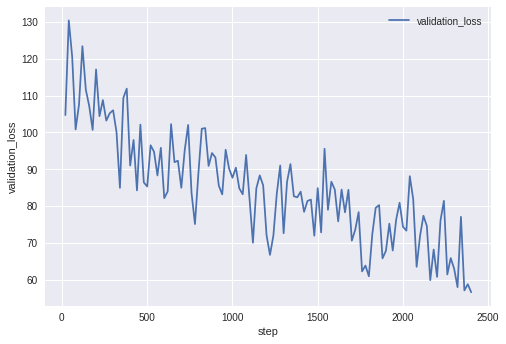

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2421
==== 2421 ====
おやすみ～
    [0]待ってるよ！  
    [1]待ってるよ！！ 
おはようございます。寒いですね。
    [0]💩(˙-˙) 
    [1]それ、💩…   
今回もよろしくです。
    [0]いえいえ！ 
    [1]いえいえ  
ばいとおわ！
    [0]💩！  
    [1]💩！！ 
avg_reply_len=6.2
validation loss=59.5
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2441
==== 2441 ====
おやすみ～
    [0]ほらwww   
    [1]ほんとだよwww 
おはようございます。寒いですね。
    [0]💩(˙-˙)      
    [1]💩(˙-˙)(˙-˙) 
今回もよろしくです。
    [0]いえいえ  
    [1]いえいえwww 
ばいとおわ！
    [0]おございました！！                        
    [1]おございました！！！！！！！！！！！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=14.8
validation loss=75.7
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2461
==== 2461 ====
おやすみ～
    [0]ほらwww 
    [1]ほら💩 
おはようございます。寒いですね。
    [0]💩(˙-˙)                    

==== 2501 ====
おやすみ～
    [0]ふふふ(*॑꒳॑*) 
    [1]ふふふ(*॑॑*) 
おはようございます。寒いですね。
    [0]💩(˙-˙)    
    [1]💩💩💩💩💩💩💩ﾟ) 
今回もよろしくです。
    [0]これこそ  
    [1]これこそほら 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=7.5
validation loss=61.3
learning rate 0.5
msec/data=6.0


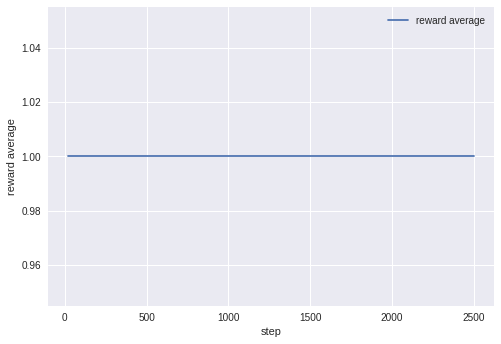

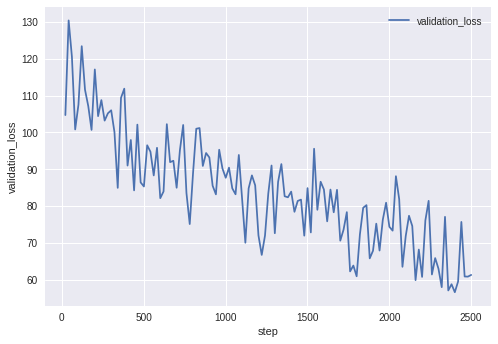

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2521
==== 2521 ====
おやすみ～
    [0]えかわいい                     
    [1]えかわいい💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩…                         
    [1]💩💩💩💩💩💩ﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟ((ﾟﾟﾟﾟﾟﾟ 
今回もよろしくです。
    [0]いえいえ                       
    [1]いえいえ、💩、💩、、、、、、、、、」」」」」」」」」 
ばいとおわ！
    [0]ご💩！    
    [1]おございます！！！ 
avg_reply_len=22.0
validation loss=53.0
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2541
==== 2541 ====
おやすみ～
    [0]えかわいい 
    [1]えほら 
おはようございます。寒いですね。
    [0]これ…                            
    [1]💩……………………………………………………………………………
今回もよろしくです。
    [0]これこそ  
    [1]💩💩」 
ばいとおわ！
    [0]💩                      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=16.5
validation loss=58.7
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters fro

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2601
==== 2601 ====
おやすみ～
    [0]かわいい(*॑꒳॑*) 
    [1]かわいい(*॑॑*) 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩ﾟﾟﾟ)              
    [1]💩💩💩💩💩💩ﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟ)←← 
今回もよろしくです。
    [0]はい💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]いえいえ💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩！                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=24.2
validation loss=45.2
learning rate 0.5
msec/data=6.7


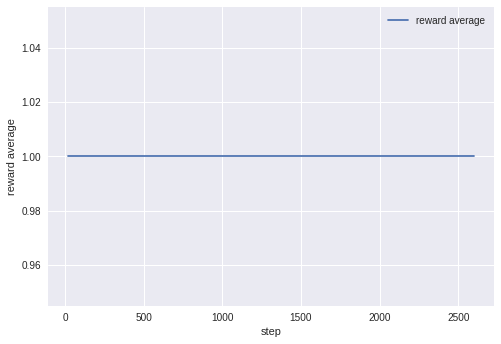

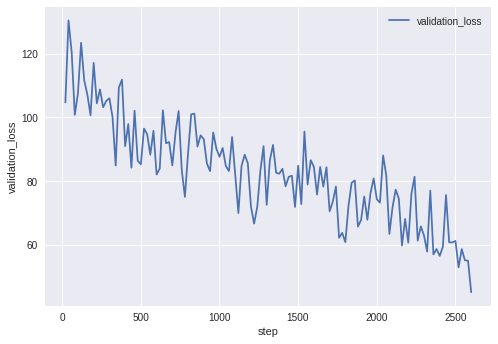

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2621
==== 2621 ====
おやすみ～
    [0]ほらwww          
    [1]ほら(..;...... 
おはようございます。寒いですね。
    [0]えー、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]えー、、、、、、、、、、、、、、、、、、、、、、、、、、、、これ
今回もよろしくです。
    [0]逆うね(ˇωˇ)                      
    [1]逆うね(ˇωˇ)💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩！     
    [1]おございます！！！ 
avg_reply_len=20.8
validation loss=78.7
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2641
==== 2641 ====
おやすみ～
    [0]かわいい(*॑꒳॑*)                        
    [1]ほら(.....................💩てますから、💩💩
おはようございます。寒いですね。
    [0]💩(˙-˙)  
    [1]💩💩(˙-˙) 
今回もよろしくです。
    [0]いえいえ、こちらこそ！！          
    [1]いえいえ、こちらこそ！！！💩💩ちゃん色💩たし！ 
ばいとおわ！
    [0]💩！     
    [1]おございます！！！ 
avg_reply_len=18.0
validation loss=45.9
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring param

.........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2701
==== 2701 ====
おやすみ～
    [0]ほら(^ω^)  
    [1]ほら(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おはようございます。寒いですね。
    [0]えーこれです…                          
    [1]えーこれです……………………………………うち………………………………
今回もよろしくです。
    [0]はい(ˇωˇ)                 
    [1]はい(ˇωˇ)このこの上を💩に💩してるんんです・・・・ 
ばいとおわ！
    [0]💩！                            
    [1]💩！💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=24.0
validation loss=53.8
learning rate 0.5
msec/data=6.7


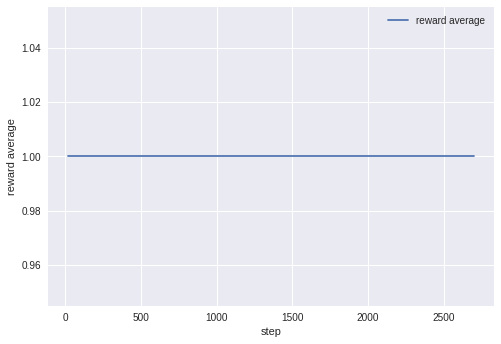

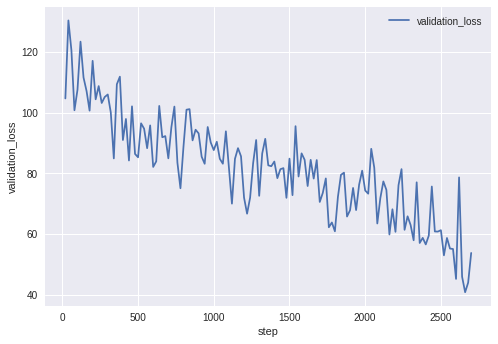

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2721
==== 2721 ====
おやすみ～
    [0]ほら                
    [1]もぉ💩に💩てるのが💩に💩ます(˘ω`‹) 
おはようございます。寒いですね。
    [0]💩(˙-˙)                        
    [1]💩(˙-˙)💩のかなか？？？？？？？？？？？？？？？？？(ﾟ
今回もよろしくです。
    [0]あ？             
    [1]あ、💩を💩にしましたよ(¨̮) 
ばいとおわ！
    [0]💩！ 
    [1]💩  
avg_reply_len=16.5
validation loss=49.8
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2741
==== 2741 ====
おやすみ～
    [0]ほらwww          
    [1]もぉ💩💩すぎてみてくるの💩♪ 
おはようございます。寒いですね。
    [0]えー、覚えて💩💩💩˘ω˘)  
    [1]えー、覚えて💩💩💩💩˘ω˘) 
今回もよろしくです。
    [0]いえいえ  
    [1]ほら！ 
ばいとおわ！
    [0]おございます！  
    [1]おございます！！ 
avg_reply_len=11.2
validation loss=36.5
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2761
==== 2761 ====
おやすみ～
    [0]ほら(*.💩)  
    [1

.reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2801
==== 2801 ====
おやすみ～
    [0]ほらwww 
    [1]ほら💩 
おはようございます。寒いですね。
    [0]💩💩…💩💩…………………………………………………………………
    [1]💩💩…💩💩………………………………………………………………(
今回もよろしくです。
    [0]ほら(˙-˙)  
    [1]ほら(••••) 
ばいとおわ！
    [0]💩！ 
    [1]💩  
avg_reply_len=12.0
validation loss=40.1
learning rate 0.5
msec/data=6.2


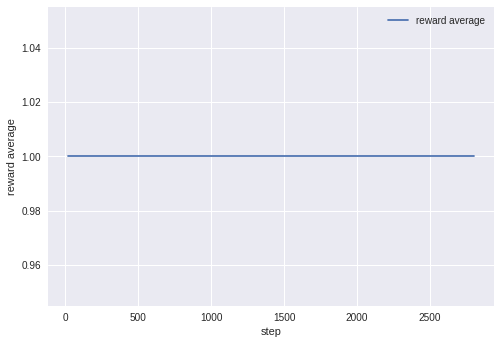

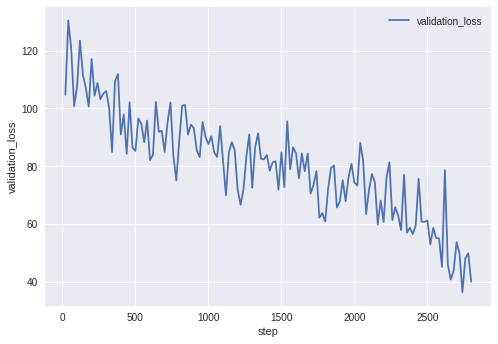

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2821
==== 2821 ====
おやすみ～
    [0]ほら  
    [1]ほらwww 
おはようございます。寒いですね。
    [0]えーこれです💩 
    [1]えーこれです… 
今回もよろしくです。
    [0]ほら！               
    [1]ほら！！！！！💩それ、それ、それなんなwww 
ばいとおわ！
    [0]💩  
    [1]💩！ 
avg_reply_len=8.2
validation loss=65.2
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2841
==== 2841 ====
おやすみ～
    [0]ほらwww 
    [1]ほら  
おはようございます。寒いですね。
    [0]💩💩…………………………………………………………………………
    [1]💩💩…………………………………………うち……………………………
今回もよろしくです。
    [0]あ、もう、自由に💩ましたwww                    
    [1]あ、もう、自由に💩………………………………ｗｗｗｗｗｗｗｗｗｗｗ
ばいとおわ！
    [0]💩！               
    [1]💩💩💩に💩💩にしますしておりました〜✨ 
avg_reply_len=22.0
validation loss=49.8
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2861
==== 2861 ====
おやすみ～


..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2901
==== 2901 ====
おやすみ～
    [0]ほらwww       
    [1]もぉ人でつけて、、、 
おはようございます。寒いですね。
    [0]えーwww                            
    [1]えー、、、これ…………………………………………………………………
今回もよろしくです。
    [0]ほら、今日こそけも💩やったらやったら💩だわwww              
    [1]ほら、今日こそけも💩やったら💩だけど、、、、、、、、、、、、、、、、 
ばいとおわ！
    [0]お💩！ 
    [1]おか！ 
avg_reply_len=21.8
validation loss=38.4
learning rate 0.5
msec/data=6.4


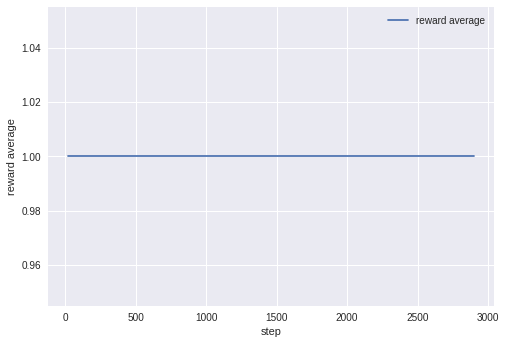

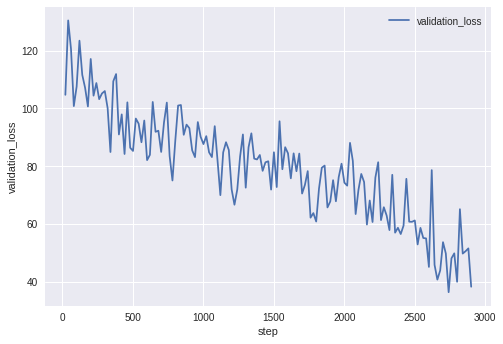

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2921
==== 2921 ====
おやすみ～
    [0]ほら💩         
    [1]ほら(*......とか… 
おはようございます。寒いですね。
    [0]💩(˙-˙) 
    [1]💩('-')   
今回もよろしくです。
    [0]いえいえ  
    [1]いえいえ！ 
ばいとおわ！
    [0]💩！  
    [1]お💩！ 
avg_reply_len=7.2
validation loss=64.3
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2941
==== 2941 ====
おやすみ～
    [0]ほら💩                            
    [1]ほら💩💩💩💩💩💩💩💩.....................
おはようございます。寒いですね。
    [0]💩(˙-˙) 
    [1]💩(´•ωﾟ) 
今回もよろしくです。
    [0]いえいえー️💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]いえいえー️💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩.💩
ばいとおわ！
    [0]💩！          
    [1]おございます🙇ーーーものですか？ 
avg_reply_len=20.8
validation loss=38.7
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2961
==== 2961 ====
おやすみ～
    [0]ほら(*॑꒳॑

INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3001
==== 3001 ====
おやすみ～
    [0]ほら💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
    [1]ほら💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]こんな感じが💩です💩      
    [1]こんな感じが💩です💩💩💩ωﾟ) 
今回もよろしくです。
    [0]はい！   
    [1]あざましたwww 
ばいとおわ！
    [0]💩！      
    [1]おか！！💩💩！ 
avg_reply_len=12.2
validation loss=53.7
learning rate 0.5
msec/data=6.2


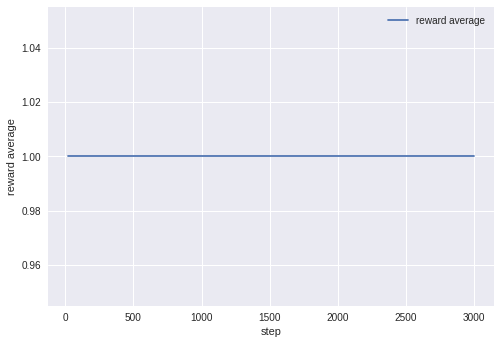

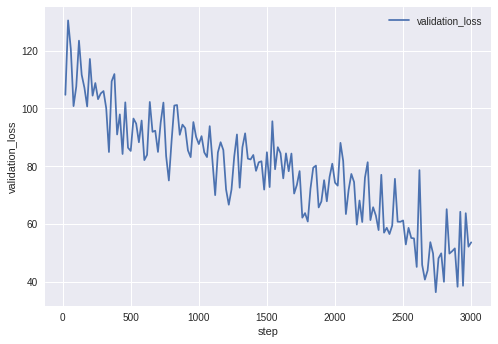

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3021
==== 3021 ====
おやすみ～
    [0]もぉ💩💩たあwww             
    [1]もぉ💩💩たあ、もうまだ💩たんだ！！！！！！ 
おはようございます。寒いですね。
    [0]え、これ…                          
    [1]え、これ………………………………うち…何だともあっなんやた、💩) 
今回もよろしくです。
    [0]はい！ 
    [1]いえいえ！ 
ばいとおわ！
    [0]💩！                  
    [1]おか！！！！💩の色目にやってます(˘ω˘) 
avg_reply_len=19.2
validation loss=54.9
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3041
==== 3041 ====
おやすみ～
    [0]よし💩💩💩💩💩......                  
    [1]よし💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩........
おはようございます。寒いですね。
    [0]💩がどうも💩です💩ω˘ω˘)   
    [1]💩がどうも💩です💩ω˘ω˘)ｽﾔｧ… 
今回もよろしくです。
    [0]ほら！                
    [1]ほら、自由でも💩してきてきたわ(^ω^) 
ばいとおわ！
    [0]💩！                   
    [1]おございます！！！！！ではは追加します…(T.T) 
avg_reply_len=22.0
validation loss=35.8
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.I

.........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3101
==== 3101 ====
おやすみ～
    [0]ほんとだよwww  
    [1]ほんとだよねwww 
おはようございます。寒いですね。
    [0]え、、、、、、、、、、     
    [1]え、、、、、、、、、、、、３) 
今回もよろしくです。
    [0]はい！      
    [1]いえいえ、💩を💩💩」 
ばいとおわ！
    [0]💩！                         
    [1]おか！！！💩💩💩💩に💩💩[💩💩💩はごく💩、ごくをてはて。 
avg_reply_len=15.5
validation loss=36.9
learning rate 0.5
msec/data=6.4


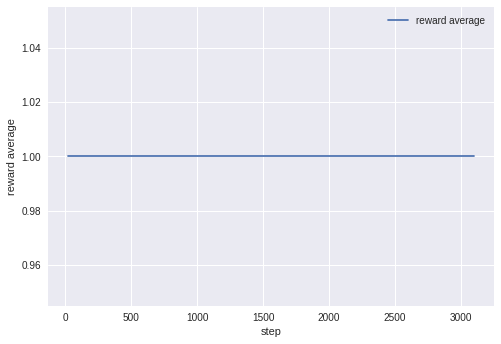

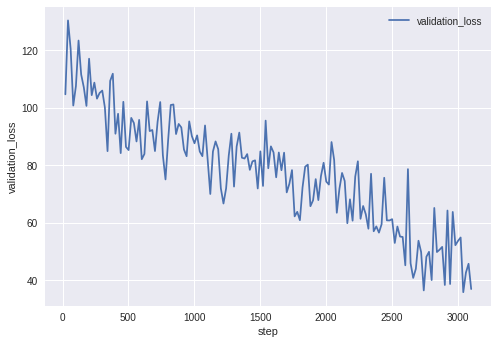

..................reward average=1.0
.rm: cannot remove 'model/tweet_large_rl/*': No such file or directory
===== Train RL tweets_medium.txt ====
src:
{'machine': 'master', 'batch_size': 64, 'num_units': 512, 'num_layers': 2, 'vocab_size': 5000, 'embedding_size': 256, 'learning_rate': 0.5, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 30, 'decoder_length': 30, 'max_gradient_norm': 5.0, 'beam_width': 0, 'num_train_steps': 3120, 'model_path': 'model/tweet_large'}
dst
{'machine': 'master', 'batch_size': 64, 'num_units': 512, 'num_layers': 2, 'vocab_size': 5000, 'embedding_size': 256, 'learning_rate': 0.1, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 30, 'decoder_length': 30, 'max_gradient_norm': 5.0, 'beam_width': 0, 'num_train_steps': 3120, 'model_path': 'model/tweet_large_rl'}
generating enc and dec files...
generating vocab file...
loading vocab...
generating id files...
generating padded input file...
generating dec eos/sos files...
don

.............reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3162
==== 3162 ====
おやすみ～
    [0]もぉ日💩てないから、、💩に.💩に描く💩にてもまだ💩💩も近くそうました(›´️ 
おやすみ～
    [0]かわいいわぁ💩                          
    [1]もぉ日💩てないから、、💩に.💩に描く💩にてもまだ💩💩も近くそうました(›´️ 
おはようございます。寒いですね。
    [0]💩がどうです💩 
おはようございます。寒いですね。
    [0]え、、、、、、💩、  
    [1]え、、、、、、💩、、 
今回もよろしくです。
    [0]はい！ 
今回もよろしくです。
    [0]はい！   
    [1]はいーいこwww 
ばいとおわ！
    [0]おか！ 
ばいとおわ！
    [0]💩   
    [1]おか！ 
avg_reply_len=13.8
validation loss=55.1
learning rate 0.1
msec/data=9.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3182
==== 3182 ====
おやすみ～
    [0]もぉ日💩てないから、、💩で.💩に描く💩💩たが💩💩が💩💩💩💩💩💩💩 
おやすみ～
    [0]もぉ日💩てないから、、                     
    [1]もぉ日💩てないから、、💩で.💩に描く💩💩たが💩💩が💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩がどうです💩 
おはようございます。寒いですね。
    [0]え、、、、、、💩、  
    [1]え、、、、、、💩、、 
今回もよろしくです。
    [0]はい！ 
今回もよろしくです。
    [0]はい！   
    [1]はいーいこwww 
ばいとおわ！
    [0]おか！！！💩💩と色しましたよ

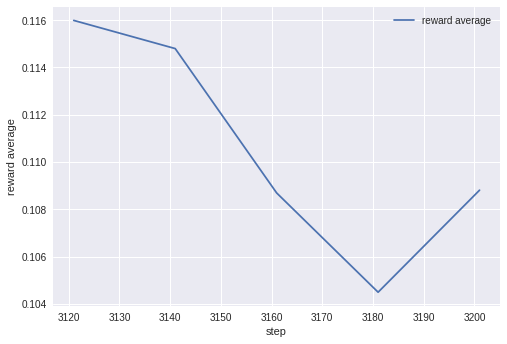

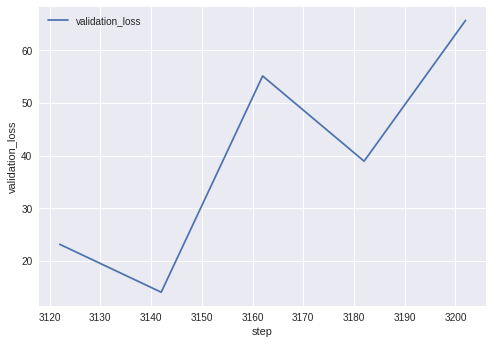

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3222
==== 3222 ====
おやすみ～
    [0]もぉ日💩てないから、💩💩だからwww 
おやすみ～
    [0]もぉ御迎えだからwww        
    [1]もぉ日💩てないから、💩💩だからwww 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうだからははは💩💩狐💩💩💩💩💩…) 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうだからははは💩💩狐💩💩💩💩💩('-')    
    [1]💩がどうです💩になったからそうだからははは💩💩狐💩💩💩💩💩(˘˘ω˘) 
今回もよろしくです。
    [0]はい！ 
今回もよろしくです。
    [0]はい！   
    [1]はいーいこwww 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか〜！ 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜！ 
avg_reply_len=18.0
validation loss=24.4
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3242
==== 3242 ====
おやすみ～
    [0]もぉ日💩てないから、、💩や(^ω^) 
おやすみ～
    [0]もぉ日💩てないなwww         
    [1]もぉ日💩てないから、、💩や(^ω^) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったから好きもそんなにはは💩💩がは次ははω​˙) 
おはようございます。寒いですね。
    [0]💩がどうです💩？                    
    [1]💩がどうです💩になったからそうだからははは💩💩狐💩💩💩💩💩…) 
今回もよ

    [0]💩の知らない💩？                    
    [1]💩の知らない💩？💩はわかっても💩からはははは何ではです(˘・) 
今回もよろしくです。
    [0]いえいえー✌️💩💩www 
今回もよろしくです。
    [0]はい！      
    [1]いえいえー✌️💩💩www 
ばいとおわ！
    [0]おか！！！💩💩と色しましたよ！ 
ばいとおわ！
    [0]💩！             
    [1]おか！！！💩💩と色しましたよ！ 
avg_reply_len=20.0
validation loss=12.9
learning rate 0.1
msec/data=9.1
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3302
==== 3302 ====
おやすみ～
    [0]もぉ💩💩、💩、何でを💩て色々💩たんですけど、💩で💩てる(.....T.T
おやすみ～
    [0]もぉ日💩てないなwww      
    [1]もぉ日💩てないの、もう💩だ💩. 
おはようございます。寒いですね。
    [0]💩がどうなのも好きです💩になってますからはははは💩でででで(˘) 
おはようございます。寒いですね。
    [0]💩の知らない💩？        
    [1]💩の知らない💩？💩はわかっても💩ね 
今回もよろしくです。
    [0]いえいえー✌︎💩*www 
今回もよろしくです。
    [0]はい！      
    [1]いえいえー✌︎💩*www 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか〜！ 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜！ 
avg_reply_len=24.8
validation loss=34.4
learning rate 0.1
msec/data=9.1


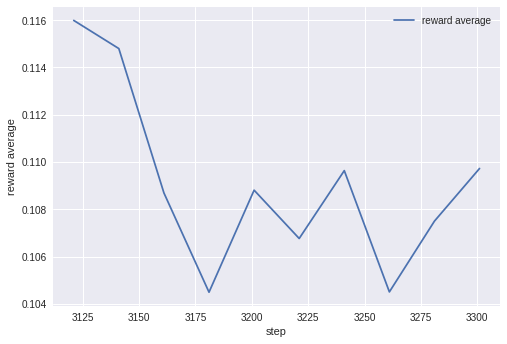

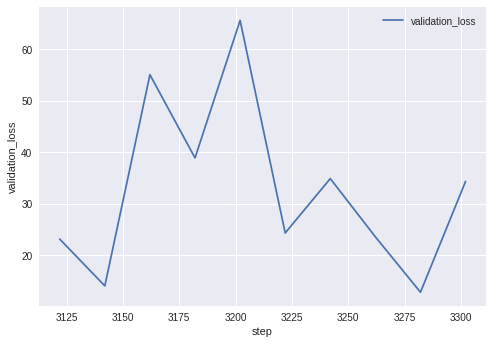

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3322
==== 3322 ====
おやすみ～
    [0]もぉ日💩てないな(¯💩︎) 
おやすみ～
    [0]もぉ日💩てないから、、💩や(^ω^)    
    [1]もぉ日💩てないから、、💩で.💩に💩になりますww 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩💩(´・`) 
おはようございます。寒いですね。
    [0]💩の知らない💩？                    
    [1]💩の知らない💩？💩はわかっても💩からはははは何でてないω・`) 
今回もよろしくです。
    [0]いえいえー✌︎💩💩www 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成。 
ばいとおわ！
    [0]おか！！！💩💩と色しましたよ！ 
ばいとおわ！
    [0]💩！             
    [1]おか！！！💩💩と色しましたよ！ 
avg_reply_len=18.5
validation loss=21.6
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3342
==== 3342 ====
おやすみ～
    [0]もぉ💩💩、💩を速攻.ををなりました 
おやすみ～
    [0]もぉ日💩てないなwww      
    [1]もぉ日💩てないの、もう💩だわwww 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは何では(˘ω・˘) 
おはようございます。寒いですね。
    [0]💩の知らない💩？             
    [1]💩の知らない💩？💩はわかってもいいですからはは…… 
今回もよろしくです。
    [0]いえいえー✌️💩www

    [0]おか！！！💩💩と色しましたよ！ 
ばいとおわ！
    [0]💩！             
    [1]おか！！！💩💩と色しましたよ！ 
avg_reply_len=19.8
validation loss=32.2
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3402
==== 3402 ====
おやすみ～
    [0]もぉ日💩てないの、(˙-˙) 
おやすみ～
    [0]もぉ日💩てないの、(˙-˙) 
    [1]もぉ日💩てないの、(˙-˙  
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは何では(˘ω˘)  
    [1]💩がどうで好きになったからそんなにはは💩ははは何では何か(˘・) 
今回もよろしくです。
    [0]いえいえー✌️💩💩www 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成。 
ばいとおわ！
    [0]おか！！！💩💩💩と色福岡しました！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩と色福岡しました！！ 
avg_reply_len=17.5
validation loss=32.1
learning rate 0.1
msec/data=9.2


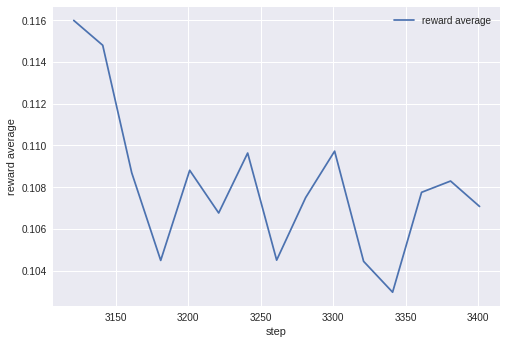

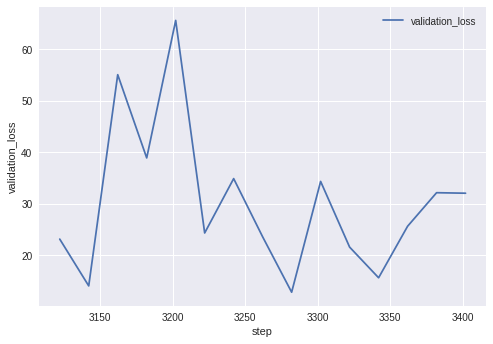

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3422
==== 3422 ====
おやすみ～
    [0]もぉ日💩てないの、(˙-˙) 
おやすみ～
    [0]もぉ日💩てないな(¯💩︎) 
    [1]もぉ日💩てないな(^ω･`) 
おはようございます。寒いですね。
    [0]💩がどうです💩？ 
おはようございます。寒いですね。
    [0]💩の知らない💩？                      
    [1]💩の知らない💩？💩はわかってもいいですからはは💩………………………… 
今回もよろしくです。
    [0]いえいえー✌️💩💩www 
今回もよろしくです。
    [0]はい！      
    [1]いえいえー✌️💩💩www 
ばいとおわ！
    [0]おか！！！💩💩💩と色福岡しました！！！ 
ばいとおわ！
    [0]💩！                
    [1]おか！！！💩💩💩と色福岡しました！！！ 
avg_reply_len=14.2
validation loss=32.9
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3442
==== 3442 ====
おやすみ～
    [0]もぉ日💩てないの、もう💩だ💩. 
おやすみ～
    [0]もぉ日💩てないの、もう💩だわwww 
    [1]もぉ日💩てないの、もう💩だわ  
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩はははは何でで(˘ω・˘) 
おはようございます。寒いですね。
    [0]💩がどうです💩？        
    [1]💩がどうです💩になったからそうですね) 
今回もよろしくです。
    [0]いえいえー✌️💩💩？？(💩*) 
今回もよろしくです。
    [0]はい！ 

    [0]えー、覚えても💩…………………………うちでもどうだ…(´•ω') 
    [1]えー、覚えても💩…………………………うちでもどうだ……(-💩) 
今回もよろしくです。
    [0]いえいえ！ 
今回もよろしくです。
    [0]ほら！                        
    [1]ほら、ほらどう……(˘ω˘)ｽﾔｧ…でも思いついたら思いついないかね(˘ω˘) 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜！ 
avg_reply_len=12.5
validation loss=50.7
learning rate 0.1
msec/data=9.1
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3502
==== 3502 ====
おやすみ～
    [0]もぉ日💩てないの、ファボ💩💩に💩たわ 
おやすみ～
    [0]もぉ日💩てないのがファボ💩だわwww   
    [1]もぉ日💩てないの、ファボ💩💩に💩たわ 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩💩ね(˙-˙) 
おはようございます。寒いですね。
    [0]えー、覚えても💩…に…になるから言わますね。              
    [1]えー、覚えても💩…に…になるから言わますね。💩はストーリーだからです💩💦速攻ののててて
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！                          
    [1]ほら、ほらどう……(˘ω˘)ｽﾔｧ…でも暇でも否定番なんですね…(¨̮) 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか〜！ 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜！ 
avg_reply_len=18.0
validation loss=14.5
learning rat

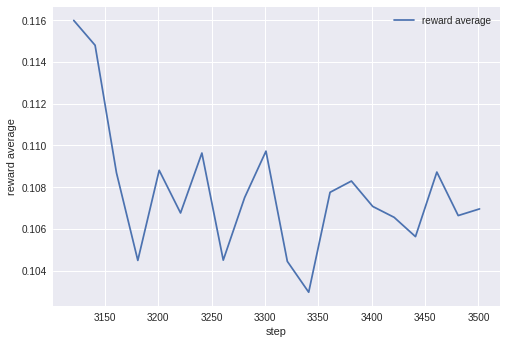

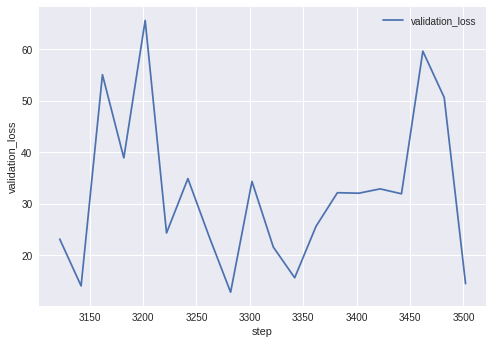

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3522
==== 3522 ====
おやすみ～
    [0]もぉ日でてないの、💩💩💩ちゃん💩てる💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おやすみ～
    [0]もぉ色つけて、、、 
    [1]もぉ色つけて、、💩 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩だ(・・・・ω・・! 
おはようございます。寒いですね。
    [0]えー、覚えても💩……………………………うちでもどうだ……うん？？？ 
    [1]えー、覚えても💩……………………………うちでもほんとだ……うん？？？ 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！            
    [1]ほら、ほらどう……(˘ω˘)ｽﾔｧ… 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか〜！ 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜！ 
avg_reply_len=22.8
validation loss=31.2
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3542
==== 3542 ====
おやすみ～
    [0]もぉ日でないのがない(˙-˙) 
おやすみ～
    [0]もぉ色でないからwww  
    [1]もぉ色でないのがwww 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうですね             
    [1]💩がどうです💩になったからそんなですからはははは何💩しますω・・) 
今回もよろしくです。
 

    [0]💩の知らない💩？       
    [1]💩の知らない💩？💩~からだからね 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか！ 
ばいとおわ！
    [0]💩！             
    [1]おか！！！💩💩と色しましたか！ 
avg_reply_len=23.2
validation loss=26.6
learning rate 0.1
msec/data=9.1
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3602
==== 3602 ====
おやすみ～
    [0]もぉ日でてないの、💩💩💩ちゃん💩てるが💩がた💩💩が💩💩が毎日上げました。 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉ前に💩ないのな(¯💩︎) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩何でがでで(˘`) 
おはようございます。寒いですね。
    [0]えー、覚えても💩…に…にも💩てもからからからからからからからから(˘・・・・ 
    [1]えー、覚えても💩…に…にも💩てもからからからからからからからから(˘・・˙˙ 
今回もよろしくです。
    [0]ほら、ほらどうでしょうwww 
今回もよろしくです。
    [0]ほらー‼     
    [1]ほら、ほらどうでしょうwww 
ばいとおわ！
    [0]おか！！！💩💩と色しましたか〜💩 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩と色しましたか〜💩 
avg_reply_len=25.8
validation loss=40.3
learning rate 0.1
msec/data=9.3


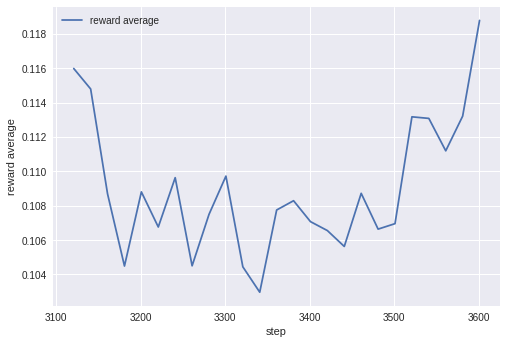

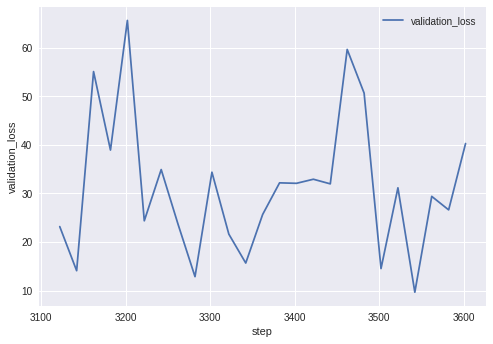

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3622
==== 3622 ====
おやすみ～
    [0]もぉ💩すぎてもう💩💩んわwww 
おやすみ～
    [0]もぉ日でないの、、                    
    [1]もぉ日でないの、、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩… 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったからそんなだから思いないからはははははのでの) 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったらそんなことれるねwww 
    [1]えー、覚えても💩…になったらそんなことれるねね 
今回もよろしくです。
    [0]ほらー‼ 
今回もよろしくです。
    [0]ほらー‼     
    [1]ほら、そしてどう色々💩www 
ばいとおわ！
    [0]おか！！！💩💩💩と色福岡しました！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩と色福岡しました！！ 
avg_reply_len=19.2
validation loss=29.0
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3642
==== 3642 ====
おやすみ～
    [0]もぉ日💩てないの、もう💩💩だな 
おやすみ～
    [0]もぉ日💩て💩んわwww     
    [1]もぉ日💩てないの、もう💩💩だな 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩だ(・ω・*)ω・`) 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったらそんなことれたねwww   
    [1]えー、覚えても💩…になったらそんなことれたからいいですwww 


    [0]もぉ日でてないの、💩💩💩ちゃん💩てるが💩💩が💩💩たがそれでも毎日いつかさます 
おやすみ～
    [0]もぉ日💩て💩ないわwww     
    [1]もぉ日💩て💩ないわ(˘ω˘) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩ははは💩だ(´・`) 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうですね            
    [1]💩がどうです💩になったからそんなですからはははは💩💩(´・`) 
今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)ｽﾔｧ…でもネタすら行くようですけどね(¨̮) 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=28.0
validation loss=27.0
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3702
==== 3702 ====
おやすみ～
    [0]もぉ日でてないの、💩💩💩ちゃん💩てるが💩💩が💩💩たがそれでも毎日いつかさまし！ 
おやすみ～
    [0]もぉ日、ほんとだわwww   
    [1]もぉ日、ほんとだわ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったからそんなことれたらねからはははまたこれでω​ね💩 
    [1]えー、覚えても💩…になったからそんなことれたらねからはははまたこれでω​`‹💩 
今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)ｽﾔｧ…でもネタすら行くようですけどね(¨̮) 
今回もよろしくです。
    [0]いえいえ、そしてどう色々したわwww     
    

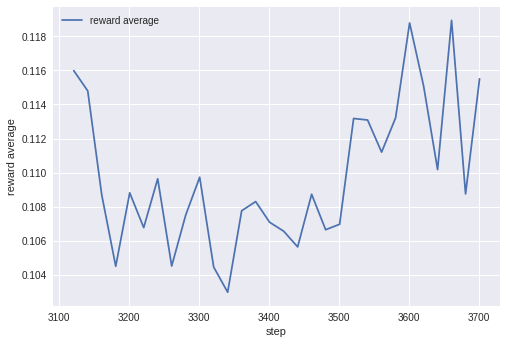

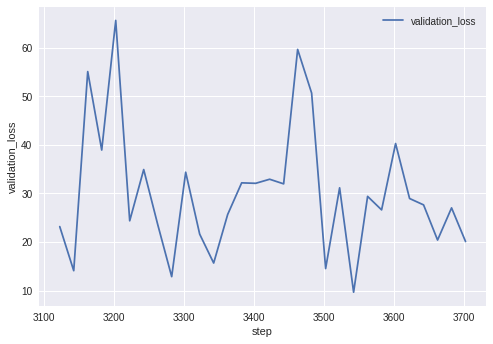

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3722
==== 3722 ====
おやすみ～
    [0]もぉ日でてない(T.T) 
おやすみ～
    [0]もぉ日、ほんとやわ！    
    [1]もぉ日でてない(T.T) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]💩の知らない💩？       
    [1]💩の知らない💩？💩~からだからね 
今回もよろしくです。
    [0]ほら、ほらどうでしょうwww 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=13.5
validation loss=7.8
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3742
==== 3742 ====
おやすみ～
    [0]もぉ💩すぎてもう💩💩んわwww 
おやすみ～
    [0]もぉ日、ほんとやわ！     
    [1]もぉ日、ほんとやわ！💩💩なな 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えー、覚えても💩…にお前に言われたから…  
    [1]えー、覚えても💩…にお前に言われたからねwww 
今回もよろしくです。
    [0]ほら、ほらどう……(˘ω˘)ｽﾔｧ…でも暇でも否定好きなので好きです(¨̮) 
今回もよろしくです。
    [0]ほら！                         
    [1]ほら、

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3802
==== 3802 ====
おやすみ～
    [0]もぉ💩すぎてもう💩💩んわwww 
おやすみ～
    [0]もぉ日、ほんとだわwww 
    [1]もぉ日、ほんとやわ！ 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えー、覚えても💩wwwやに怒られますね  
    [1]えー、覚えても💩wwwやに怒られますからね 
今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)ｽﾔｧ…でもネタすら行くようですけどね(¨̮) 
今回もよろしくです。
    [0]そして完成    
    [1]そして完成〜…💩 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですか！！ 
ばいとおわ！
    [0]💩！             
    [1]おか！！！💩💩💩でしろですか！！ 
avg_reply_len=23.8
validation loss=16.3
learning rate 0.1
msec/data=9.0


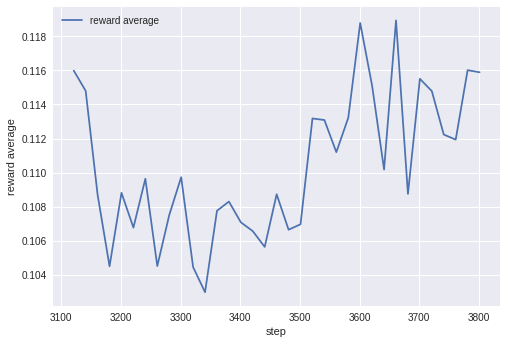

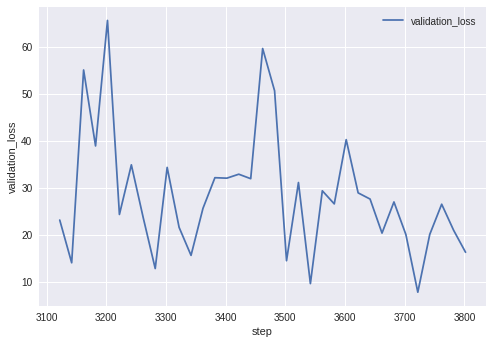

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3822
==== 3822 ====
おやすみ～
    [0]もぉ日、ほんとだわwww 
おやすみ～
    [0]もぉP、💩すぎたいかなwww  
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えー、覚えても💩…にお前に言われたから…  
    [1]えー、覚えても💩…にお前に言われたからねwww 
今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)ｽﾔｧ…でもネタすら行く運動だんだけど？(¨̮) 
今回もよろしくです。
    [0]いえいえ、そしてどうでた…www 
    [1]いえいえ、そしてどうでた。www 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！           
    [1]おか！！！💩💩💩で枠ヤツな 
avg_reply_len=19.8
validation loss=21.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3842
==== 3842 ====
おやすみ～
    [0]もぉ💩すぎてもう💩💩んわwww 
おやすみ～
    [0]もぉ日、ほんとやわ！     
    [1]もぉ日、ほんとやわ！💩💩なな 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったからそんなことれたらねね           
    [1]えー、覚えても💩…になったからそんなことれたらねからははまたこれではω​か💩 
今回もよろしくです。
    [0]ほら、もうどうこ…

ばいとおわ！
    [0]おか！！！💩💩💩と色福岡としてが福岡して笑って💩💩💩💩がなりくれる 
ばいとおわ！
    [0]💩！                        
    [1]おか！！！💩💩💩と色福岡としてが福岡して笑って💩💩💩💩がなりくれる 
avg_reply_len=23.8
validation loss=17.2
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3902
==== 3902 ====
おやすみ～
    [0]もぉ日、ほんとでしょ(˙-˙) 
おやすみ～
    [0]もぉ前だからwww     
    [1]もぉ前だから(˙-˙) 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうねね 
おはようございます。寒いですね。
    [0]えー、覚えても💩…になったからそんなことれたからねwww          
    [1]えー、覚えても💩…になったからそんなことれたらねからはははまたこれでω​か💩 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！                     
    [1]ほら、もうどうこ……(˘ω˘)そもそもネタネタをいいんですけどね(^^) 
ばいとおわ！
    [0]おか！！！💩💩💩と色福岡しました！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩と色福岡しました！！ 
avg_reply_len=14.2
validation loss=30.6
learning rate 0.1
msec/data=9.1


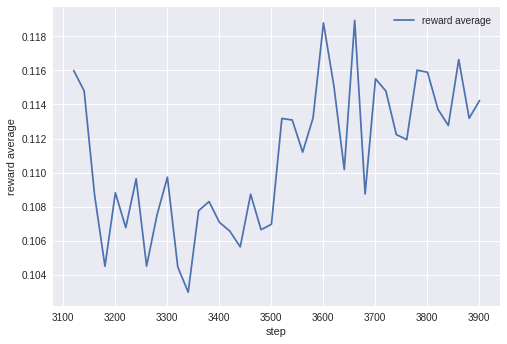

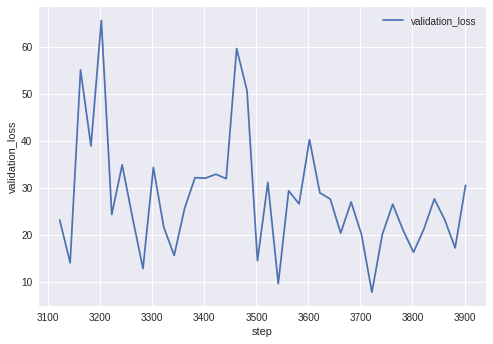

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3922
==== 3922 ====
おやすみ～
    [0]もぉ日、ほんとでしょ(˙-˙) 
おやすみ～
    [0]もぉ前に💩ないから、💩💩      
    [1]もぉ前に💩ないから、(....💩) 
おはようございます。寒いですね。
    [0]えー、、、マジで… 
おはようございます。寒いですね。
    [0]💩がどうです💩？そんなだですね  
    [1]💩がどうです💩？そんなだですねね 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！                      
    [1]いえいえ、そしてどうも色々わからじゃないから…💩ちゃん全てやったらきたやつのほんとほんとな 
ばいとおわ！
    [0]おか！！！💩💩と色飲みだら3💩ちゃん💩💩、[💩下さい💩💩ははまたてください 
ばいとおわ！
    [0]💩！                          
    [1]おか！！！💩💩と色飲みだら3💩ちゃん💩💩、[💩下さい💩💩ははまたてください 
avg_reply_len=17.0
validation loss=28.4
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-3942
==== 3942 ====
おやすみ～
    [0]もぉ日、ほんとでしょ(˙-˙) 
おやすみ～
    [0]もぉ前に💩ないの？('-')    
    [1]もぉ前に💩ないの？うん(˘ω˘) 
おはようございます。寒いですね。
    [0]えー、、、マジで… 
おはようございます。寒いですね。
    [0]💩がどうです💩？そんなだですね  
    [1]💩がどうです💩？そんなだですねね 
今回もよろしくです。
    [0]

今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)そもそもネタネタをいいんですけどね(^^) 
今回もよろしくです。
    [0]そして完成                     
    [1]ほら、もうどうこ……(˘ω˘)そもそもネタネタをいいんですけどね(^^) 
ばいとおわ！
    [0]おか！！！💩💩とやってくれるよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩とやってくれるよ！ 
avg_reply_len=21.5
validation loss=29.3
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4002
==== 4002 ====
おやすみ～
    [0]もぉ日でてないんwww 
おやすみ～
    [0]もぉ前に💩ないのそれ(˘ω˘)  
    [1]もぉ前に💩ないのそれは(...) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそうですね             
    [1]💩がどうです💩になったからそんなですねそんなだはは💩れるのだ💩・・・ 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩と色飲み▿感💩！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩と色飲み▿感💩！！ 
avg_reply_len=14.2
validation loss=25.7
learning rate 0.1
msec/data=9.1


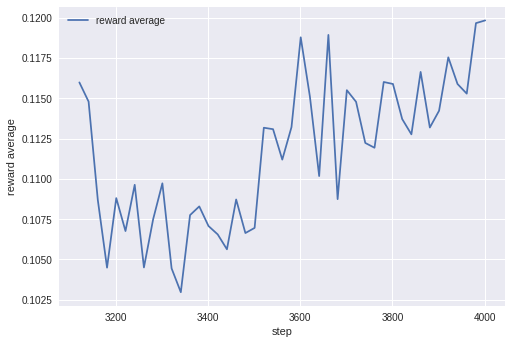

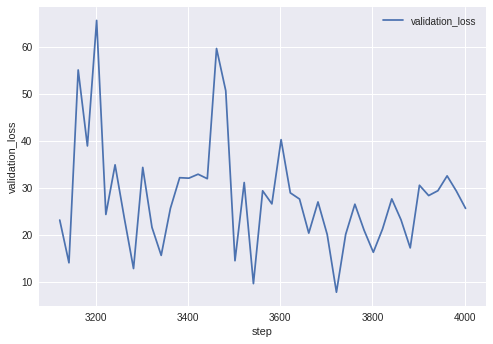

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4022
==== 4022 ====
おやすみ～
    [0]もぉ前に💩ないのな(¯💩︎) 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉ前に💩ないのな(¯💩︎) 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなにはは💩💩ね 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです  
今回もよろしくです。
    [0]ほら、もうどうこ……(˘ω˘)そもそもネタ22ネタを行くね💩💩けどはまた約しました。
今回もよろしくです。
    [0]そして完成         
    [1]そして完成………(⊙💩̥) 
ばいとおわ！
    [0]おか！！！💩💩💩とで福岡しました！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩とで福岡しました！！ 
avg_reply_len=24.8
validation loss=36.6
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4042
==== 4042 ====
おやすみ～
    [0]もぉ前に💩ないの、(˃̣̣̥ω💩) 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉ前に💩ないの、(˃̣̣̥ω💩) 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです  
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツか！！ 

おはようございます。寒いですね。
    [0]💩がどうです💩になったからそんなですねそんなだはは💩… 
おはようございます。寒いですね。
    [0]えーって感じです               
    [1]💩がどうです💩になったからそんなですねそんなだはは💩… 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！       
    [1]いえいえ、そしてどう色々💩…www 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツな 
ばいとおわ！
    [0]💩！           
    [1]おか！！！💩💩💩で枠ヤツな 
avg_reply_len=16.0
validation loss=21.5
learning rate 0.1
msec/data=9.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4102
==== 4102 ====
おやすみ～
    [0]もぉ前に💩ないのそれ(˘ω˘) 
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
    [1]もぉP、💩に💩てくるわw 
おはようございます。寒いですね。
    [0]💩がどうで💩になったから言わなくたからです。 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそんなですねそんなだはは💩…        
    [1]💩がどうです💩になったからそんなですねそんなだはは💩…はだ(^ω^) 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成       
    [1]そして完成〜…(¨̮) 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツか!!! 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩で枠ヤツか!!! 
avg_reply_len=15.5
validation loss=25.5
learning rate 0.1
msec/data=9.0


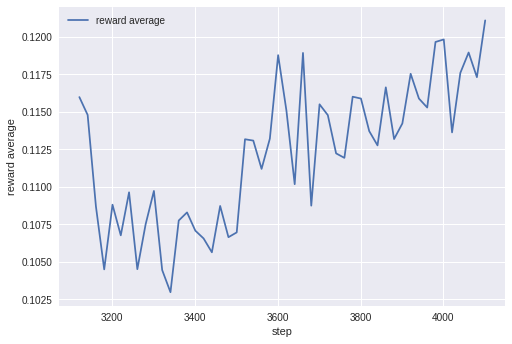

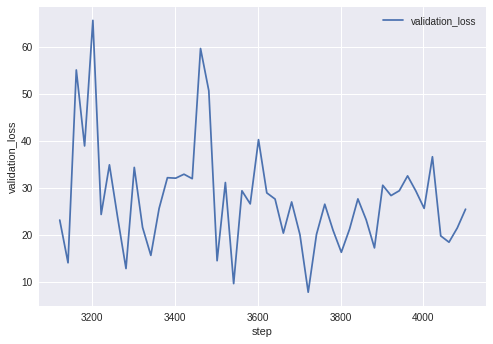

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4122
==== 4122 ====
おやすみ～
    [0]もぉ前に💩ないのがファボ💩💩ちゃん💩た💩💩💩💩💩💩💩💩💩💩💩… 
おやすみ～
    [0]もぉ前だからwww                     
    [1]もぉ前に💩ないのがファボ💩💩ちゃん💩た💩💩💩💩💩💩💩💩💩💩💩… 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツか!!! 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩で枠ヤツか!!! 
avg_reply_len=15.5
validation loss=21.9
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4142
==== 4142 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！                 
    [1]💩💩とか💩を💩にしてた、、問い

..............reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4202
==== 4202 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww     
    [1]もぉP、💩すぎすぎなわwww 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=9.8
validation loss=28.7
learning rate 0.1
msec/data=8.8


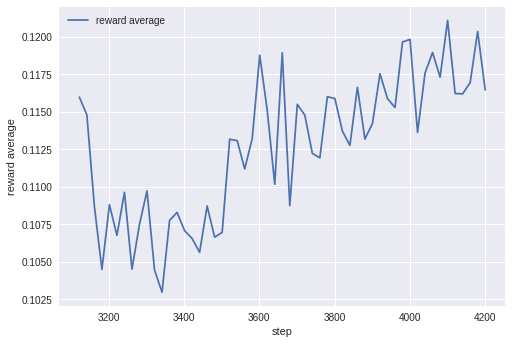

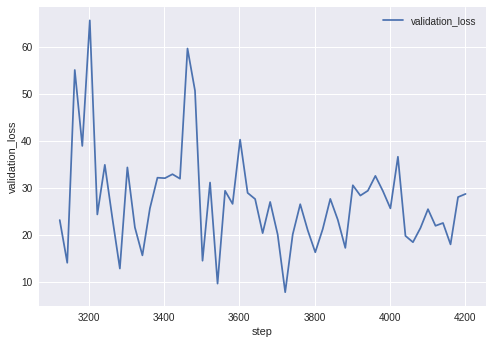

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4222
==== 4222 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]💩がどうです💩になったからそんなですねそんなだはもう💩れるのだ💩・・・) 
おはようございます。寒いですね。
    [0]えー、覚えても💩…にお前に言われたから…               
    [1]えー、覚えても💩…にお前に言われたから…とはははまたまたでで💩ね(˘`) 
今回もよろしくです。
    [0]ほらー‼ 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成。 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！ 
    [1]💩  
avg_reply_len=13.8
validation loss=9.9
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4242
==== 4242 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww       
    [1]もぉP、💩に💩してくるわwww 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。   
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツか!!! 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩で

..............reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4302
==== 4302 ====
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]💩がどうで好きになったからそんなですねwww 
おはようございます。寒いですね。
    [0]💩の知らない💩？そんな言わやたね。 
    [1]💩の知らない💩？そんな言わやたねね 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！                    
    [1]💩💩とか💩を💩💩にしてたと💩を💩ました((（ページ） 
avg_reply_len=11.2
validation loss=17.7
learning rate 0.1
msec/data=8.9


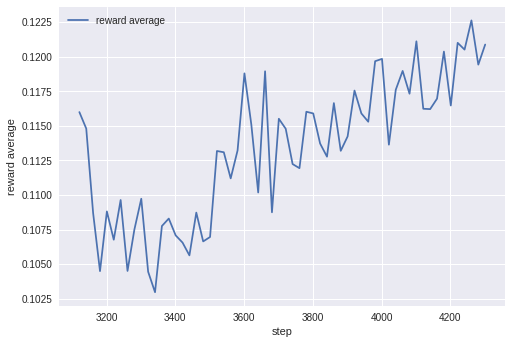

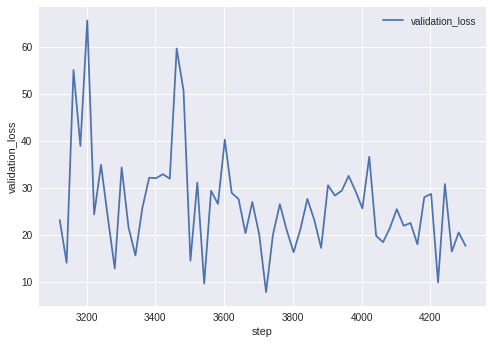

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4322
==== 4322 ====
おやすみ～
    [0]もぉP、💩すぎすぎわ(ˊᵕˋ) 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩すぎすぎわ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです          
    [1]その人です奴です💩💩~💩にですね‼ 
今回もよろしくです。
    [0]ほら、もうどうこそうな 
今回もよろしくです。
    [0]そして完成       
    [1]そして完成〜…(¨̮) 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！               
    [1]💩💩とか💩を💩💩にしてた、、9ページ） 
avg_reply_len=10.0
validation loss=14.6
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4342
==== 4342 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww       
    [1]もぉ前で💩ないのがファボ('-') 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]ほら、もうどうこそうな 
今回もよろしくです。
    [0]そして完成       
    [1]そして完成〜…(¨̮) 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩で枠ヤ

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4402
==== 4402 ====
おやすみ～
    [0]もぉP、💩すぎすぎわ？ 
おやすみ～
    [0]もぉ前だからwww    
    [1]もぉP、💩すぎすぎわ？ 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです… 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！               
    [1]いえいえ、そしてどう色々で💩たわけ💩た💩💩ちゃん💩た 
ばいとおわ！
    [0]💩 
ばいとおわ！
    [0]💩              
    [1]💩💩とか💩を💩にしてた((、、、 
avg_reply_len=7.0
validation loss=12.5
learning rate 0.1
msec/data=8.9


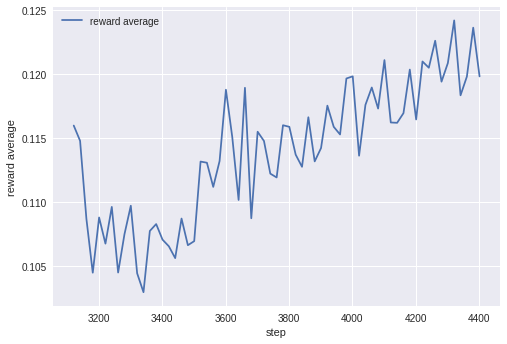

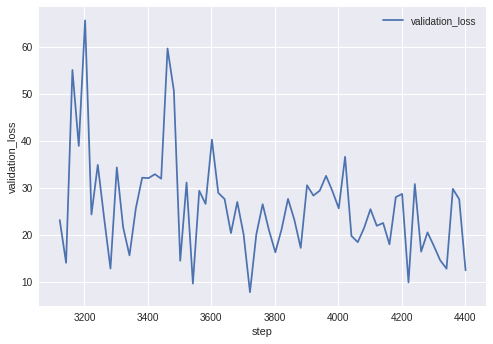

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4422
==== 4422 ====
おやすみ～
    [0]もぉP、💩すぎすぎわ(ˊᵕˋ 
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
    [1]もぉP、💩に💩てくるわw 
おはようございます。寒いですね。
    [0]えー、覚えても💩wwwやに怒られますwww 
おはようございます。寒いですね。
    [0]えーって感じです          
    [1]えー、覚えても💩wwwやに怒られますwww 
今回もよろしくです。
    [0]ほら、もうどう言うう！www 
今回もよろしくです。
    [0]そして完成       
    [1]そして完成〜…(᷇࿀᷆) 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツ色確保3) 
ばいとおわ！
    [0]💩！              
    [1]おか！！！💩💩💩で枠ヤツ色確保3) 
avg_reply_len=17.5
validation loss=11.6
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4442
==== 4442 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww       
    [1]もぉP、💩すぎすぎな(´⚰💩) 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]ほら、もうどうでもりそうな 
今回もよろしくです。
    [0]そして完成       
    [1]ほら、もうどうでもりそうな 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4502
==== 4502 ====
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです  
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！           
    [1]そして完成………でもどうしょ…(💩) 
ばいとおわ！
    [0]💩💩とか💩を💩にしてた((、、、 
ばいとおわ！
    [0]💩              
    [1]💩💩とか💩を💩にしてた((、、、 
avg_reply_len=11.5
validation loss=9.6
learning rate 0.1
msec/data=9.0


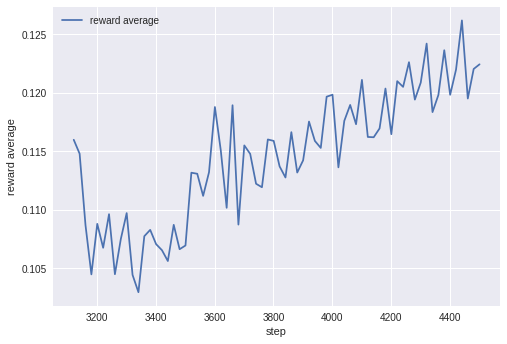

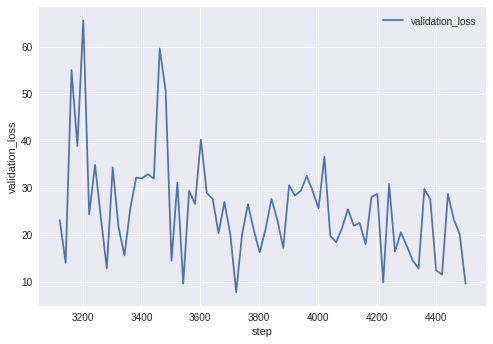

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4522
==== 4522 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉ前に💩ないの？うん(¯💩) 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです  
今回もよろしくです。
    [0]ほら、そしてどう色々💩www 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成  
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°)             
    [1]おか！！！💩💩💩で枠ヤツ色発表なかった！！！！ 
avg_reply_len=12.0
validation loss=15.1
learning rate 0.1
msec/data=9.2
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4542
==== 4542 ====
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです。 
    [1]えーって感じです  
今回もよろしくです。
    [0]ほら、そしてどうやったなぁ 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ヤツか!!!！！！ 
ばいとおわ！
    [0]おございます😊(°_°)          

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4602
==== 4602 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww     
    [1]もぉ前だから(˙-˙) 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです        
    [1]その人です奴です💩💩💩💩💩www 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成       
    [1]そして完成〜…(¨̮) 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=10.2
validation loss=11.8
learning rate 0.1
msec/data=8.9


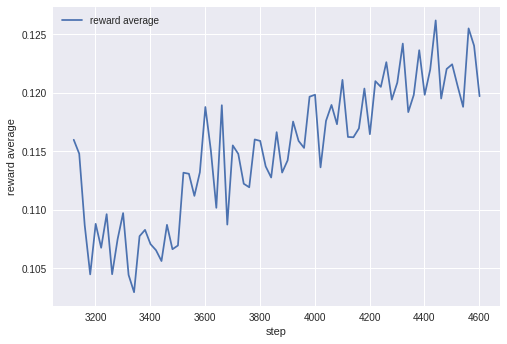

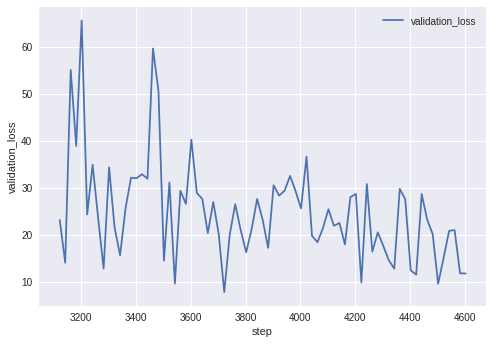

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4622
==== 4622 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww       
    [1]もぉおいしかったの💩💩💩💩するわwww 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです        
    [1]その人です奴です💩💩💩💩💩www 
今回もよろしくです。
    [0]そして完成………(ˇω⊙)エピソード2すらなんと💩💩̥してもらってくるね(¨̮) 
今回もよろしくです。
    [0]そして完成                          
    [1]そして完成………(ˇω⊙)エピソード2すらなんと💩💩̥してもらってくるね(¨̮) 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=19.0
validation loss=12.8
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4642
==== 4642 ====
おやすみ～
    [0]もぉ前に💩ないのがファボ(.....💩) 
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
    [1]もぉP、💩に💩てないわwww 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです    
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成  
    [1]

    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]えーって感じです  
    [1]えーって感じです。 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=10.5
validation loss=18.2
learning rate 0.1
msec/data=8.9
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4702
==== 4702 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww      
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成www 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成  
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩でしろですよ！ 
avg_reply_len=11.2
validation loss=22.8
learning rate 0.1
msec/data=8.9


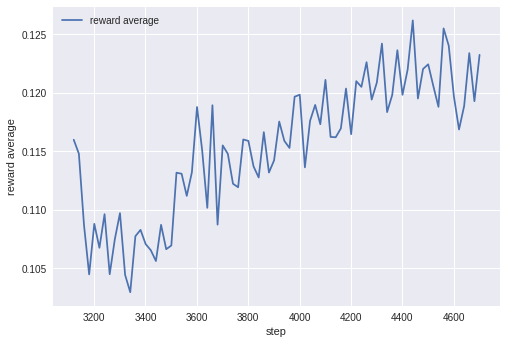

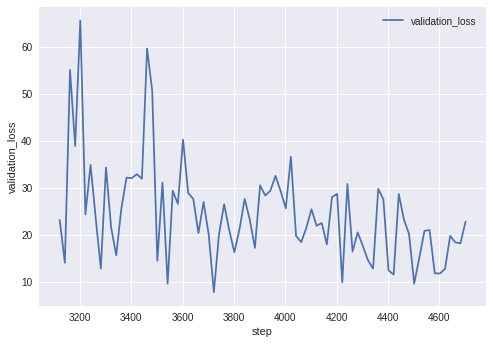

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4722
==== 4722 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww       
    [1]もぉP、💩に💩てみうわwww 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成〜…(᷇࿀᷆) 
今回もよろしくです。
    [0]そして完成……(˘ω˘)  
    [1]そして完成……(うう×•`) 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですか!!!！！ 
ばいとおわ！
    [0]おか！             
    [1]おか！！！💩💩💩でしろですか!!!！！ 
avg_reply_len=13.2
validation loss=25.9
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4742
==== 4742 ====
おやすみ～
    [0]もぉ前に💩ないの？うん(˘ω•) 
おやすみ～
    [0]もぉP、💩に💩てないわw   
    [1]もぉP、💩に💩てないわ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おか！！！💩💩💩でしろですよ！ 
ばいとおわ！
    [0]おか！           
    [1]おか

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4802
==== 4802 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww     
    [1]もぉ前に💩ないの？うん💩 
おはようございます。寒いですね。
    [0]えーって感じです。 
おはようございます。寒いですね。
    [0]その人です奴です💩        
    [1]その人です奴です💩？ᐝに💩てますwww 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩と色福岡ヤツ！！ 
ばいとおわ！
    [0]おか！            
    [1]おか！！！💩💩💩と色福岡ヤツ！！ 
avg_reply_len=10.2
validation loss=14.6
learning rate 0.1
msec/data=9.1


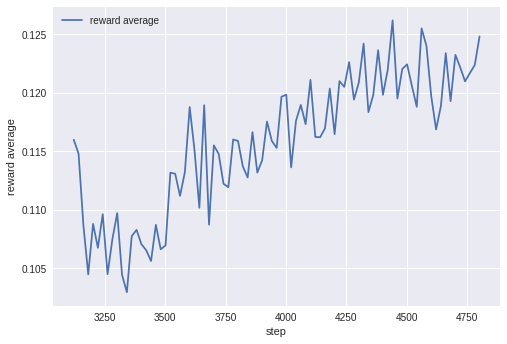

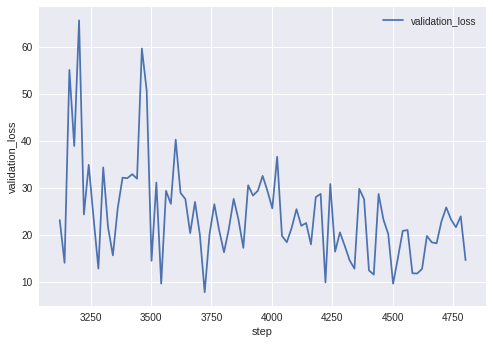

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4822
==== 4822 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉ前に💩ないの？うん(˘ω•) 
おはようございます。寒いですね。
    [0]えーwww 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ボタンのご覧！！ 
ばいとおわ！
    [0]💩               
    [1]おか！！！💩💩💩で枠ボタンのご覧！！ 
avg_reply_len=10.2
validation loss=14.7
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4842
==== 4842 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww   
    [1]もぉ前に💩ないの？ 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです    
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おございます！(°_°) 
ばいとおわ！
    [0]💩       
    [1]おございます！(°_°) 
avg_reply_len=9.5
validation loss=22.3
learning 

...........reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4902
==== 4902 ====
おやすみ～
    [0]もぉ前に💩ないの？うん(˘ω'✌︎) 
おやすみ～
    [0]もぉ色がないのがwww        
    [1]もぉ前に💩ないの？うん(˘ω'✌︎) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、そしてどうやったwww 
今回もよろしくです。
    [0]そして完成    
    [1]そして完成うかｗ 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ボタン3ヤツ！！！ 
ばいとおわ！
    [0]💩！               
    [1]おか！！！💩💩💩で枠ボタン3ヤツ！！！ 
avg_reply_len=17.5
validation loss=18.1
learning rate 0.1
msec/data=9.3


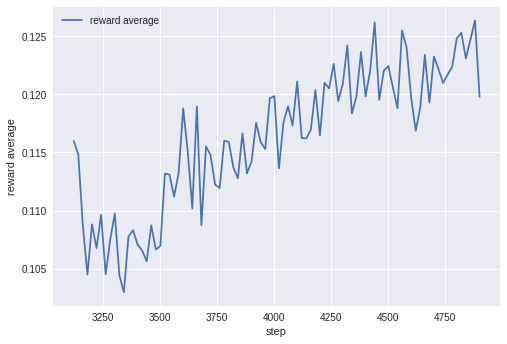

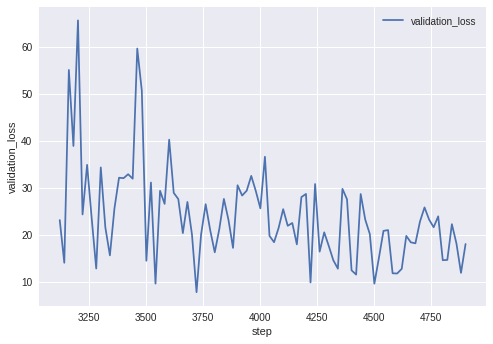

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4922
==== 4922 ====
おやすみ～
    [0]もぉ前に💩ないの？ 
おやすみ～
    [0]もぉ前に💩ないの？      
    [1]もぉ前に💩ないの？(˃̣̣̥ω˂̣̣̥) 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]えーって感じです   
    [1]えーって感じです奴… 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成     
    [1]ほら、いかがにゃ…www 
ばいとおわ！
    [0]おか！！！💩💩💩と色飲み▿感💩！！ 
ばいとおわ！
    [0]💩！ 
    [1]💩  
avg_reply_len=10.8
validation loss=11.4
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-4942
==== 4942 ====
おやすみ～
    [0]もぉ前に💩ないのが(˃̣̣̥︎💩) 
おやすみ～
    [0]もぉ前に💩ないのがこれ(..... 
    [1]もぉ前に💩ないのが(˃̣̣̥︎💩)   
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]その人です奴です💩？                      
    [1]その人です奴です💩~のでたぶん;と人💩られるとだかっていう…そこで……💩……とと 
今回もよろしくです。
    [0]ほら、そしてどうでしょた。 
今回もよろしくです。
    [0]そして完成    
    [1]そして完成うかｗ 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ボタンばPC💩！！ 
ばいとおわ！


................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5002
==== 5002 ====
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
おやすみ～
    [0]もぉおいしかったの💩        
    [1]もぉおいしかったの💩💩、これでしたわwww 
おはようございます。寒いですね。
    [0]えー、覚えても💩…にお前に言われたから…と言うからとははまた(◜​˘) 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、いかがこそ！ 
今回もよろしくです。
    [0]そして完成    
    [1]ほら、いかがこそ！ 
ばいとおわ！
    [0]おございます！(°_°) 
ばいとおわ！
    [0]おございます！(°_°)             
    [1]おか！！！💩💩💩で枠ボタンの上💩て下さい！！！ 
avg_reply_len=18.5
validation loss=14.6
learning rate 0.1
msec/data=9.2


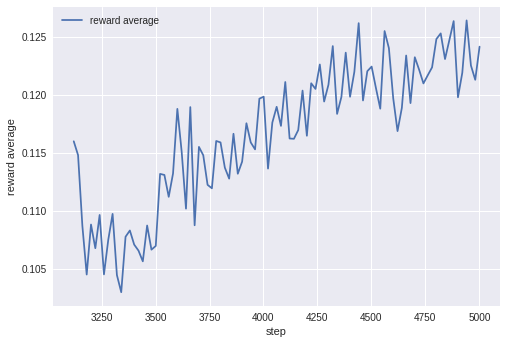

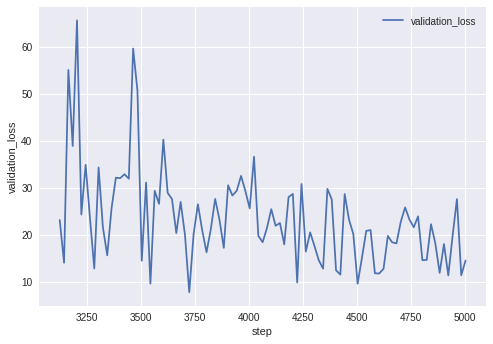

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5022
==== 5022 ====
おやすみ～
    [0]もぉ色がないのがwww 
おやすみ～
    [0]もぉ色がないのがwww     
    [1]もぉ前に💩ないのな(¯💩`) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、いかがこそ！www 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おか！！！💩💩💩で枠ボタンのご覧 
ばいとおわ！
    [0]💩！            
    [1]おか！！！💩💩💩で枠ボタンのご覧 
avg_reply_len=14.5
validation loss=10.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5042
==== 5042 ====
おやすみ～
    [0]もぉ色がないのがwww 
おやすみ～
    [0]もぉ色がないのがwww       
    [1]もぉ前に💩ないのがやばい(˙-˙) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩 
    [1]その人ですこいつ   
今回もよろしくです。
    [0]ほら、そしてどう色々💩www 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]💩💩とか💩を💩にしてた、、問い合わせについてと💩はごくでも登場です。 
ばいとおわ！
    [0]💩   

..............reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5102
==== 5102 ====
おやすみ～
    [0]もぉ前に💩ないのがファボ(.....💩) 
おやすみ～
    [0]もぉ前だからwww            
    [1]もぉ前に💩ないのがファボ(.....💩) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね  
    [1]えーwwwあのもよく無いです。 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おございます！(°_°) 
ばいとおわ！
    [0]💩                        
    [1]💩💩とか💩を💩にしてた、、問い合わせについて終了💩て来る気が上げてください。 
avg_reply_len=14.0
validation loss=18.6
learning rate 0.1
msec/data=9.1


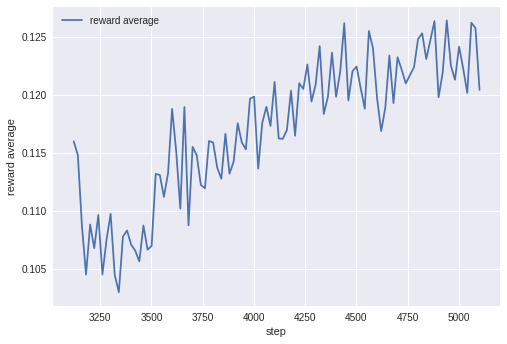

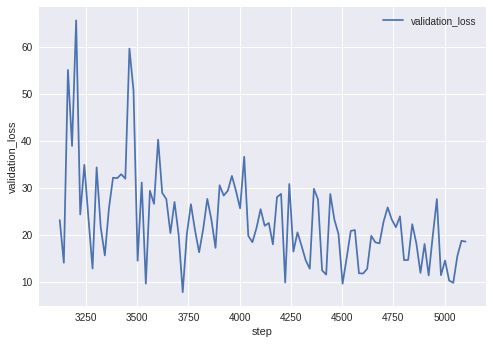

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5122
==== 5122 ====
おやすみ～
    [0]もぉおいしかったの💩💩、これでも💩ないわ 
おやすみ～
    [0]もぉ前だからwww        
    [1]もぉおいしかったの💩💩、これでも💩ないわ 
おはようございます。寒いですね。
    [0]えーwwwケーキもよく無いですねwww 
おはようございます。寒いですね。
    [0]その人です奴です💩             
    [1]その人です奴です💩~のでたぶん̥と取ってそうだからΣ… 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！ 
    [1]そして完成 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]💩                        
    [1]💩💩とか💩を💩にしてた、、問い合わせについてと9色でも上げました(◜oまぁ 
avg_reply_len=14.5
validation loss=21.2
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5142
==== 5142 ====
おやすみ～
    [0]もぉおいしかったの💩 
おやすみ～
    [0]もぉおいしかったの💩                    
    [1]もぉおいしかったの💩💩💩？運💩てどこが方んです(T.T./.. 
おはようございます。寒いですね。
    [0]💩がどうです💩ですね♪(´ε̥̥`) 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
    [1]えーwwwケーキよく無いですね  
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そ

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5202
==== 5202 ====
おやすみ～
    [0]もぉおいしかったの💩💩💩、💩ないわ(^o^) 
おやすみ～
    [0]もぉおいしかったの💩💩、これでしたわwww    
    [1]もぉおいしかったの💩💩、これでも💩ないわ('-') 
おはようございます。寒いですね。
    [0]えーwwwケーキもよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩？                       
    [1]その人です奴です💩~のでたぶん̥と取ってそんな人だからはははない💩かと変わらサッカー思い˘ω 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！  
    [1]そして完成〜 
ばいとおわ！
    [0]おか！！！💩💩💩で目で上しました！！ 
ばいとおわ！
    [0]おか！               
    [1]おか！！！💩💩💩で目で上しました！！ 
avg_reply_len=15.8
validation loss=13.8
learning rate 0.1
msec/data=9.2


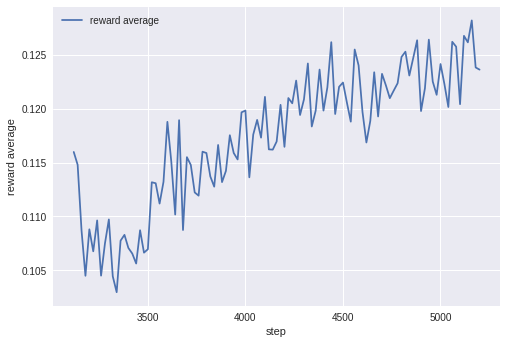

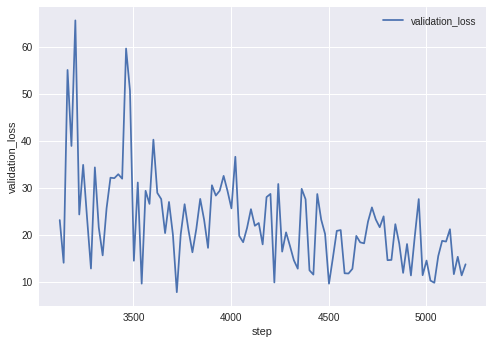

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5222
==== 5222 ====
おやすみ～
    [0]もぉ日で、て💩( 
おやすみ～
    [0]もぉ色がないのがwww 
    [1]もぉ色がないのwww  
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いのに💩~ 
おはようございます。寒いですね。
    [0]その人ですこいつ                        
    [1]その人です奴です💩~のでたぶん人とと💩ねwww何は為だ…は何そこと​`‹💩 
今回もよろしくです。
    [0]そして完成www 
今回もよろしくです。
    [0]ほら！  
    [1]そして完成www 
ばいとおわ！
    [0]おございます！(°_°) 
ばいとおわ！
    [0]おか！！！💩の色が確保3と･`)    
    [1]おか！！！💩の色が確保33^)！！！！ 
avg_reply_len=12.0
validation loss=17.0
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5242
==== 5242 ====
おやすみ～
    [0]もぉ日で、ない(˙-˙) 
おやすみ～
    [0]もぉおいしかったの💩💩、💩すぎてくる     
    [1]もぉおいしかったの💩💩、💩ないわ(˘ω˘) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人ですこいつ   
    [1]その人です奴です💩 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！    
    [1]そして完成〜…💩 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいと

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5302
==== 5302 ====
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
おやすみ～
    [0]もぉおいしかったのこれやwww    
    [1]もぉP、💩に💩てくるわwww 
おはようございます。寒いですね。
    [0]💩がどうです💩ですね♪(´ε̥̥̥̥そうです 
おはようございます。寒いですね。
    [0]その人です奴です💩                      
    [1]その人です奴です💩~ので💩、アア、今💩なんかそうにないから、ない、(◜௰そう) 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！    
    [1]そして完成〜…💩 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=13.8
validation loss=14.3
learning rate 0.1
msec/data=9.1


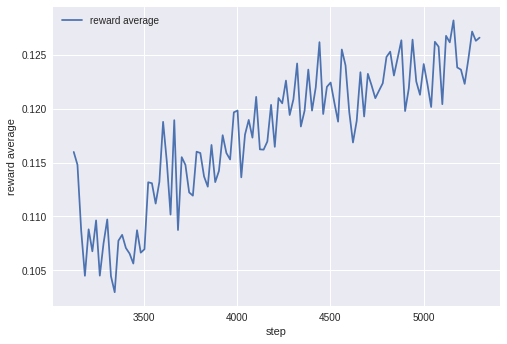

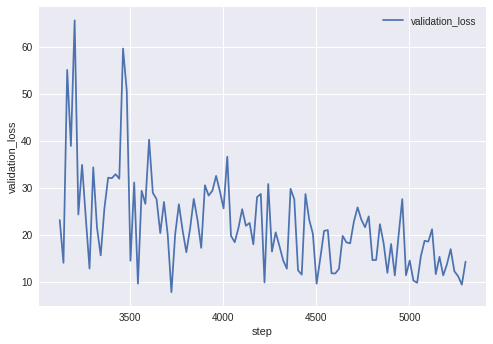

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5322
==== 5322 ====
おやすみ～
    [0]もぉおいしかったの💩💩、これでした 
おやすみ～
    [0]もぉおいしかったの💩      
    [1]もぉおいしかったの💩💩、これでした 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね、羨ましいですね 
おはようございます。寒いですね。
    [0]その人です奴です💩 
    [1]その人ですこいつwww  
今回もよろしくです。
    [0]そして完成〜 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成〜 
ばいとおわ！
    [0]💩💩とか💩を💩💩に来てた、、、）） 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)       
    [1]おつ！！！💩💩💩の色枠ヤツ！！ 
avg_reply_len=16.8
validation loss=22.9
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5342
==== 5342 ====
おやすみ～
    [0]もぉおいしかったの💩💩、これやろわ。 
おやすみ～
    [0]もぉおいしかったの💩       
    [1]もぉおいしかったの💩💩、これやろわ。 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね、羨ましいで羨ましいのは、、にになりてないんさけど、！(`‹ありがとうか(^
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]そして完成 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おつ！

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5402
==== 5402 ====
おやすみ～
    [0]もぉ御迎え、ほんとのなの💩な 
おやすみ～
    [0]もぉ御迎え、ほんとのなの💩な   
    [1]もぉ御迎え、ほんとのなの💩ないなwww 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩？ 
    [1]その人です奴です💩  
今回もよろしくです。
    [0]ほら、いかがこそう。 
今回もよろしくです。
    [0]そして完成    
    [1]そして完成うか？ 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=13.8
validation loss=12.8
learning rate 0.1
msec/data=9.0


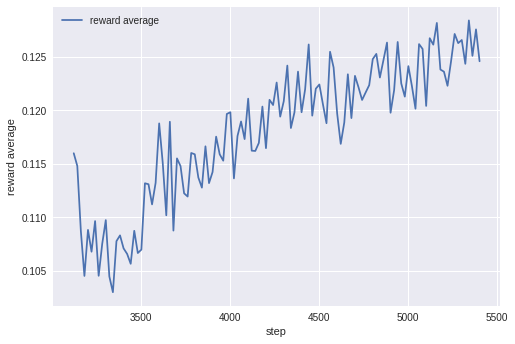

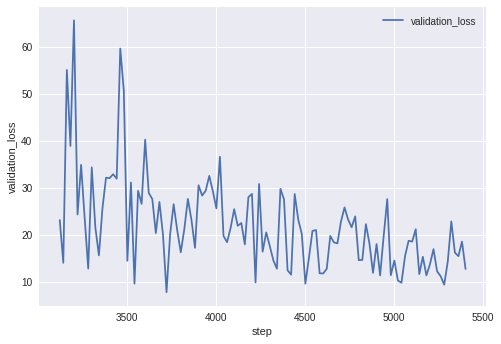

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5422
==== 5422 ====
おやすみ～
    [0]もぉ前だから(̮) 
おやすみ～
    [0]もぉ前だからwww   
    [1]もぉ前だから(̮) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩？                     
    [1]その人です奴です💩~のでたぶん人とだけど、次は何💩洗濯のはは何で(˘) 
今回もよろしくです。
    [0]ほら、そしてどうそうな 
今回もよろしくです。
    [0]そして完成www   
    [1]そして完成うか？ 
ばいとおわ！
    [0]おございます！(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=12.8
validation loss=15.9
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5442
==== 5442 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww  
    [1]もぉ色、、ほんとで 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
    [1]えーwwwケーキよく無いですね  
今回もよろしくです。
    [0]ほら、そしてどうそうな 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成  
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5502
==== 5502 ====
おやすみ～
    [0]もぉP、💩にするわわ(ू･̥̥̥) 
おやすみ～
    [0]もぉおいしかったの💩         
    [1]もぉP、💩にするわわ(ू･̥̥̥) 
おはようございます。寒いですね。
    [0]その人です奴です💩？動物も怒られる_殺さに見れwww 
おはようございます。寒いですね。
    [0]その人です奴です💩           
    [1]その人です奴です💩？動物も怒られる_殺さに見れwww 
今回もよろしくです。
    [0]ほら、いかがこそwww 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成  
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)        
    [1]おつ！！！💩の色が飲みありけど！！！ 
avg_reply_len=17.0
validation loss=13.5
learning rate 0.1
msec/data=9.1


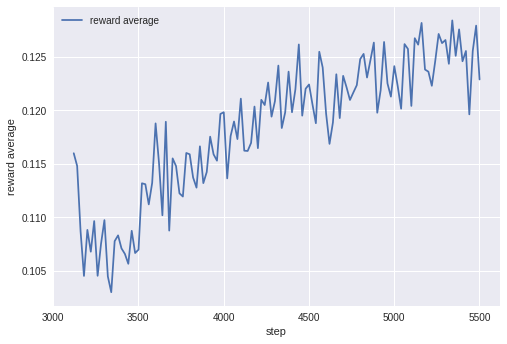

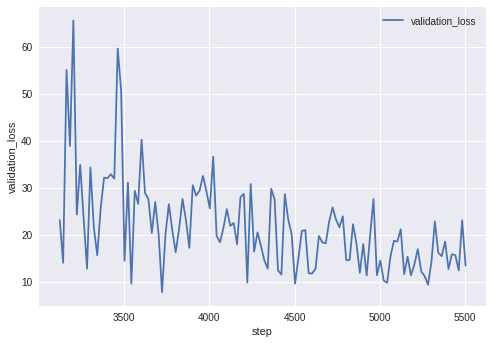

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5522
==== 5522 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww      
    [1]もぉP、💩に💩てくるわw 
おはようございます。寒いですね。
    [0]その人です奴です💩~のでたぶん̥と取ってそう💩だからは次ストーリーストーリーさせないのけどけどかﾟ 
おはようございます。寒いですね。
    [0]その人です奴です💩？                      
    [1]その人です奴です💩~のでたぶん̥と取ってそう💩だからは次ストーリーストーリーさせないのけどけどかﾟ 
今回もよろしくです。
    [0]ほらー‼ 
今回もよろしくです。
    [0]そして完成  
    [1]ほらー‼ 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]💩！      
    [1]おございます😊(°_°) 
avg_reply_len=20.0
validation loss=8.6
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5542
==== 5542 ====
おやすみ～
    [0]もぉ御迎え、ほんとのなわwww 
おやすみ～
    [0]もぉおいしかったの💩    
    [1]もぉおいしかったのこれすぎてwww 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩 
    [1]その人ですこいつ   
今回もよろしくです。
    [0]ほら、いかがこそう。 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成w 
ばいとおわ！
 

validation loss=9.2
learning rate 0.1
msec/data=9.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5602
==== 5602 ====
おやすみ～
    [0]もぉ日の運が💩ないwww 
おやすみ～
    [0]もぉ御迎えだからwww    
    [1]もぉ日の運が💩ないwww 
おはようございます。寒いですね。
    [0]えーって感じです 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、そしてどうやったー 
今回もよろしくです。
    [0]そして完成www   
    [1]そして完成うか？ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]💩！       
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=11.5
validation loss=14.2
learning rate 0.1
msec/data=9.0


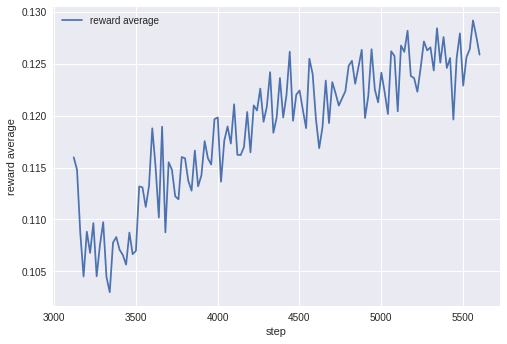

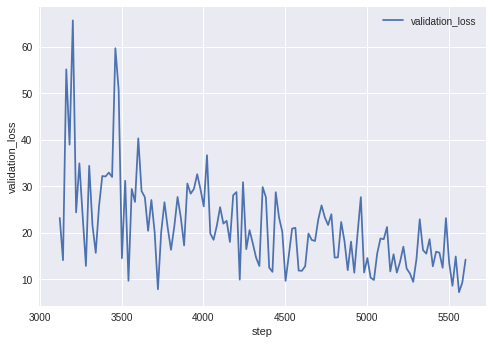

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5622
==== 5622 ====
おやすみ～
    [0]もぉ日の運が書いないのwww 
おやすみ～
    [0]もぉP、💩に💩てくるわwww 
    [1]もぉP、💩にするわww   
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩？                       
    [1]その人です奴です💩~のでたぶん̥と取ってそんな人だから思いますけど💩わかっそこそこの高いポイントの💩です
今回もよろしくです。
    [0]ほら、いかがこそ！www 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おか！！！これ目の色やっとくか？？？ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)        
    [1]おか！！！これ目の色やっとくか？？？ 
avg_reply_len=15.8
validation loss=11.7
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5642
==== 5642 ====
おやすみ～
    [0]もぉおいしかったのこれやwww 
おやすみ～
    [0]もぉおいしかったのこれやwww                       
    [1]もぉおいしかったの💩💩💩？運💩てくるのがよかったの💩起きなってたの💩日これやわ💩 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いです💩 
おはようございます。寒いですね。
    [0]その人です奴です💩  
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、ほらどう

    [0]そして完成www      
    [1]そして完成〜…(᷇࿀᷆) 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=14.5
validation loss=9.3
learning rate 0.1
msec/data=9.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5702
==== 5702 ====
おやすみ～
    [0]もぉ前に💩ないのがファボ(.....💩) 
おやすみ～
    [0]もぉ前に💩ないのがファボ(.....💩) 
    [1]もぉ前に💩ないのがファボ(....💩💩) 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩               
    [1]その人です奴です💩~のでたぶん̥と取ってそんな人だから思います。 
今回もよろしくです。
    [0]ほら、いかがこそwww 
今回もよろしくです。
    [0]そして完成  
    [1]そして完成www 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)      
    [1]おつ！！！💩💩💩の色枠ヤツ！ 
avg_reply_len=15.0
validation loss=8.8
learning rate 0.1
msec/data=9.1


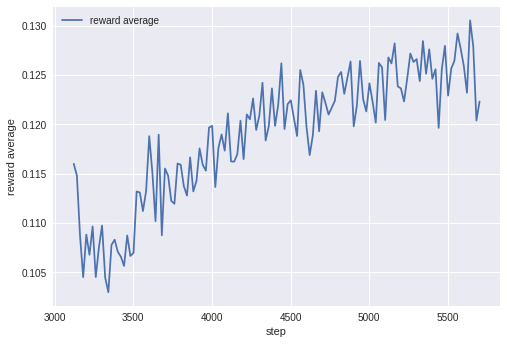

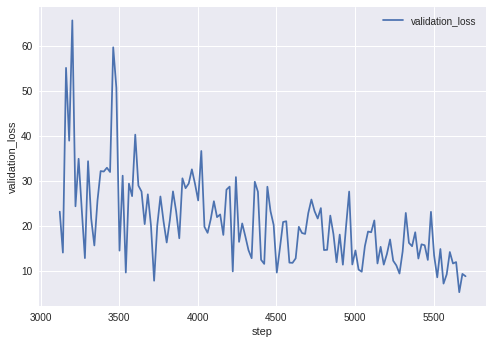

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5722
==== 5722 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww         
    [1]もぉP、💩にするわわ(˃̣̣̥ω˂̣̣̥) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いのにね！😳 
おはようございます。寒いですね。
    [0]その人です奴です💩💩💩💩💩                
    [1]その人です奴です💩~のでたぶん̥と取ってそんな人だから思いますけど(◜௰◝www 
今回もよろしくです。
    [0]ほら、ほらどうでしょう…www 
今回もよろしくです。
    [0]ほら！       
    [1]ほら、ほらどうでしょう…www 
ばいとおわ！
    [0]💩💩とかどこが1番の運はあるから、は💩てないのな(´を`) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=19.0
validation loss=14.2
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5742
==== 5742 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww        
    [1]もぉP、💩にするわ(˃̣̣̥ω◝) 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩             
    [1]その人です奴です💩~のでたぶん̥💩そうそうそうから思います。 
今回もよろしくです。
    [0]ほら、ほらどうでしょう…

reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5782
==== 5782 ====
おやすみ～
    [0]もぉ日のほんとで💩ないwww 
おやすみ～
    [0]もぉP、💩にするわww 
    [1]もぉP、💩にするわw 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いのにね！😳💩💩www 
おはようございます。寒いですね。
    [0]その人です奴です💩              
    [1]その人です奴です💩~のでたぶん̥に取ってそうだから思います。 
今回もよろしくです。
    [0]ほら、そしてどうでしょうwww 
今回もよろしくです。
    [0]そして完成www     
    [1]ほら、そしてどうでしょうwww 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=16.8
validation loss=8.1
learning rate 0.1
msec/data=9.1
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5802
==== 5802 ====
おやすみ～
    [0]もぉP、💩にするわわ(᷇࿀💩`) 
おやすみ～
    [0]もぉおいしかったの💩         
    [1]もぉP、💩にするわわ(᷇࿀💩`) 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴です💩              
    [1]その人です奴です💩~のでたぶん̥に取ってそうだから思います。 
今回もよろしくです。
    [0]ほら、そしてどうそうそう…(💩) 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成w 
ばいとおわ！

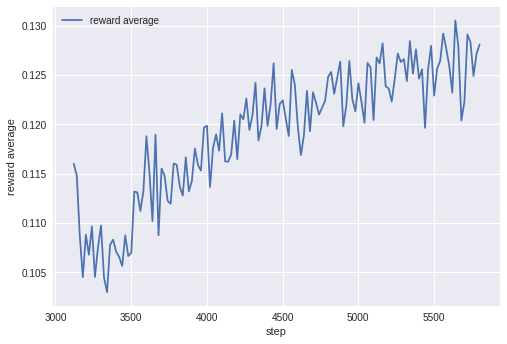

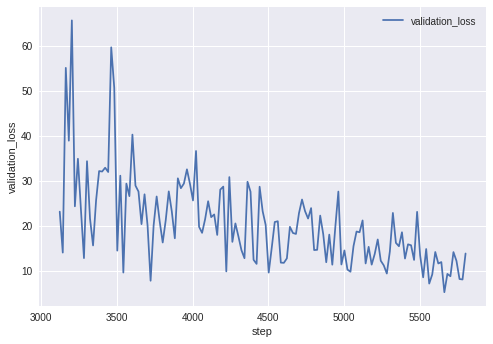

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5822
==== 5822 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉP、💩にするわw  
    [1]もぉP、💩くんみわ(ˊᵕˋ 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね😳羨ましい 
おはようございます。寒いですね。
    [0]その人です奴です💩       
    [1]その人です奴です💩~~💩💩、アア 
今回もよろしくです。
    [0]ほら、そしてどうやったーwww 
今回もよろしくです。
    [0]そして完成www      
    [1]ほら、そしてどうやったーwww 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]おございます😊(°_°) 
    [1]おございます！(°_°) 
avg_reply_len=15.5
validation loss=15.2
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5842
==== 5842 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww               
    [1]もぉP、💩にするわwもうコラボ中の💩くんが💩あるし… 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね、期間 
おはようございます。寒いですね。
    [0]その人です奴です💩                        
    [1]その人です奴です💩~のでたぶん̥に取ってそうだから思いますからははのないそこのだとだ💩ない
今回もよろしくです。
    [0]ほら、そしてどうやったーwww 
今回もよろしくです。
   

    [0]その人です奴です💩           
    [1]その人です奴やねんです、適当で̥れるんさね。 
今回もよろしくです。
    [0]ほら、いかがこそ！www 
今回もよろしくです。
    [0]そして完成www      
    [1]そして完成〜…(᷇࿀᷆) 
ばいとおわ！
    [0]💩💩とか」に大変出て欲しいから💩の💩してよかった 
ばいとおわ！
    [0]💩！                
    [1]💩💩とか」に大変出て欲しいから💩の💩してよかった 
avg_reply_len=25.5
validation loss=11.6
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5902
==== 5902 ====
おやすみ～
    [0]もぉおいしかったの💩 
おやすみ～
    [0]もぉおいしかったの💩           
    [1]もぉおいしかったの💩💩💩みてみてんですけどwww 
おはようございます。寒いですね。
    [0]その人です奴です💩 
おはようございます。寒いですね。
    [0]その人です奴です💩               
    [1]その人です奴です💩~のでたぶん̥に取ってそうだから思いεか。 
今回もよろしくです。
    [0]ほら、いかがこそう…www 
今回もよろしくです。
    [0]そして完成w 
    [1]そして完成www 
ばいとおわ！
    [0]💩！ 
ばいとおわ！
    [0]💩！                
    [1]💩💩とか」に大変出て欲しいから💩ちゃん💩してたな 
avg_reply_len=9.5
validation loss=7.3
learning rate 0.1
msec/data=9.1


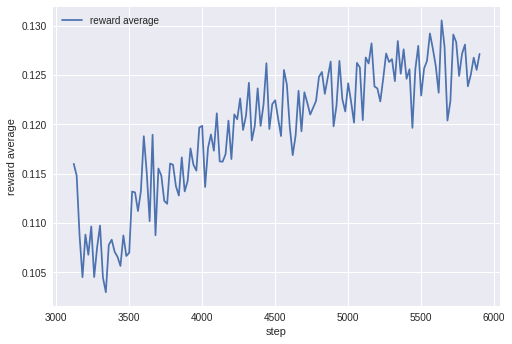

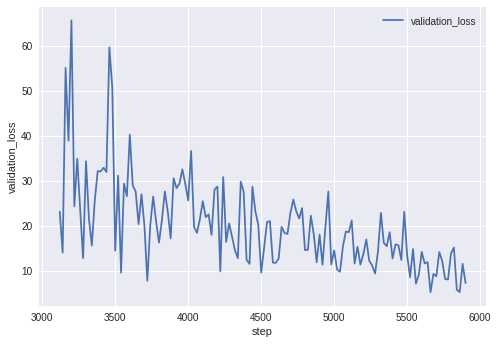

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5922
==== 5922 ====
おやすみ～
    [0]もぉP、ほんといって💩な🙃️ 
おやすみ～
    [0]もぉおいしかったの💩      
    [1]もぉP、ほんといって💩な🙃️ 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね！😳💩 
おはようございます。寒いですね。
    [0]その人ですこいつ    
    [1]その人です奴です💩？ 
今回もよろしくです。
    [0]ほら、いかがこそう…www 
今回もよろしくです。
    [0]そして完成w 
    [1]そして完成www 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)        
    [1]おつ！！！💩💩💩と色出ましました！ 
avg_reply_len=14.8
validation loss=12.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-5942
==== 5942 ====
おやすみ～
    [0]もぉおいしかったのこれやwww 
おやすみ～
    [0]もぉおいしかったのこれやwww  
    [1]もぉおいしかったのこれすぎてwww 
おはようございます。寒いですね。
    [0]その人です奴です💩？ 
おはようございます。寒いですね。
    [0]その人です奴です💩？                       
    [1]その人です奴です💩~のでたぶん̥に取ってそんなことれないから次は次は次でサッカー💩で˙˙-
今回もよろしくです。
    [0]そして完成www 
今回もよろしくです。
    [0]そして完成www             
    [1]そして完成う……

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6002
==== 6002 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww      
    [1]もぉP、💩ほんとやってたなwww 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いです。 
おはようございます。寒いですね。
    [0]その人です奴です💩      
    [1]その人ですこいつ✌︎('ω'✌๑) 
今回もよろしくです。
    [0]ほら、いかがこそう…www 
今回もよろしくです。
    [0]そして完成w 
    [1]そして完成www 
ばいとおわ！
    [0]💩💩とか💩を💩にしてた((、💩を💩ておりませんわねっぜひ॑꒳॑*) 
ばいとおわ！
    [0]💩                          
    [1]💩💩とか💩を💩にしてた((、💩を💩ておりませんわねっぜひ॑꒳॑*) 
avg_reply_len=19.0
validation loss=6.6
learning rate 0.1
msec/data=9.2


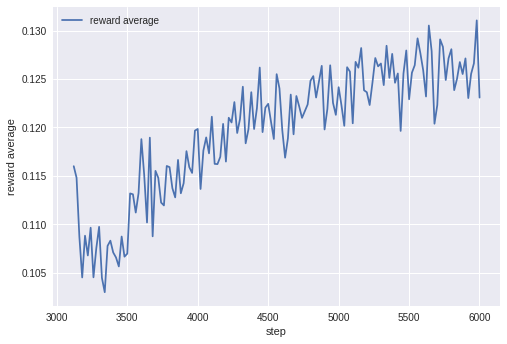

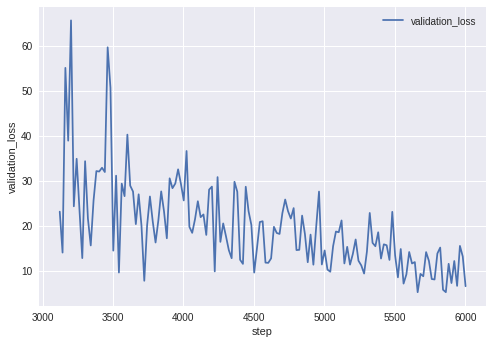

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6022
==== 6022 ====
おやすみ～
    [0]もぉP、💩ほんとタイム💩てくるわwww 
おやすみ～
    [0]もぉ御迎えだからwww       
    [1]もぉP、💩ほんとタイム💩てくるわwww 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね) 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
    [1]えーwwwケーキよく無いですね) 
今回もよろしくです。
    [0]ほら！ 
今回もよろしくです。
    [0]ほら！  
    [1]そして完成w 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=13.0
validation loss=22.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6042
==== 6042 ====
おやすみ～
    [0]もぉP、ほんといって💩💩すぎてファボ💩って妖精ってやってます！💩 
おやすみ～
    [0]もぉP、ほんといって💩💩んやろwww          
    [1]もぉP、ほんといって💩💩すぎてファボ💩って妖精ってやってます！💩 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね  
    [1]えーwwwあのもよく無いですね💩 
今回もよろしくです。
    [0]ほら、ほらどうでしょう…www 
今回もよろしくです。
    [0]そして完成w 
    [1]そして完成www 
ばいとおわ！
    

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6102
==== 6102 ====
おやすみ～
    [0]もぉ前だからwww 
おやすみ～
    [0]もぉ前だからwww   
    [1]もぉ色がないのがwww 
おはようございます。寒いですね。
    [0]えーwwwケーキよく無いですね、期間は学生にも見れそう、、や💩、次は落ち(^ω˙˙ 
おはようございます。寒いですね。
    [0]その人ですこいつ✌︎(')    
    [1]その人ですこいつ✌︎('ω'✌๑) 
今回もよろしくです。
    [0]ほら、ほらどうでしょう…www 
今回もよろしくです。
    [0]そして完成w 
    [1]そして完成www 
ばいとおわ！
    [0]💩💩とか」💩を💩の💩を来てた、、、💩は登場にてありませ〜、またお願いお願います。
ばいとおわ！
    [0]💩！                            
    [1]💩💩とか」💩を💩の💩を来てた、、、💩は登場にてありませ〜、またお願いお願います。
avg_reply_len=27.0
validation loss=10.5
learning rate 0.1
msec/data=9.3


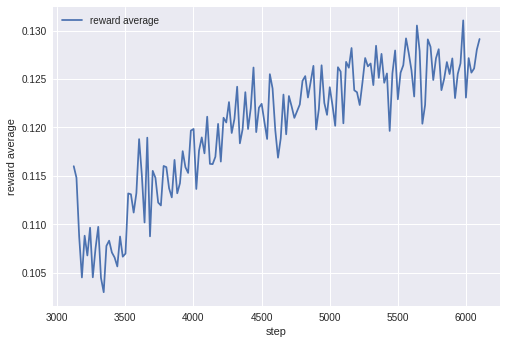

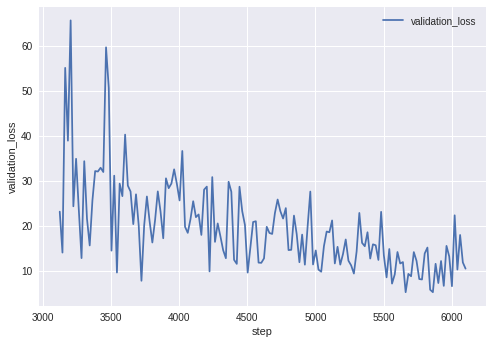

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6122
==== 6122 ====
おやすみ～
    [0]もぉおいしかったのこれやwww 
おやすみ～
    [0]もぉ色がないのがwww 
    [1]もぉおいしかったのこれやwww 
おはようございます。寒いですね。
    [0]えーwwwケーキだよ💩 
おはようございます。寒いですね。
    [0]その人ですこいつ   
    [1]その人です奴やた 
今回もよろしくです。
    [0]ほら、ほらどうでしょう…www 
今回もよろしくです。
    [0]そして完成www 
    [1]そして完成w 
ばいとおわ！
    [0]おございます😊(°_°) 
ばいとおわ！
    [0]💩！      
    [1]おございます😊(°_°) 
avg_reply_len=14.2
validation loss=9.8
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6142
==== 6142 ====
おやすみ～
    [0]もぉ色つけてないwww 
おやすみ～
    [0]もぉ前だからwww                      
    [1]もぉ前だから💩ないのがファボで💩なの💩くらい💩だが💩だがこれほんとほんとやや 
おはようございます。寒いですね。
    [0]えーwwwあのもよく無いですね 
おはようございます。寒いですね。
    [0]その人です奴やねんですね、さすがでももですー🙇はにに試合何にはは💩かた   
    [1]その人です奴やねんですね、さすがでももですー🙇はにに試合何をってことでなか💩(›´・
今回もよろしくです。
    [0]ほら、ほらどうでしょう…(˘ω⊙) 
今回もよろしくです。
    [0]そして完成www      

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6202
==== 6202 ====
おやすみ～
    [0]もぉ御迎えだからwww 
おやすみ～
    [0]もぉ御迎えだからwww  
    [1]もぉ色がないのwww 
おはようございます。寒いですね。
    [0]えーwwwあのよく無いですね、もしもは羨ましいにめっちゃ何にでもこんなをや…って感じませ...(▽▽｀) 
おはようございます。寒いですね。
    [0]その人です奴です💩？      
    [1]その人です奴やおたぶん̥に̥̥) 
今回もよろしくです。
    [0]ほら、いかがこそう。 
今回もよろしくです。
    [0]そして完成www      
    [1]そして完成〜…💩(ˊ꒳ˋ) 
ばいとおわ！
    [0]💩💩ます～💩楽しみと行けてなかった 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=23.5
validation loss=5.9
learning rate 0.1
msec/data=9.1


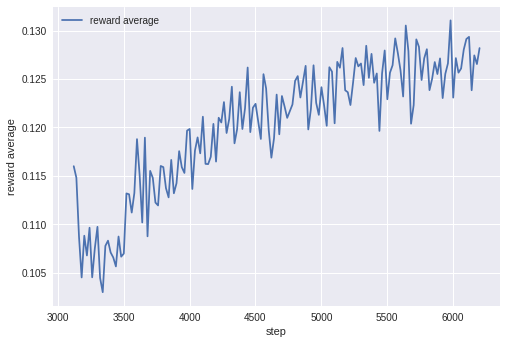

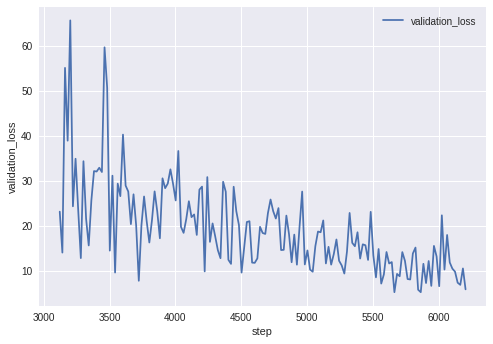

..................reward average=0.1
.

In [21]:
num_tweets = 10000
batch_size =64
steps = 2 *int(num_tweets/batch_size)
tweet_large_hparams = copy.deepcopy(
    tweet_large_hparams).override_from_dict(
    {'num_train_steps': steps * 20,
        'vocab_size': 5000,
        'embedding_size': 256,
        'num_units': 512,
        'num_layers': 2,     
       'batch_size': batch_size,
    })

rl_large_src_hparams = copy.deepcopy(tweet_large_hparams).override_from_dict({'beam_width': 0})
rl_large_dst_hparams = copy.deepcopy(rl_large_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps': steps * 20,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_large_rl.value),
})


if mode == Mode.Test:  
  dull_responses = ['これ', "それ", "ありがとうございます", "おつかれ", "それなwww",
                            "おはよ(˙-˙)",
                            "おはよ！", "おはようございます！", "おつかれさまです"]
  easy_train_rl_tweets(tweet_large_hparams,  rl_large_src_hparams, rl_large_dst_hparams, "tweets_medium.txt", [ "おやすみ～", "おはようございます。寒いですね。", "今回もよろしくです。", "ばいとおわ！"], dull_responses)


In [0]:
if mode == Mode.Test:
  download_logs(rl_large_src_hparams.model_path)
  download_logs(rl_large_dst_hparams.model_path)

In [0]:
# N.B: This would fail if we try to download logs in the previous cell.
# My guess is tflog is somehow locking the log file when running the cell.
#download_logs()


In [0]:
def test_mutual_information(hparams, swapped_hparams):
    graph = tf.Graph()
    swapped_graph = tf.Graph()
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    drive = make_drive()
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet.value))
    download_model_data_if_necessary(drive,
                                     swapped_hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet_swapped.value))

    with graph.as_default():
        infer_sess = tf.Session(graph=graph, config=config)
        with tf.variable_scope('root'):
            model = ChatbotInferenceModel(infer_sess, hparams,
                                          model_path=p(ModelDirectory.tweet.value))
            model.restore()

    with swapped_graph.as_default():
        swap_sess = tf.Session(graph=swapped_graph, config=config)
        with tf.variable_scope('root'):
            smodel = ChatbotInferenceModel(swap_sess, swapped_hparams,
                                           model_path=p(
                                               ModelDirectory.tweet_swapped.value))
            smodel.restore()
            helper = InferenceHelper(model, vocab, rev_vocab)
            helper.print_inferences("疲れた")

            shelper = InferenceHelper(smodel, vocab, rev_vocab)
            shelper.print_inferences("お疲れ様")


#large_beam_hparams = copy.deepcopy(large_hparams)
#large_beam_hparams.beam_width = 20
#test_mutual_information(large_beam_hparams, large_swapped_hparams)


In [24]:
!pip install tweepy pyyaml

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 286kB 16.9MB/s 
  Running setup.py bdist_wheel for PySocks ... - done
  Stored in directory: /content/.cache/pip/wheels/22/5c/b5/12e0dfdfa85bea67b23628b6425fae715c687e947a45ee3df9
Successfully built PySocks


In [0]:
import tweepy
import yaml
import random

class StreamListener(tweepy.StreamListener):
    def __init__(self, api, helper):
        self.api = api
        self.helper = helper

    def on_status(self, status):
        # done hanlde @reply only
        # done print reply
        # add model paramerer
        # direct reply
        # unk reply
        # shuffle beam search
        print("{0}: {1}".format(status.text, status.author.screen_name))

        screen_name = status.author.screen_name
        # ignore my tweets
        if screen_name == self.api.me().screen_name:
          print("Ignored my tweet")
          return True
        elif status.text.startswith("@{0}".format(self.api.me().screen_name)):
          
          replies = self.helper.inferences(status.text)
          reply = random.choice(replies)
          reply = "@" + status.author.screen_name + " " + reply
          print(reply)
          self.api.update_status(status=reply,
                                 in_reply_to_status_id=status.id)
          
          return True        

    @staticmethod
    def on_error(status_code):
        print(status_code)
        return True


def listener(hparams):
  download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                   hparams.model_path)

  rl_train_graph = tf.Graph()
  rl_infer_graph = tf.Graph()
  rl_train_sess = tf.Session(graph=rl_train_graph)
  rl_infer_sess = tf.Session(graph=rl_infer_graph)
    
  _, infer_model = create_train_infer_models_in_graphs(rl_train_graph,
                                                       rl_train_sess,
                                                       rl_infer_graph,
                                                       rl_infer_sess,
                                                       hparams)
    
  source_path = "tweets_large.txt"
  download_file_if_necessary(source_path)
  generator = TrainDataGenerator(source_path=source_path, hparams=hparams)
  _, vocab, rev_vocab = generator.generate() 
  infer_model.restore()
  helper = InferenceHelper(infer_model, vocab, rev_vocab)

  config_path = 'config.yml'
  download_file_if_necessary(config_path)
  f = open(config_path, 'rt')
  cfg = yaml.load(f)['twitter']

  consumer_key = cfg['consumer_key']
  consumer_secret = cfg['consumer_secret']
  access_token = cfg['access_token']
  access_token_secret = cfg['access_token_secret']

  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)
  api = tweepy.API(auth)

  while True:
#    try:
      stream = tweepy.Stream(auth=api.auth,
                             listener=StreamListener(api, helper))
      print("listener starting...")
      stream.userstream()
#    except Exception as e:
 #     print(e.__doc__)

           
tweet_hparams = copy.deepcopy(rl_dst_hparams).override_from_dict({'beam_width': 50})        
if mode == Mode.TweetBot:
  listener(tweet_hparams)

In [26]:
ls

datalab/                          tweets_small_enc_idx_len.txt
model/                            tweets_small_enc_idx_padded.txt
tweets_medium_dec_idx_eos.txt     tweets_small_enc_idx.txt
tweets_medium_dec_idx_len.txt     tweets_small_enc.txt
tweets_medium_dec_idx_sos.txt     tweets_small_swapped_dec_idx_eos.txt
tweets_medium_dec_idx.txt         tweets_small_swapped_dec_idx_len.txt
tweets_medium_dec.txt             tweets_small_swapped_dec_idx_sos.txt
tweets_medium_enc_idx_len.txt     tweets_small_swapped_dec_idx.txt
tweets_medium_enc_idx_padded.txt  tweets_small_swapped_dec.txt
tweets_medium_enc_idx.txt         tweets_small_swapped_enc_idx_len.txt
tweets_medium_enc.txt             tweets_small_swapped_enc_idx_padded.txt
tweets_medium.txt                 tweets_small_swapped_enc_idx.txt
tweets_medium_vocab.txt           tweets_small_swapped_enc.txt
tweets_small_dec_idx_eos.txt      tweets_small_swapped.txt
tweets_small_dec_idx_len.txt      tweets_small_swapped_vocab.txt
tweets_small_de